In [200]:
%matplotlib inline
import re
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib as mpl
from matplotlib.colors import SymLogNorm
import scienceplots

import astropy.units as u
from astropy import constants
from astropy.table import Table
from astropy.coordinates import SkyCoord,FK5,ICRS
from astropy.io import fits,ascii
from astropy.wcs import WCS, utils as wcsutils
from astropy.stats import sigma_clipped_stats
import astropy.visualization as vis
from astropy.modeling import models, fitting
from astropy.nddata import StdDevUncertainty, Cutout2D
from astropy.convolution import Gaussian2DKernel,Gaussian1DKernel
from astropy.cosmology import Planck18,FlatLambdaCDM
from scipy.signal import find_peaks
#from scipy.constants import c


from specutils import Spectrum1D, SpectralRegion
from specutils.fitting import estimate_line_parameters,fit_lines,find_lines_threshold
from specutils.manipulation import extract_region

from photutils.aperture import EllipticalAperture, SkyEllipticalAperture

import os, sys, glob, pdb, scipy

from importlib import reload
import pyregion as pyreg
from spectral_cube import SpectralCube
from reproject import reproject_interp
import regions
from regions.shapes.circle import CircleSkyRegion,CirclePixelRegion
from regions import CircleAnnulusSkyRegion, CircleAnnulusPixelRegion, RectangleSkyRegion
from regions import PixCoord
mycosmos=FlatLambdaCDM(H0=70, Om0=0.3)

In [207]:
mycosmos.kpc_proper_per_arcmin(3.17)

<Quantity 7.57336707 kpc / arcmin>

In [3]:
brightu = r"Brightness $\rm (10^{-4}~erg~s^{-1}~arcsec^{-2}~cm^{-2}~\AA^{-1})$"
def imshow_astro(img, wcsinfo = None, figsize = (10,10), colorbar =True,
               cblabel="", cbfrac = 0.035, norm = None,
               stretch = vis.LinearStretch(), cmap = "hot",
               vrange = (None, None)):
    
    _, med, std = sigma_clipped_stats(img.data)
    
    fig =  plt.figure(figsize = figsize)
    if wcsinfo:
        ax = plt.subplot(projection = wcsinfo)
    else:
        ax = plt.subplot()
    
    vmin, vmax = vrange
    
    if not vmin:
        vmin = med
    if not vmax:
        vmax = med + 10*std
    if not norm:
        norm = vis.ImageNormalize(vmin = vmin, vmax = vmax, stretch = stretch)
    im = ax.imshow(img, norm = norm, cmap = cmap)
    if colorbar:
        cb = plt.colorbar(im, label = cblabel, fraction =cbfrac)
    return fig, ax, im
KBSSpath="/disk/bifrost/yuanze/KBSS"

## analysis for regular AGN

In [179]:
path_to_result_HL="/disk/bifrost/yuanze/my_work/cigale/out_HLQSO"
mod_HL=Table.read(path_to_result_HL+"/results.fits")

path_to_result_1="/disk/bifrost/yuanze/my_work/cigale/out_type1"
mod_1=Table.read(path_to_result_1+"/results.fits")

path_to_result_2="/disk/bifrost/yuanze/my_work/cigale/out_type2"
mod_2=Table.read(path_to_result_2+"/results.fits")

Lya_v={}
Lya_SB={}
Lya_sigma={}
agn="best.agn.intrin_Lnu_2500A_30deg"
mstar="bayes.stellar.m_star"
sfr="bayes.sfh.sfr"
id_2=mod_2["id"]
id_1=mod_1["id"]
mstar_2=[mod_2[mstar],mod_2[mstar+"_err"]]
mstar_1=[mod_1[mstar],mod_1[mstar+"_err"]]
sfr_2=[mod_2[sfr],mod_2[sfr+"_err"]]
sfr_1=[mod_1[sfr],mod_1[sfr+"_err"]]
Lagn_2=[mod_2[agn],0]#mod_1[agn+"_err"]]
Lagn_1=[mod_1[agn],0]#mod_1[agn+"_err"]]

#sed=Table.read(path_to_result+"/{}-{}_best_model.fits".format(field,sourcename))

#wavelength_spec = sed["wavelength"].value*1e-3
# wavelength in micron

#z=obs["redshift"].value[0]
#zp1 = 1.0 + z
#surf = 4.0 * np.pi * mod["best.universe.luminosity_distance"] ** 2
#fact = 1e29 * 1e-3 * wavelength_spec ** 2 / c / surf

#for cname in sed.colnames[1:]:
#    sed[cname] *= fact

For type 2 AGN, check correlation:

cross-correlation for:

M_star, SFR, AGN luminosity (for now use 2500A intrinsic), AGN 

1: M_star vs average Lya velocity
2: M_star vs average Lya SB
3: SFR vs average Lya velocity
4: SFR vs average Lya SB
3: AGN luminosity vs average Lya SB
4: AGN luminosity vs average Lya velocity

In [180]:
annulus_bin={}
annulus_value={}
Lya_3arc={}

In [181]:
cond=(id_1 != "Q2343-FSzP1170") & (id_1 != "Q2343-Q2343")
filtered_id_1 = id_1[cond]

In [184]:
id_1

Q1549-MD10
Q1549-MD17
Q1549-BX101
Q0100-BX164
Q0100-BX160
Q0821-RK5
Q2343-BX415
Q2343-FSzP1170
Q2343-Q2343


In [263]:
type="HLQSO"

qsos = ascii.read(KBSSpath+"/KCWI/qsos.kcwi",format="ipac")


#tid=["Q0100-BX160"]

# radius bin
#rbin=np.logspace(-0.5,0.48,num=6)
rbin=np.arange(0.3,6.3,0.3)
# windowsize to extract the Lya nebulae
windowsize=6*u.arcsec

idall=

for id in id_all:
    sourcename=re.findall(r"-(.*)",id)[0]
    field=re.findall(r"(.*)-",id)[0]
    sentry=qsos[qsos["Name"]==sourcename]
    cubename=sentry["Cube"].value[0]
    ext=sentry["ext"].value[0]
    subdapath=KBSSpath+"/"+field+"/"+sourcename
    datapath=KBSSpath+"/"+field+"/"+cubename
    
    if type=="Type-2": #or ext == 'False':
        Subfile = subdapath+"/kcwi_oned/{}-{}_icubes_wcs.CONTSub.fits".format(field.lower(),sourcename)
    else:
        Subfile = subdapath+"/kcwi_oned/{}-{}_icubes_wcs.fits".format(field.lower(),sourcename)
    varfile=datapath+"/kcwi_oned/{}-{}_vcubes.fits".format(field.lower(),cubename)
    
    
    
    O_cube = SpectralCube.read(Subfile)
    OV_cube = SpectralCube.read(varfile)
    wcsinfo = O_cube.wcs.celestial
    RA = sentry["RA"].value[0]
    Dec = sentry["Dec"].value[0]
    if sentry["zneb"]>0:
        redshift=sentry["zneb"].value[0]
    elif sentry["zabs"]>0:
        redshift=sentry["zabs"].value[0]
    else:
        redshift=sentry["zlya"].value[0]
    sc=SkyCoord(ra=RA, dec=Dec, unit='deg',frame="icrs", equinox='J2000')
    sregion=regions.RectangleSkyRegion(sc,width=windowsize, height=windowsize)
    sregion_pix=sregion.to_pixel(wcsinfo)

    Sub_cube=O_cube.subcube_from_regions([sregion_pix])
    Var_cube=OV_cube.subcube_from_regions([sregion_pix])
    
    wcssub=Sub_cube.wcs.celestial
    pixel_scale=wcssub.pixel_scale_matrix[0,0] * 3600
    
    specwidth=1
    cw=1215.67*(1+redshift) * u.AA
    #Lya_varcube = Var_cube.with_spectral_unit(u.km/u.s, velocity_convention='relativistic', rest_value=1215.67*(1+redshift) * u.AA)
    Lya_subvarcube = Var_cube.spectral_slab(cw-20*u.AA,cw+15*u.AA)
    #Lya_cube = Sub_cube.with_spectral_unit(u.km/u.s, velocity_convention='relativistic', rest_value=1215.67*(1+redshift) * u.AA)
    Lya_subcube = Sub_cube.spectral_slab(cw-20*u.AA,cw+15*u.AA)
#    Lya_subcube_wav = Lya_subcube.with_spectral_unit(u.AA, velocity_convention='relativistic', rest_value=1215.67*(1+redshift) * u.AA)
    
    Lya_moment_1 = Lya_subcube.moment(order=1)
    Lya_linewid = Lya_subcube.linewidth_sigma()
    
    Lya_msig = np.sqrt(Lya_subvarcube.sum(axis=0,how='cube'))
    Lya_mflux = (Lya_subcube*specwidth).sum(axis=0,how='cube')

    mask=Lya_mflux.value > 1.0*Lya_msig.value
    #bad=np.isnan(Lya_moment_1[mask])
    Lya_SB[sourcename]=Lya_mflux[mask].mean().value*100
    #flux weighted bulk velocity
    bad=np.isnan(Lya_moment_1[mask])
    Lya_v[sourcename]=(Lya_moment_1*Lya_mflux)[mask][~bad].sum()/Lya_mflux[mask][~bad].sum()
#    Lya_v[sourcename+"_err"]=np.sqrt((Lya_moment_1*Lya_mflux)[mask][~bad].var())/Lya_mflux[mask][~bad].sum()
    #flux weighted velocity dispersion
    bad=np.isnan(Lya_linewid[mask])
    Lya_sigma[sourcename]=(Lya_linewid*Lya_mflux)[mask][~bad].sum()/Lya_mflux[mask][~bad].sum()
#    Lya_sigma[sourcename+"_err"]=np.sqrt((Lya_linewid*Lya_mflux)[mask][~bad].var())/Lya_mflux[mask][~bad].sum()



    # Lya brightness within 3 arcsec
    region_sky = CircleSkyRegion(center=sc, radius=3 * u.arcsec)
    region_pix = region_sky.to_pixel(wcssub)
    Lya_mflux_sub=Lya_subcube.subcube_from_regions([region_pix]).sum(axis=0,how='cube')
    Lya_mvar_sub=Lya_subvarcube.subcube_from_regions([region_pix]).sum(axis=0,how='cube')
    
    npix=np.sum((~np.isnan(Lya_mflux_sub)).astype(int))
    Lya_3arc[sourcename]=[pixel_scale**2*np.nansum(Lya_mflux_sub).value,pixel_scale**2*np.sqrt(np.nansum(Lya_mvar_sub).value)]
    
    # Log scaled radius SB profile
    Aregions=[]
    Aregions_value=[]
    Aregions_sigvalue=[]
    for rind, rin in enumerate(rbin):
        if rind<len(rbin)-1:
            region_annulus_sky = CircleAnnulusSkyRegion(center=sc,
                                                inner_radius=rin * u.arcsec,
                                                outer_radius=rbin[rind+1] * u.arcsec)
            region_annulus_pix = region_annulus_sky.to_pixel(wcssub)
            Aregions.append(region_annulus_pix)
            Lya_mflux_sub=Lya_subcube.subcube_from_regions([region_annulus_pix]).sum(axis=0,how='cube')
            Lya_mvar_sub=Lya_subvarcube.subcube_from_regions([region_annulus_pix]).sum(axis=0,how='cube')
            Aregions_value.append((np.nansum(Lya_mflux_sub/Lya_mvar_sub)/np.nansum(1/Lya_mvar_sub)).value)
            Aregions_sigvalue.append(np.sqrt(1/np.nansum(1/Lya_mvar_sub)).value)
        else:
            continue
    annulus_bin[sourcename]=Aregions
    annulus_value[sourcename]=[Aregions_value,Aregions_sigvalue]
#    mask_annulus_reg = region_annulus_pix.to_mask()
#    mask_annulus_reg = mask_annulus_reg.to_image(Sub_cube.shape[1:]).astype(bool)







/disk/bifrost/yuanze/anaconda3/envs/nmma/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/disk/bifrost/yuanze/anaconda3/envs/nmma/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: divide by zero encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/disk/bifrost/yuanze/anaconda3/envs/nmma/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/disk/bifrost/yuanze/anaconda3/envs/nmma/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: divide by zero encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/disk/bifrost/yuanze/anaconda3/envs/nmma/lib/python3.8/site-packages/astropy/units/quantity.py:673: Ru

In [177]:
Lya_3arc

NameError: name 'Lya_3arc' is not defined

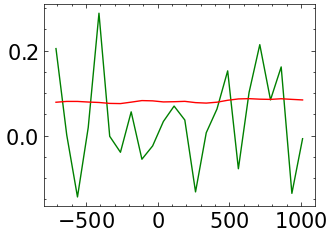

In [99]:
region_sky = CircleSkyRegion(center=sc, radius=3. * u.arcsec)
region_pix = region_sky.to_pixel(wcssub)
specl=np.nansum(Lya_subcube.subcube_from_regions([region_pix]),axis=(1,2))
varl=np.nansum(Lya_subvarcube.subcube_from_regions([region_pix]),axis=(1,2))
plt.plot(Lya_subcube.spectral_axis,specl,color="g")
plt.plot(Lya_subcube.spectral_axis,np.sqrt(varl),color="r")

In [95]:
print(pixel_scale**2*np.sqrt(np.nanmean(Lya_mvar_sub.value)))
print(pixel_scale**2*np.sqrt(np.nansum(Lya_mvar_sub.value)/315))

print(pixel_scale**2*np.nanmean(Lya_mflux_sub.value))
print(pixel_scale**2*np.nansum(Lya_mflux_sub.value)/315)

0.0020162279555832924
0.0020162279555832924
0.0002498428453691104
0.00024984284809655507


In [313]:

Planck18.kpc_proper_per_arcmin(2.84).value

480.51085445909445

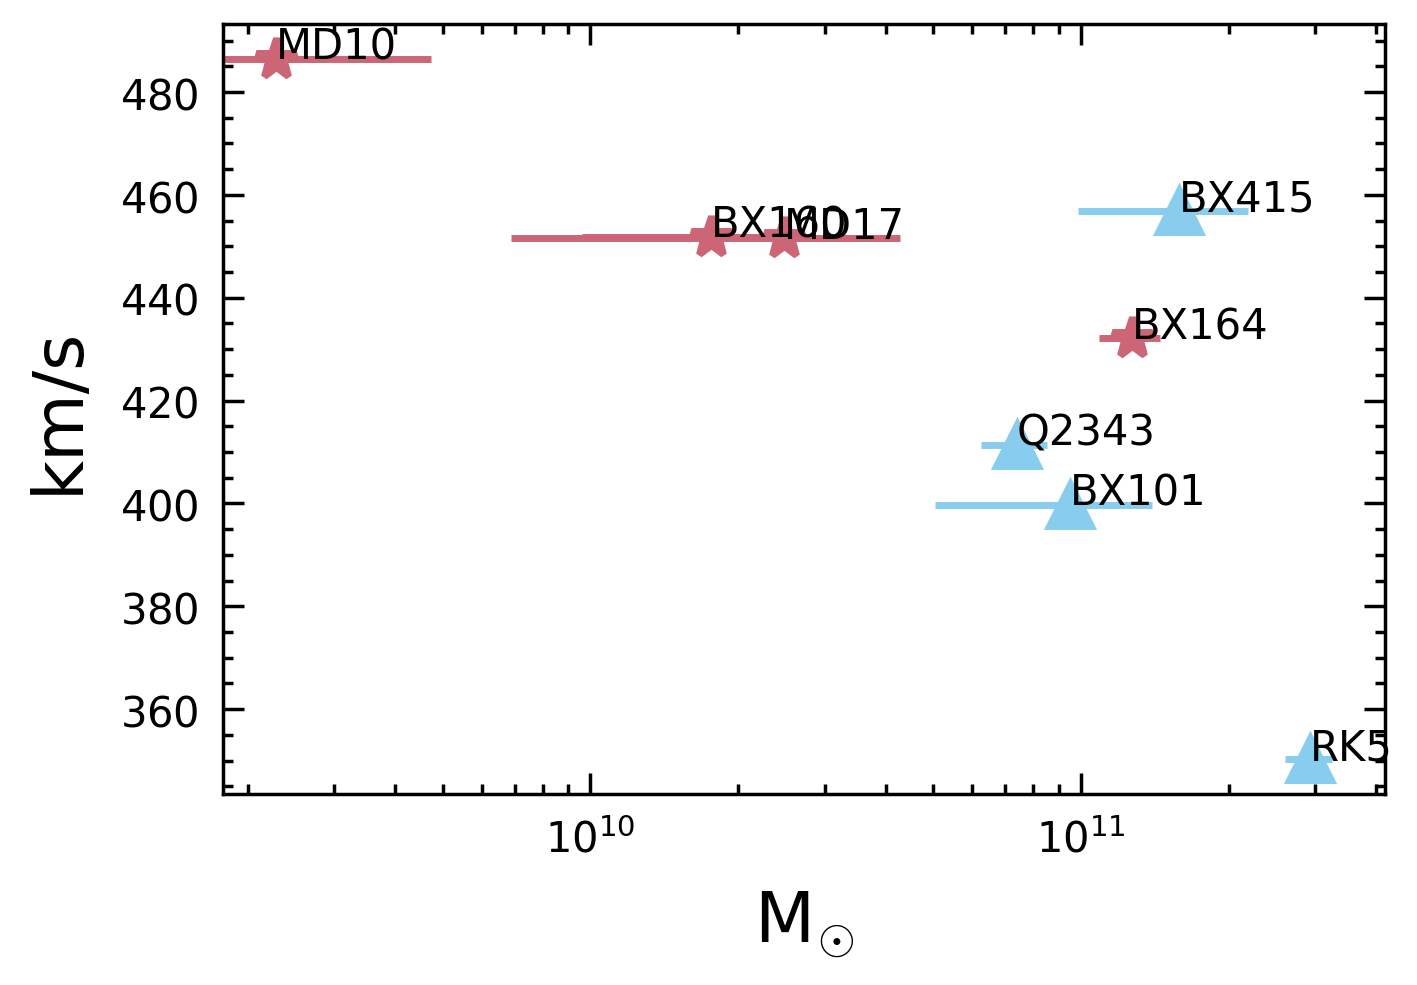

In [19]:
#Ploting spectra for publication
import scienceplots
import matplotlib.pyplot as plt
plt.style.use(["science",'no-latex'])
plt.rcParams.update({
    "font.family": "dejavu sans",   # specify font family here
    "font.serif": ["Times"],  # specify font here
    "font.size":6,
"legend.fancybox":True})

numrow=1
numcol=1
colorlst=["#CC6677","#88CCEE","#6699CC"]
fig=plt.figure(figsize=(3*numcol,2*numrow),dpi=500)
gs = fig.add_gridspec(numrow,numcol, hspace=0)
axs=gs.subplots(sharex=True)
type=1
metrics=Lya_sigma
metrics2=mstar_1
for ind,id in enumerate(filtered_id_1):
    sourcename=re.findall(r"-(.*)",id)[0]
    
    if type == 1:
        sentry=qsos[qsos["Name"]==sourcename]
        ext=sentry["ext"]
        if ext=="True":
            axs.errorbar(metrics2[0][ind],metrics[sourcename],xerr=metrics2[1][ind],fmt="^",color=colorlst[1],label="With Halo")
        else:
            axs.errorbar(metrics2[0][ind],metrics[sourcename],xerr=metrics2[1][ind],fmt="*",color=colorlst[0],label="No Halo")
    else:
        axs.errorbar(metrics2[0][ind],metrics[sourcename],xerr=metrics2[1][ind],fmt="*",color=colorlst[0])
    axs.text(metrics2[0][ind],metrics[sourcename].value,sourcename)#transform=axs.transAxes,verticalalignment='top',horizontalalignment='right',fontsize=7)

axs.set_xscale("log")
#axs.legend(loc='best')
#axs.set_yscale("log")
axs.set_xlabel(r"M$_{\odot}$",fontsize=10)
#axs.set_xlabel(r"M$_{\odot}$/yr",fontsize=10)
#axs.set_xlabel(r"L$_\mathrm{AGN}$ (W/Hz)",fontsize=10)
axs.set_ylabel(r"km/s",fontsize=10)
#axs.set_xlim([1e-2,500])
#axs.set_ylim([5e14,5e17])
#plt.axvline(x=)
#axs=plt.gca()
#axs.text(0.05,0.92,r"$n=10^{%d}\,$cm$^{-3}$"%density,transform=axs.transAxes)
#axs.text(0.05,0.87,r"Log$[\,\xi/$erg$\,$cm$\,$s$^{-1}]=%d $"%logxi,transform=axs.transAxes)

plt.show()
#plt.savefig("./pub2/compRX"+datype+".pdf",dpi=300)

Text(0.5, 1.0, 'Integrated KCWI slice around 1216$\\rm\\,\\AA\\,$(z=2.3)')

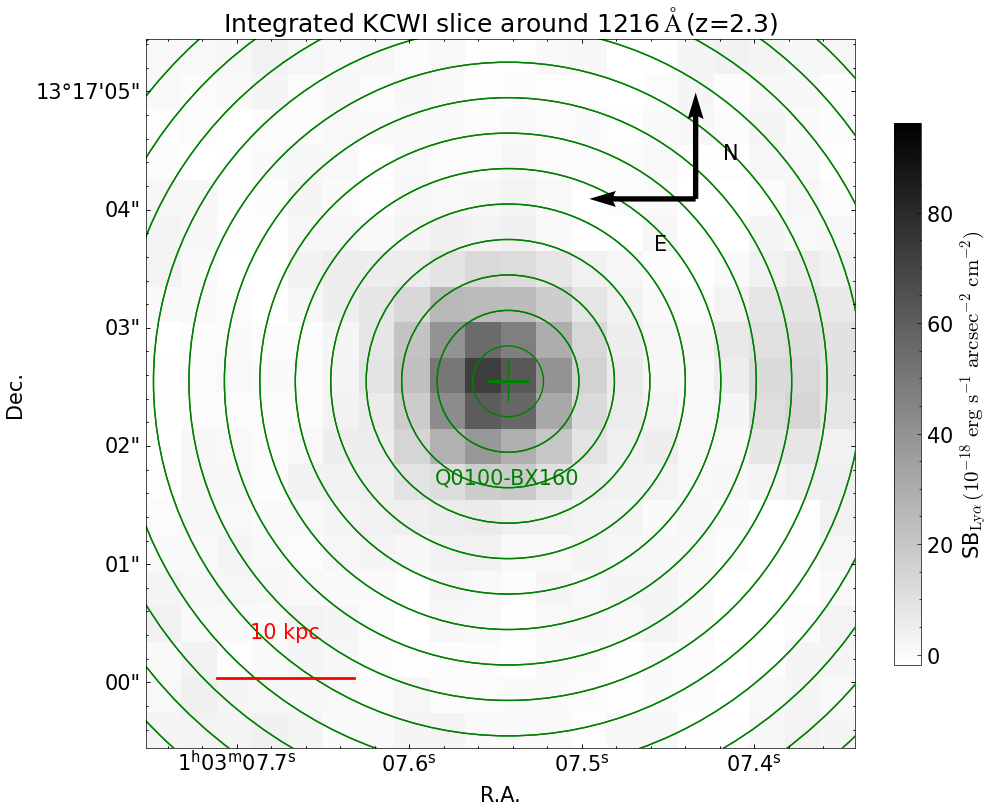

In [271]:
plt.style.use(["science",'no-latex'])
plt.rcParams.update({
    "font.family": "dejavu sans",   # specify font family here
    "font.serif": ["Times"],  # specify font here
    "font.size":15,
"legend.fancybox":True})
#

Lyau = r"SB$_{\rm Ly\alpha}\,\rm (10^{-18}~erg~s^{-1}~arcsec^{-2}~cm^{-2})$"

_, med, std = sigma_clipped_stats(Lya_mflux.value*100)

#mask=Lya_mflux.value < std*0.07
mask=Lya_mflux.value < 1.*Lya_msig.value
plotmom1=Lya_moment_1.copy()
plotmom1[mask]=np.nan
# Integrated Lya image



fig, ax, im1 = imshow_astro(Lya_mflux.value*100,wcssub , cblabel = Lyau, colorbar=True, vrange = (-std, med+50*std),cmap = "binary")
#im1.set_visible(False)
# Lya velocity map
cmap = plt.cm.cividis
cmap.set_bad(color='none') 
alpha=1
vmin=-400
vmax=800

#im = ax.imshow(plotmom1.value,cmap=cmap,alpha=alpha,vmin=vmin,vmax=vmax)#,norm=norm)

#cb = plt.colorbar(im, label = r"Velocity shift ($\rm km~s^{-1}$)", fraction =0.035)

#Source position
#psname=sourcename


sc = SkyCoord(ra=RA, dec=Dec, unit='deg',frame="icrs", equinox='J2000')
s_coord=wcssub.world_to_pixel(sc)

#s_coord3=wcsinfo.world_to_pixel(sc3)
#ax.plot(s_coord3[0],s_coord3[1],"+",c="r",ms=30,lw=0.1)
for aregion in Aregions:
    ax.add_artist(aregion.as_artist(facecolor='none', edgecolor='green'))

ax.plot(s_coord[0],s_coord[1],"+",c="g",ms=30,lw=0.1)
ax.text(s_coord[0]+2,s_coord[1]-3
        ,"{}-{}".format(field,sourcename),color="green",verticalalignment='bottom',horizontalalignment='right',fontsize=15)


#ax.scatter(sc3.ra.value, sc3.dec.value, transform=ax.get_transform('world'), s=55, edgecolor='r', facecolor='none')
#ax.text(sc3.ra.value, sc3.dec.value,"{}-{}".format(cubename,tag3),color="red",transform=ax.get_transform('world'),verticalalignment='bottom',horizontalalignment='right',fontsize=15)



x0, y0 = 15, 15
arrow_length = 3

# North arrow goes upward in y-direction (positive Dec)
ax.quiver(x0, y0, 0, arrow_length, angles='xy', scale_units='xy', scale=1, color='black', label='North')
ax.text(x0+1, y0+1, 'N', color='black', ha='center', va='bottom')
# East arrow goes to the right in x-direction (negative RA)
ax.quiver(x0, y0, -arrow_length, 0, angles='xy', scale_units='xy', scale=1, color='black', label='East')
ax.text(x0-1, y0-1, 'E', color='black', ha='center', va='top')


#-------------------Reference scale setting----------------#
dT = 10  # kpc distance
delta_theta_deg = dT/Planck18.kpc_proper_per_arcmin(redshift).value/60
x_lim = ax.get_xlim()
y_lim = ax.get_ylim()
start_x = x_lim[0] + 0.10 * (x_lim[1] - x_lim[0])
start_y = y_lim[0] + 0.10 * (y_lim[1] - y_lim[0])
start_coord = wcssub.pixel_to_world(start_x, start_y)
end_coord = wcssub.pixel_to_world(start_x + 1, start_y)  # arbitrary +1 in pixel to get RA difference for 1 pixel

delta_ra_per_pixel = start_coord.ra.degree - end_coord.ra.degree
length_in_pixels = delta_theta_deg / delta_ra_per_pixel

ax.plot([start_x, start_x + length_in_pixels], [start_y, start_y], color='red', lw=2)
ax.text(start_x + length_in_pixels / 2, start_y+1, '{} kpc'.format(dT), color='red', ha='center', va='bottom')

ax.set_xlabel("R.A.")
ax.set_ylabel("Dec.")

ax.set_title(r"Integrated KCWI slice around {}$\rm\,\AA\,$(z={})".format(1216,round(redshift,2)))
#plt.show()

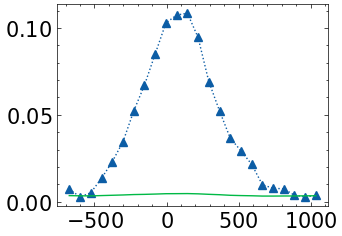

In [304]:
#stdm=np.mean(np.sqrt(sub_varcube2[:,i,j]))
#kernel = Gaussian1DKernel(2)
#new_cube = spectrum.spectral_smooth(kernel)
#_,med,std=sigma_clipped_stats(spectrum)
spectrum = Lya_subcube[:, int(np.round(s_coord[0]))+3,int(np.round(s_coord[1]))]
varspec= Lya_subvarcube[:, int(np.round(s_coord[0]))+3,int(np.round(s_coord[1]))]
plt.plot(Lya_subcube.spectral_axis,spectrum,"^:")
plt.plot(Lya_subvarcube.spectral_axis,np.sqrt(varspec))
#plt.xlim([1210,1221])
#plt.plot(spectral_axis[33],spectrum[28],"*")
#fp = find_peaks(spectrum,prominence=(stdm.value, None))
#print(stdm)
#print(fp)
#print(line_centers1[i,j])
#print(spectral_axis[fp[0][0]])

In [338]:
sourcename

'KP76'

In [264]:
from astropy.modeling import models, fitting

sourcename="BX160"
sentry=qsos[qsos["Name"]==sourcename]
field=sentry['Field'].value[0]
if sentry["zneb"]>0:
        redshift=sentry["zneb"].value[0]
elif sentry["zabs"]>0:
    redshift=sentry["zabs"].value[0]
else:
    redshift=sentry["zlya"].value[0]

kpc_per_arcsec=Planck18.kpc_proper_per_arcmin(redshift).value/60
rx=np.diff(rbin)*kpc_per_arcsec

#model = models.Sersic1D(amplitude=0.07,n=1,r_eff=4.6)
model = models.Moffat1D(x_0=0)
#model.n.fixed=True
model.x_0.fixed=True
#fitter = fitting.LevMarLSQFitter()
# Fit the model
#fitted_model = fitter(model,rbin[:-1]*kpc_per_arcsec+rx/2,np.array(annulus_value[sourcename][0]),weights=1/np.array(annulus_value[sourcename][1]))
#print(fitted_model)


In [265]:
rbin[:-1]

array([0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. , 3.3, 3.6, 3.9,
       4.2, 4.5, 4.8, 5.1, 5.4, 5.7])

Text(0, 0.5, 'SB $\\rm (10^{-18}~erg~s^{-1}~cm^{-2})$')

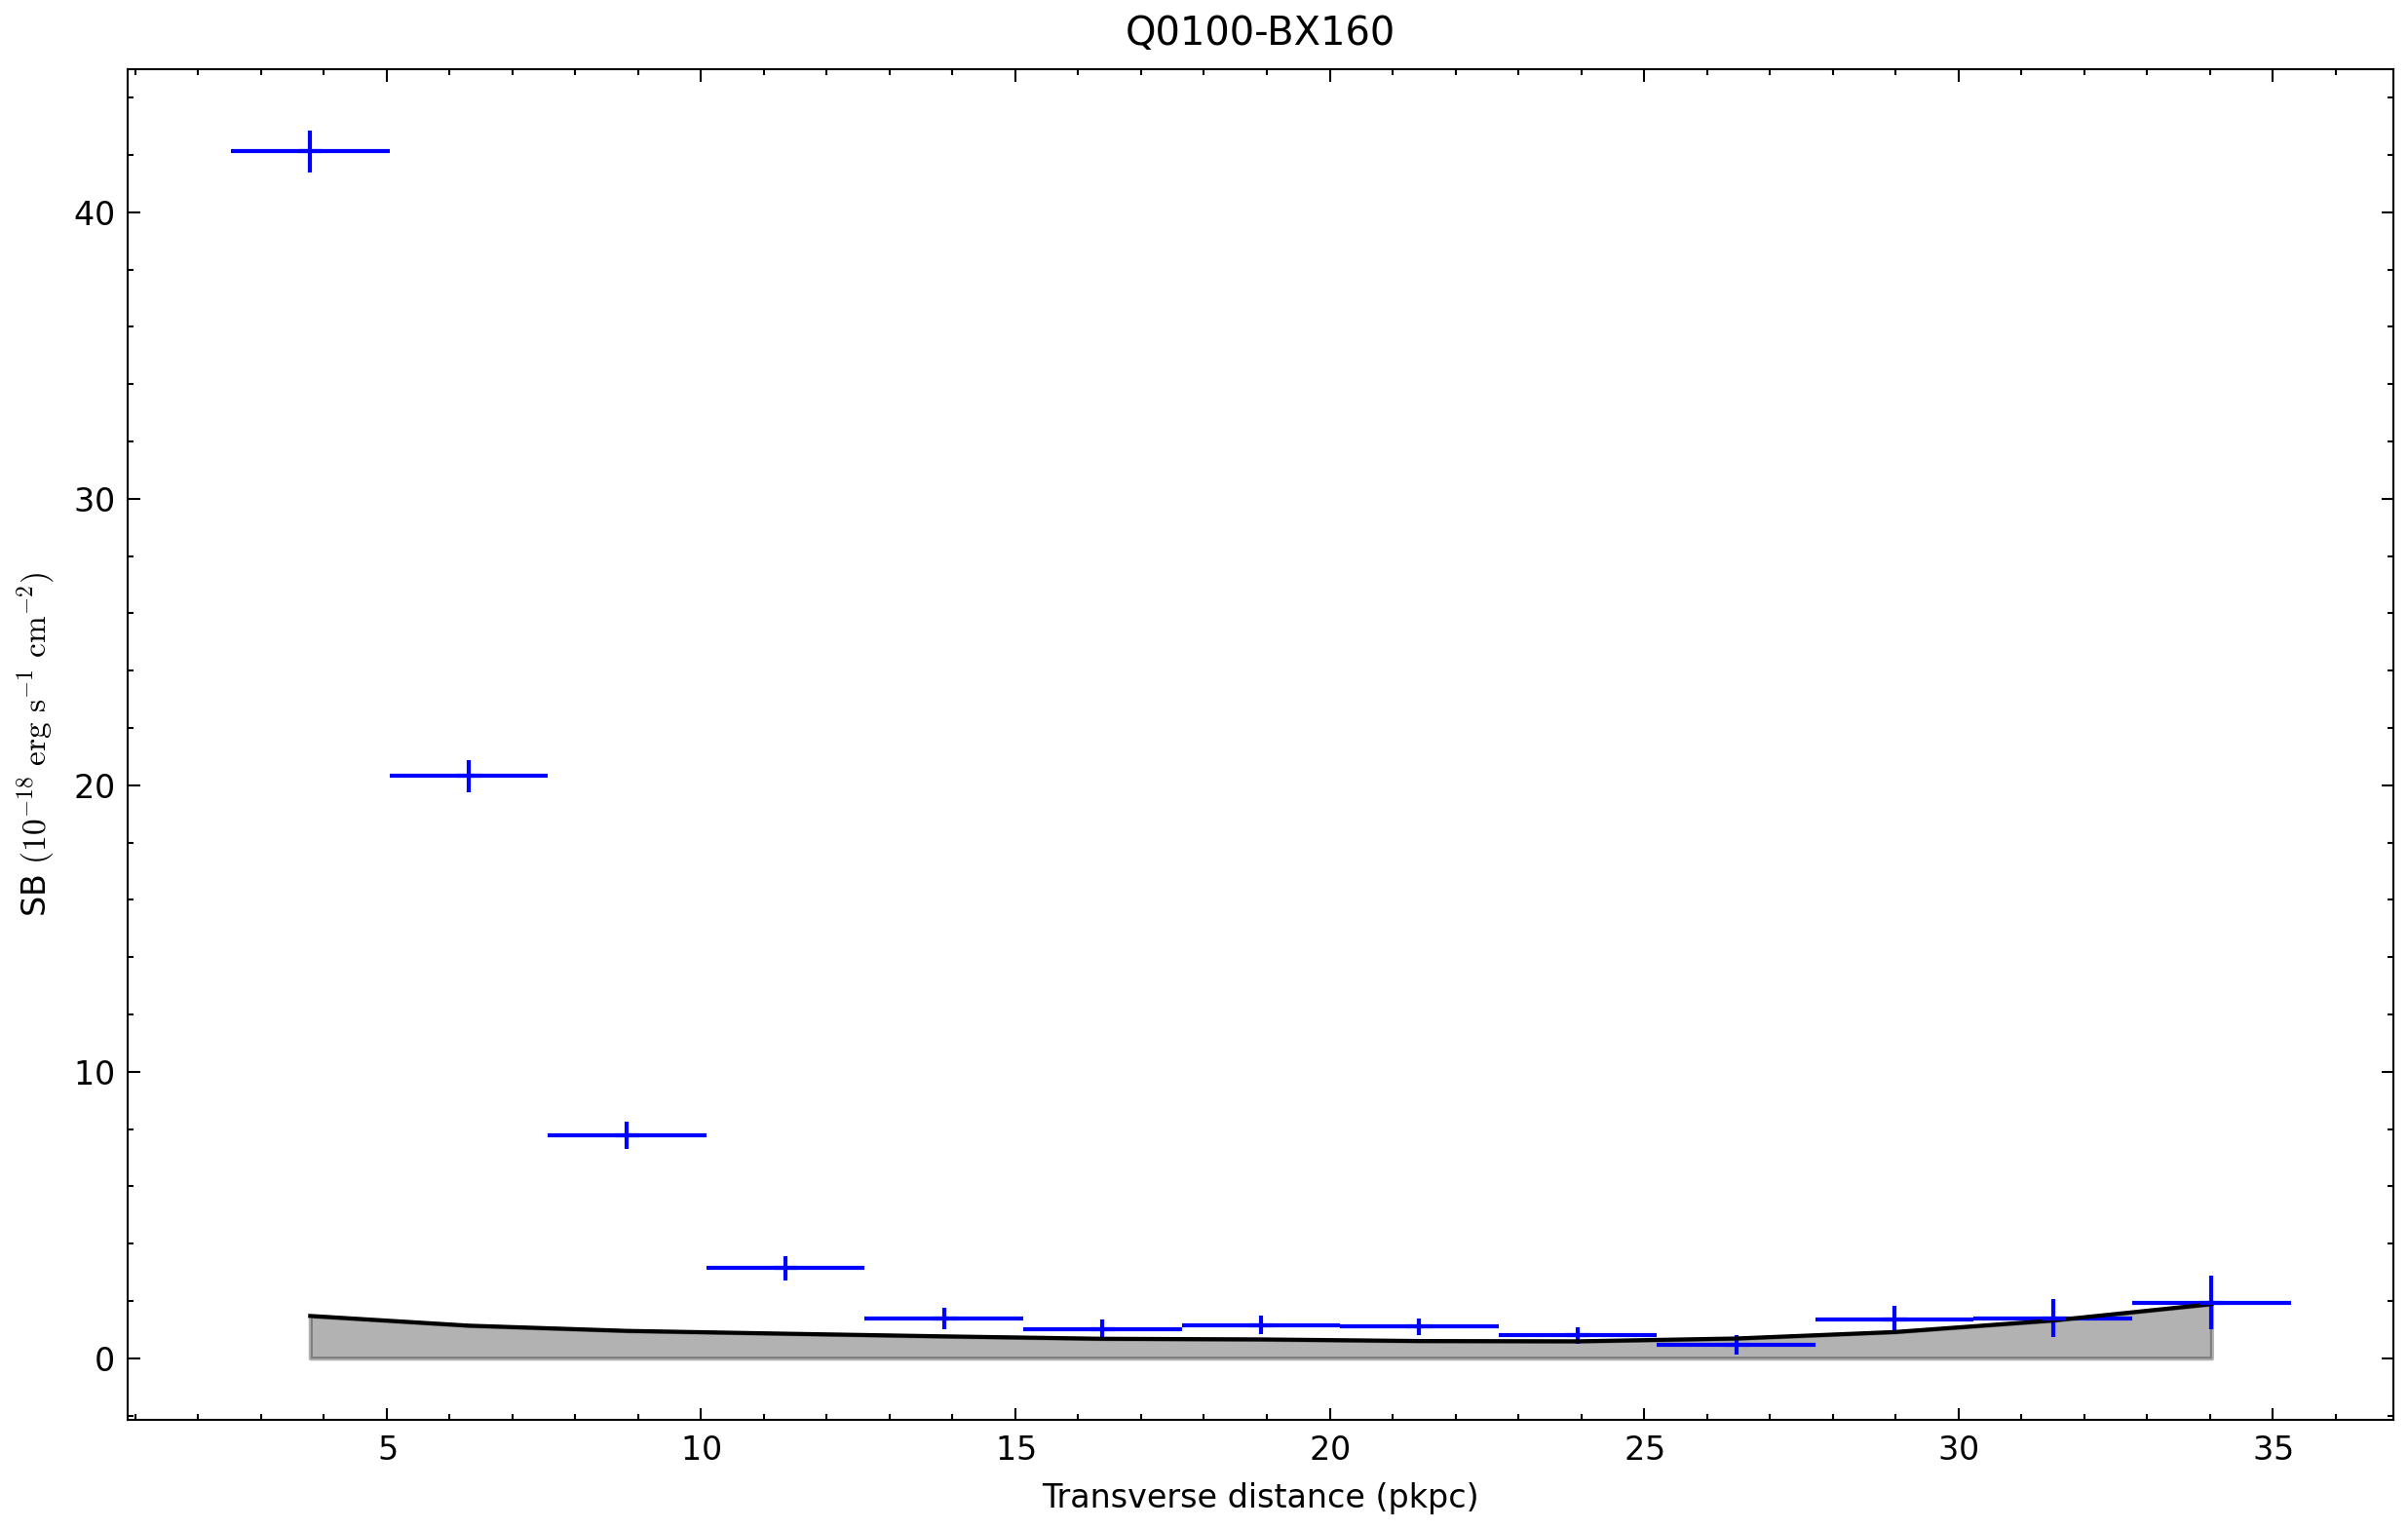

In [266]:
fig, ax = plt.subplots(figsize=(10,6),dpi=300)

ax.errorbar(rbin[:-1]*kpc_per_arcsec+rx/2,100*np.array(annulus_value[sourcename][0]),xerr=rx/2,yerr=100*np.array(annulus_value[sourcename][1])
            ,fmt="_",
        label="(Obs-Mod)/Obs",
        color="b",
        capsize=0.0,
        ls="None",
        lw=1)
ax.plot(rbin[:-1]*kpc_per_arcsec+rx/2,100*np.array(annulus_value[sourcename][1])*2,color="k")

ax.fill_between(rbin[:-1]*kpc_per_arcsec+rx/2,0,100*np.array(annulus_value[sourcename][1])*2,color="k",alpha=0.3)

#x_fit = np.linspace(3, 20, 100)
#y_fit=fitted_model(x_fit)
#ax.plot(x_fit,y_fit,"g")

ax.set_title("{}-{}".format(field,sourcename))
#ax.set_yscale("log")
ax.set_xlabel("Transverse distance (pkpc)")
ax.set_ylabel(r"SB $\rm (10^{-18}~erg~s^{-1}~cm^{-2})$")
#fig.savefig(KBSSpath+"/"+field+"/"+sourcename+"/kcwi_oned/SB_profile.pdf")

In [269]:
100*np.array(annulus_value[sourcename][0])

array([42.11899788, 20.3189102 ,  7.77915837,  3.14462739,  1.38252179,
        1.00454077,  1.1575351 ,  1.10231811,  0.79644328,  0.46233536,
        1.36576262,  1.39187972,  1.94364115,         nan,         nan,
               nan,         nan,         nan,         nan])

In [369]:
Planck18.kpc_proper_per_arcmin(redshift).value/60

8.40201829169133

In [267]:
Lya_3arc
#mstar_1

{'BX160': [1.3077311651442813, 0.03562199649737274]}

In [385]:
from astropy.coordinates import SkyCoord
import astropy.units as u

# RA and DEC values
coords = [
    (339.87526600, 11.78978400),
    (356.50886000, 12.80739000),
    (356.60088000, 12.80236000),
    (17.00674000, 16.56680000),
    (32.43984000, -0.13071000),
    (44.74153600, 0.21285300)
]

# Convert and format RA and DEC
converted_coords = []
for ra, dec in coords:
    c = SkyCoord(ra=ra*u.degree, dec=dec*u.degree)
    ra_hms = c.ra.to_string(unit=u.hour, sep=':', pad=True)
    dec_dms = c.dec.to_string(unit=u.degree, sep=':', pad=True, alwayssign=True)
    converted_coords.append((ra_hms, dec_dms))

converted_coords

[('22:39:30.06384', '+11:47:23.2224'),
 ('23:46:02.1264', '+12:48:26.604'),
 ('23:46:24.2112', '+12:48:08.496'),
 ('01:08:01.6176', '+16:34:00.48'),
 ('02:09:45.5616', '-00:07:50.556'),
 ('02:58:57.96864', '+00:12:46.2708')]

In [533]:
id_1

Q1549-MD10
Q1549-MD17
Q1549-BX101
Q0100-BX164
Q0100-BX160
Q0821-RK5
Q2343-BX415
Q2343-FSzP1170
Q2343-Q2343


In [288]:
import pandas as pd

#col_widths = [12, 5, 10, 10, 10, 18, 12]  # Example widths, adjust as necessary

# Read the data
sedfitted = pd.read_csv("/disk/bifrost/yuanze/KBSS/sedfit_master/summary_csf_all_agegt50.dat", delim_whitespace=True, header=None)
sedfitted.columns = ['ID', 'tau', 'EBV', 'age', 'SFR', 'Mstar', 'chi2nu']
#sedfitted=sedfitted.set_index('ID')
chen2021 = pd.read_csv("/disk/bifrost/yuanze/KBSS/KCWI/sfgs.kcwi", delim_whitespace=True, header=None)
chen2021.columns = ['ID','Lyatot','Lyatoterr']




In [289]:
filtered_sedfit = sedfitted[sedfitted['ID'].isin(chen2021['ID'].to_list())]

In [290]:
#Mstar=filtered_sedfit['Mstar']
merged_set = pd.merge(filtered_sedfit, chen2021, on='ID', how='inner')

In [291]:

allSFGfield=[]
for loc, row in merged_set.iterrows():
    fieldnow=re.findall(r"(.*)-",row["ID"])[0]
    merged_set.at[loc,"field"]=fieldnow
    if fieldnow in allSFGfield:
        continue
    else:
        allSFGfield.append(fieldnow)

In [292]:
for fieldnow in allSFGfield:
    inphot = ascii.read(photpath+"/inphot/"+fieldnow.lower()+"_inphot_refit.dat")
    filterpath = photpath+"/filters_standard."+fieldnow.lower()+".v2"
    all_filters = ascii.read(filterpath)['col1']
    filtind = np.ravel(np.where(all_filters=="Rs_lris"))[0]
    for loc,row in merged_set[merged_set["field"]==fieldnow].iterrows():
        photentry = inphot[inphot['col1']==row["ID"]]
        MRs = photentry["col{}".format(2+2*filtind)][0]
        MRserr = photentry["col{}".format(3+2*filtind)][0]
        merged_set.at[loc,"MRs"]=MRs
        merged_set.at[loc,"MRserr"]=MRserr
        if row["Lyatot"]<2*row["Lyatoterr"]:
            merged_set.at[loc,"Lyatot"]=row["Lyatoterr"]*1

24.44

MD10
MD17


(-0.1, 10.0)

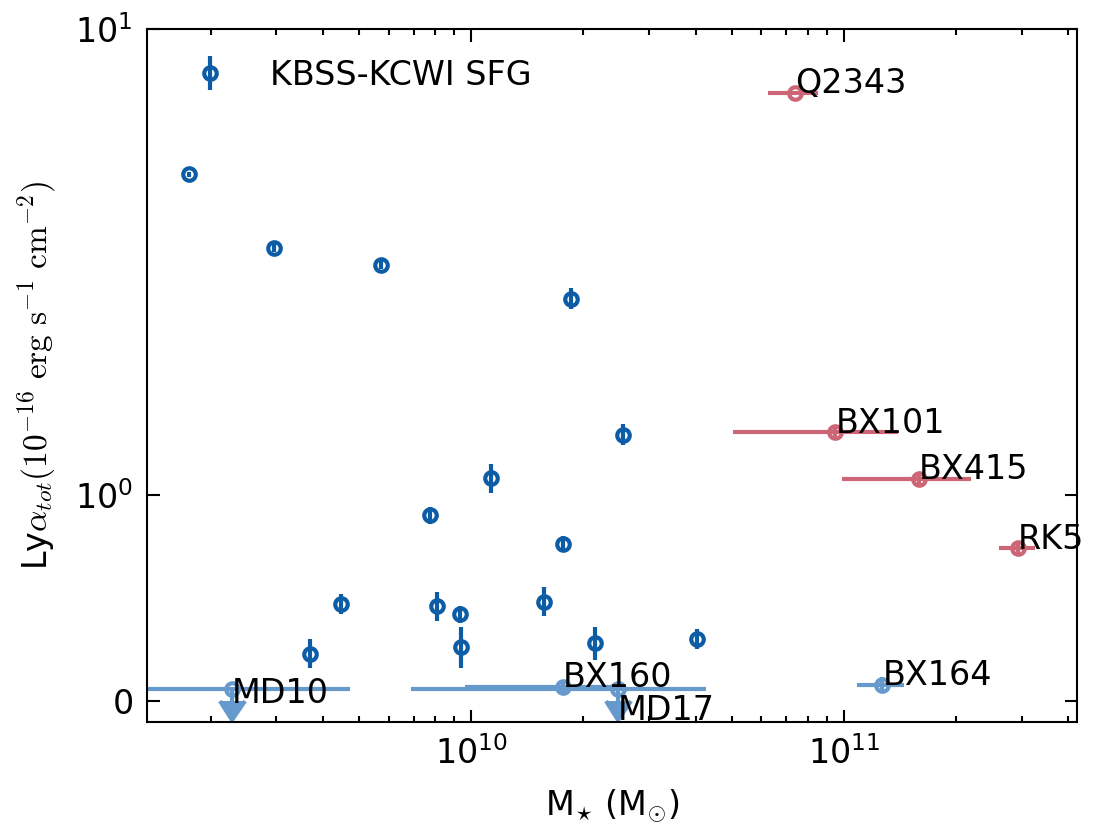

In [155]:
plt.style.use(["science",'no-latex'])
plt.rcParams.update({
    "font.family": "dejavu sans",   # specify font family here
    "font.serif": ["Times"],  # specify font here
    "font.size":8,
"legend.fancybox":True})

fig,axs=plt.subplots(figsize=(4,3),dpi=300)
filter=merged_set["SFR"]<20
axs.errorbar(merged_set["Mstar"][filter],merged_set["Lyatot"][filter]*0.1,yerr=merged_set["Lyatoterr"][filter]*0.1,fmt="o",mfc="None",ms=3,label="KBSS-KCWI SFG")

metrics=Lya_3arc
metrics2=mstar_1
positive_mask=metrics
for ind,id in enumerate(filtered_id_1):
    sourcename=re.findall(r"-(.*)",id)[0]
    if sourcename in Lya_3arc.keys():
        sentry=qsos[qsos["Name"]==sourcename]
        if sentry["ext"].value[0]=="True":
            axs.errorbar(metrics2[0][ind],metrics[sourcename][0],xerr=metrics2[1][ind],yerr=metrics[sourcename][1],fmt="o",mfc="None",ms=3,color=colorlst[0])
        elif sentry["ext"].value[0]=="False" and metrics[sourcename][0] > metrics[sourcename][1]:
            axs.errorbar(metrics2[0][ind],metrics[sourcename][0],xerr=metrics2[1][ind],yerr=metrics[sourcename][1],fmt="o",mfc="None",ms=3,color=colorlst[2])
        else:
            print(sourcename)
            axs.errorbar(metrics2[0][ind],metrics[sourcename][1],uplims=True,xerr=metrics2[1][ind],yerr=metrics[sourcename][1],fmt="o",mfc="None",ms=3,color=colorlst[2])
        axs.text(metrics2[0][ind],metrics[sourcename][0],sourcename)#transform=axs.transAxes,verticalalignment='top',horizontalalignment='right',fontsize=7)
        
axs.legend()
axs.set_xlabel(r"M$_{\star}$ (M$_{\odot}$)")
axs.set_ylabel(r"Ly$\alpha_{tot} (10^{-16}~\rm erg~s^{-1}~cm^{-2})$")
axs.set_xscale("log")
axs.set_yscale("symlog")
axs.set_ylim([-0.1,10])

MD10
MD17


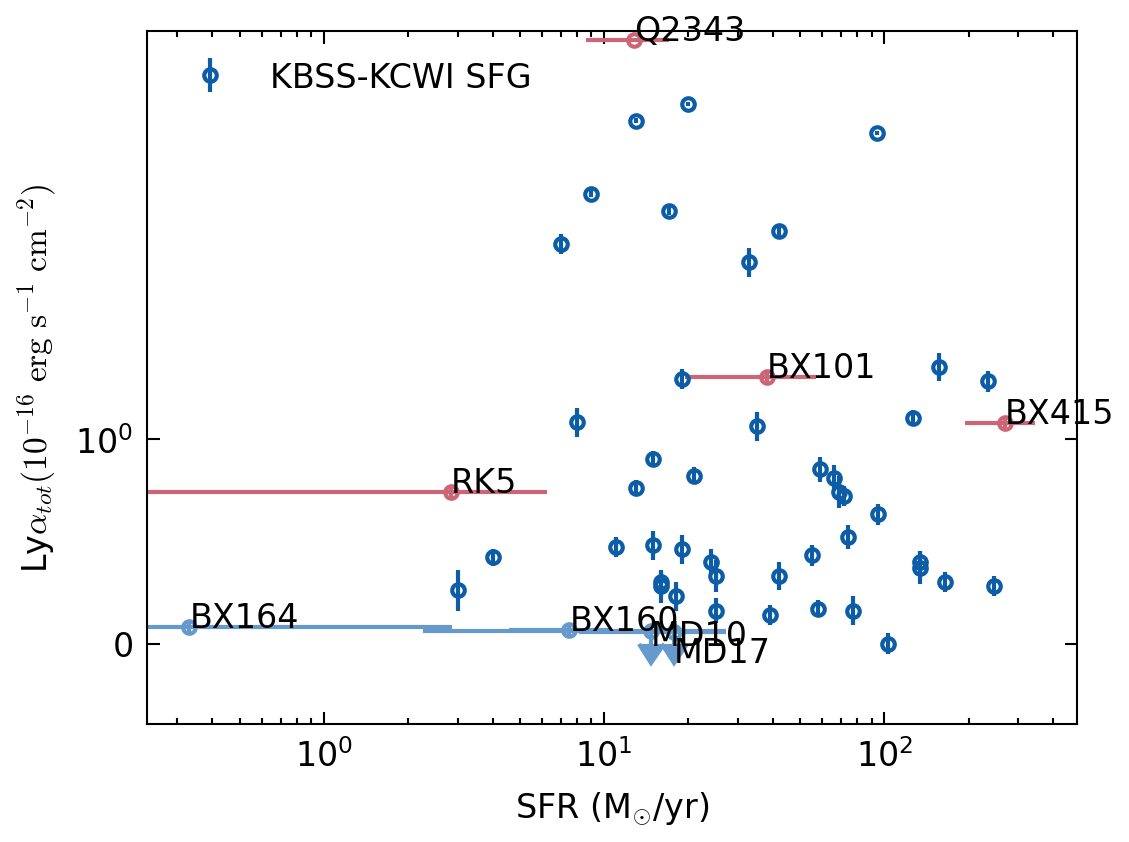

In [156]:
plt.style.use(["science",'no-latex'])
plt.rcParams.update({
    "font.family": "dejavu sans",   # specify font family here
    "font.serif": ["Times"],  # specify font here
    "font.size":8,
"legend.fancybox":True})

fig,axs=plt.subplots(figsize=(4,3),dpi=300)
axs.errorbar(merged_set["SFR"],merged_set["Lyatot"]*0.1,yerr=merged_set["Lyatoterr"]*0.1,fmt="o",mfc="None",ms=3,label="KBSS-KCWI SFG")

metrics=Lya_3arc
metrics2=sfr_1

for ind,id in enumerate(filtered_id_1):
    sourcename=re.findall(r"-(.*)",id)[0]
    if sourcename in Lya_3arc.keys():
        sentry=qsos[qsos["Name"]==sourcename]
        if sentry["ext"].value[0]=="True":
            axs.errorbar(metrics2[0][ind],metrics[sourcename][0],xerr=metrics2[1][ind],yerr=metrics[sourcename][1],fmt="o",mfc="None",ms=3,color=colorlst[0])
        elif sentry["ext"].value[0]=="False" and metrics[sourcename][0] > metrics[sourcename][1]:
            axs.errorbar(metrics2[0][ind],metrics[sourcename][0],xerr=metrics2[1][ind],yerr=metrics[sourcename][1],fmt="o",mfc="None",ms=3,color=colorlst[2])
        else:
            print(sourcename)
            axs.errorbar(metrics2[0][ind],metrics[sourcename][1],uplims=True,xerr=metrics2[1][ind],yerr=metrics[sourcename][1],fmt="o",mfc="None",ms=3,color=colorlst[2])
        axs.text(metrics2[0][ind],metrics[sourcename][0],sourcename)#transform=axs.transAxes,verticalalignment='top',horizontalalignment='right',fontsize=7)
        
axs.legend()
axs.set_xlabel(r"SFR (M$_{\odot}$/yr)")
axs.set_ylabel(r"Ly$\alpha_{tot} (10^{-16}~\rm erg~s^{-1}~cm^{-2})$")
axs.set_xscale("log")
axs.set_yscale("symlog")

MD10
MD17


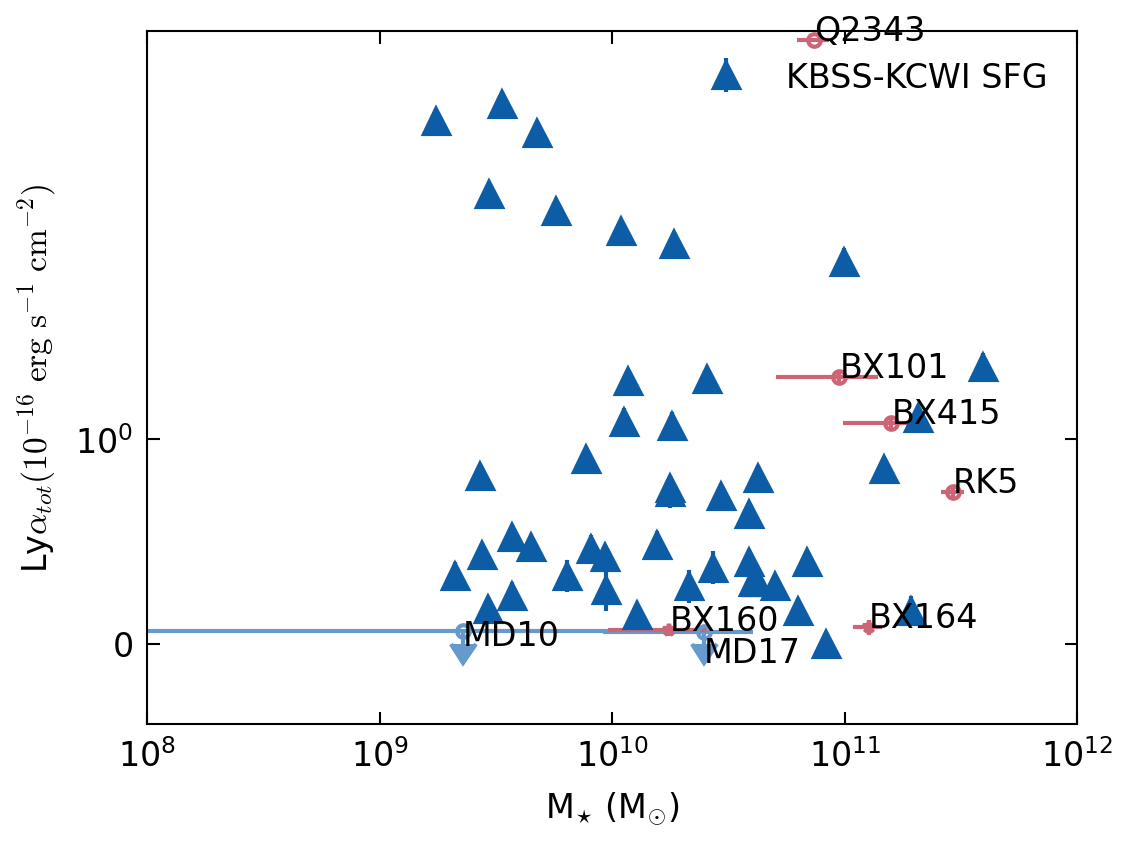

In [160]:
plt.style.use(["science",'no-latex'])
plt.rcParams.update({
    "font.family": "dejavu sans",   # specify font family here
    "font.serif": ["Times"],  # specify font here
    "font.size":8,
"legend.fancybox":True})

fig,axs=plt.subplots(figsize=(4,3),dpi=300)
axs.errorbar(merged_set["Mstar"],merged_set["Lyatot"]*0.1,yerr=merged_set["Lyatoterr"]*0.1,fmt="^",label="KBSS-KCWI SFG")

metrics=Lya_3arc
metrics2=mstar_2
metrics1=mstar_1
for ind,id in enumerate(id_2):
    sourcename=re.findall(r"-(.*)",id)[0]
    if sourcename in Lya_3arc.keys():
        sentry=qsos[qsos["Name"]==sourcename]
        #if sentry["ext"].value[0]=="False":
        axs.errorbar(metrics2[0][ind],metrics[sourcename][0],xerr=metrics2[1][ind],yerr=metrics[sourcename][1],fmt="*",color=colorlst[2])
        #else:
        #    axs.errorbar(metrics2[0][ind],metrics[sourcename][0],xerr=metrics2[1][ind],yerr=metrics[sourcename][1],fmt="*",color=colorlst[0])
        axs.text(metrics2[0][ind],metrics[sourcename][0],sourcename)#transform=axs.transAxes,verticalalignment='top',horizontalalignment='right',fontsize=7)


for ind,id in enumerate(filtered_id_1):
    sourcename=re.findall(r"-(.*)",id)[0]
    if sourcename in Lya_3arc.keys():
        sentry=qsos[qsos["Name"]==sourcename]
        if sentry["ext"].value[0]=="True":
            axs.errorbar(metrics1[0][ind],metrics[sourcename][0],xerr=metrics1[1][ind],yerr=metrics[sourcename][1],fmt="o",mfc="None",ms=3,color=colorlst[0])
        elif sentry["ext"].value[0]=="False" and metrics[sourcename][0] > metrics[sourcename][1]:
            axs.errorbar(metrics1[0][ind],metrics[sourcename][0],xerr=metrics1[1][ind],yerr=metrics[sourcename][1],fmt="*",mfc="None",ms=3,color=colorlst[0])
        else:
            print(sourcename)
            axs.errorbar(metrics1[0][ind],metrics[sourcename][1],uplims=True,xerr=metrics2[1][ind],yerr=metrics[sourcename][1],fmt="o",mfc="None",ms=3,color=colorlst[2])
        axs.text(metrics1[0][ind],metrics[sourcename][0],sourcename)#transform=axs.transAxes,verticalalignment='top',horizontalalignment='right',fontsize=7)


axs.legend()
axs.set_xlabel(r"M$_{\star}$ (M$_{\odot}$)")
axs.set_ylabel(r"Ly$\alpha_{tot} (10^{-16}~\rm erg~s^{-1}~cm^{-2})$")
#axs.set_xscale
axs.set_xlim([1e8,1e12])
axs.set_xscale("symlog")
axs.set_yscale("symlog")

MD10
MD17


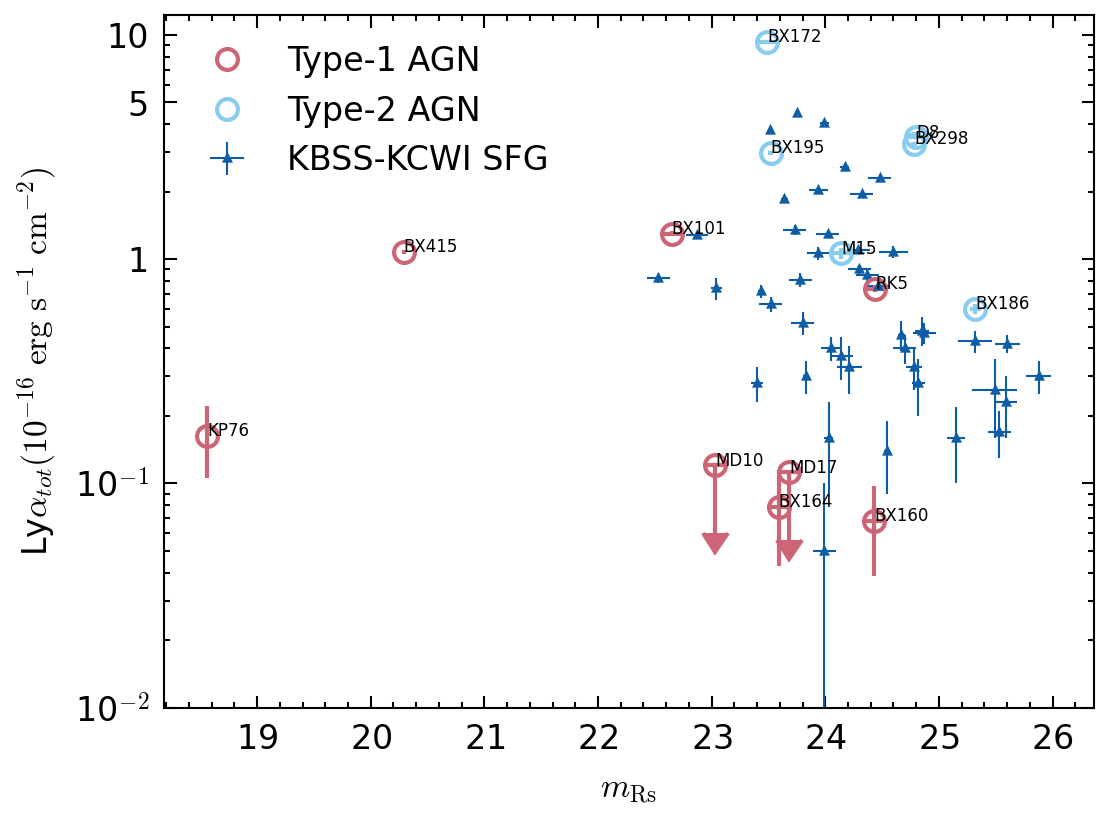

In [399]:
plt.style.use(["science",'no-latex'])
plt.rcParams.update({
    "font.family": "dejavu sans",   # specify font family here
    "font.serif": ["Times"],  # specify font here
    "font.size":8,
"legend.fancybox":True})
Pub_filt=["sdss.up","sdss.gp","sdss.rp","sdss.ip","sdss.zp","WISE1","WISE2","WISE3","WISE4","2mass.J","2mass.H","2mass.Ks"]

fig,axs=plt.subplots(figsize=(4,3),dpi=300)

axs.errorbar(merged_set["MRs"],merged_set["Lyatot"]*0.1,xerr=merged_set["MRserr"],ms=1,lw=0.5,yerr=merged_set["Lyatoterr"]*0.1,fmt="^",label="KBSS-KCWI SFG")

metrics=Lya_3arc
metrics2=mstar_2
metrics1=mstar_1
ms=5
photpath="/disk/bifrost/yuanze/KBSS/sedfit_master"
tfs=4
for ind,id in enumerate(id_2):
    sourcename=re.findall(r"-(.*)",id)[0]
    if sourcename in Lya_3arc.keys():
        
        sentry=qsos[qsos["Name"]==sourcename]
        #if sentry["ext"].value[0]=="False":
        fieldnow = sentry["Field"][0]
        inphot = ascii.read(photpath+"/inphot/"+fieldnow.lower()+"_inphot_refit.dat")
        filterpath = photpath+"/filters_standard."+fieldnow.lower()+".v2"
        all_filters = ascii.read(filterpath)['col1']
        filtind = np.ravel(np.where(all_filters=="Rs_lris"))[0]
        photentry = inphot[inphot['col1']==fieldnow+"-"+sourcename]
        MRs = photentry["col{}".format(2+2*filtind)][0]
        MRserr = photentry["col{}".format(3+2*filtind)][0]

        
        axs.errorbar(MRs,metrics[sourcename][0],xerr=MRserr,yerr=metrics[sourcename][1],mfc="None",fmt="o",ms=ms,color=colorlst[1])
        #else:
        #    axs.errorbar(metrics2[0][ind],metrics[sourcename][0],xerr=metrics2[1][ind],yerr=metrics[sourcename][1],fmt="*",color=colorlst[0])
        axs.text(MRs,metrics[sourcename][0],sourcename,fontsize=tfs)#transform=axs.transAxes,verticalalignment='top',horizontalalignment='right',fontsize=7)
newid1=filtered_id_1.insert(-1,"Q1623-KP76")
for ind,id in enumerate(newid1):
    sourcename=re.findall(r"-(.*)",id)[0]
    if sourcename in Lya_3arc.keys():
        
        sentry=qsos[qsos["Name"]==sourcename]
        #if sentry["ext"].value[0]=="False":
        fieldnow = sentry["Field"][0]
        if sourcename != "KP76":
            inphot = ascii.read(photpath+"/inphot/"+fieldnow.lower()+"_inphot_refit.dat")
            filterpath = photpath+"/filters_standard."+fieldnow.lower()+".v2"
            all_filters = ascii.read(filterpath)['col1']
            filtind = np.ravel(np.where(all_filters=="Rs_lris"))[0]

        else:
            all_filters = Pub_filt
            inphot = ascii.read(photpath+"/inphot/qso_final.dat")
  #          filtind = np.ravel(np.where(all_filters=="sdss.rp"))[0]
            filtind=2
        photentry = inphot[inphot['col1']==fieldnow+"-"+sourcename]
        MRs = photentry["col{}".format(2+2*filtind)][0]
        MRserr = photentry["col{}".format(3+2*filtind)][0]

        if sentry["ext"].value[0]=="True":
            axs.errorbar(MRs,metrics[sourcename][0],xerr=MRserr,yerr=metrics[sourcename][1],fmt="o",mfc="None",ms=ms,color=colorlst[0])
            axs.text(MRs,metrics[sourcename][0],sourcename,fontsize=tfs)#transform=axs.transAxes,verticalalignment='top',horizontalalignment='right',fontsize=7)
        elif sentry["ext"].value[0]=="False" and metrics[sourcename][0] > 2*metrics[sourcename][1]:
            axs.errorbar(MRs,metrics[sourcename][0],xerr=MRserr,yerr=metrics[sourcename][1],fmt="o",mfc="None",ms=ms,color=colorlst[0])
            axs.text(MRs,metrics[sourcename][0],sourcename,fontsize=tfs)#transform=axs.transAxes,verticalalignment='top',horizontalalignment='right',fontsize=7)
        else:
            print(sourcename)
            axs.errorbar(MRs,metrics[sourcename][1]*2,uplims=True,xerr=MRserr,yerr=metrics[sourcename][1],fmt="o",mfc="None",ms=ms,color=colorlst[0])
            axs.text(MRs,metrics[sourcename][1]*2,sourcename,fontsize=tfs)#transform=axs.transAxes,verticalalignment='top',horizontalalignment='right',fontsize=7)

from matplotlib.lines import Line2D
proxy_line1 = plt.plot([], [], marker="o",lw=0, mfc="None",ms=ms,color=colorlst[0], label="Type-1 AGN")
proxy_line2 = plt.plot([], [], marker="o",lw=0, mfc="None",ms=ms,color=colorlst[1], label="Type-2 AGN")
axs.legend()
axs.set_xlabel(r"$m_{\rm Rs}$")
axs.set_ylabel(r"Ly$\alpha_{tot} (10^{-16}~\rm erg~s^{-1}~cm^{-2})$")
#axs.set_xscale
#axs.set_xlim([22,26])

axs.set_yscale("log")

#axs.set_ylim([-1,10])
axs.set_yticks([1e-2,1e-1,1,5,10])
axs.set_yticklabels([r"10$^{-2}$",r"10$^{-1}$","1","5","10"])



#axs.set_xscale("symlog")
fig.savefig(KBSSpath+"/fig/Lya_MRs.pdf")

In [205]:
photpath="/disk/bifrost/yuanze/KBSS/sedfit_master"

In [198]:
photpath+"/inphot/"+fieldnow.lower()+"_inphot_refit.dat"

'/disk/bifrost/yuanze/KBSS/sedfit_master/inphot/q0100_inphot_refit.dat'

In [332]:
inphot['col1']

Q1623-BM209
Q1623-BX1000
Q1623-BX109
Q1623-BX113
Q1623-BX118
Q1623-BX124
Q1623-BX129
Q1623-BX138
Q1623-BX140
Q1623-BX144
Q1623-BX145


In [278]:
metrics[sourcename][0]

1.0757585906981562

In [188]:
photentry

col1,col2,col3,col4,col5,col6,col7,col8,col9,col10,col11,col12,col13,col14,col15,col16,col17,col18
str14,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
Q0821-D8,27.8,0.53,25.17,0.17,24.8,0.1,23.72,0.1,22.64,0.1,22.11,0.13,9999.0,9999.0,9999.0,9999.0,2.568


In [358]:
LD=Planck18.luminosity_distance(2.5)
mAB=22.5
MAB=mAB-5*np.log10(LD.to(u.pc).value-1)
print(MAB)

-29.09914455267895


## Analysis for Hyper Lunminous AGN

In [39]:
zref={}
lines={'NV':[1238.821,1242.804],'CIII]':[1909], 'CIV':[1548.20,1550.77],"OI":[1304,1306] ,"SiIII":[1206.5],"SiIV":[1393.76,1402.77],"SiII":[1260.42],"CII":[1334.53],"OVI":[1031,1037],"HeII":[1640],"Lya":[1216]}

In [23]:
diffield=[]#["1623"]
# Q2343+12     Q2343  356.618  12.816   74.40   31.70    0.032  2.515     2.5730  0.0001 True    18.18    17.43   17.11   16.98   16.72  -25.9584
field = "0449"
psname = "KP77"
radius=6
qsos_bright = ascii.read(KBSSpath+"/KCWI/qsos_bright_updated.list",format="ipac")
id_HL = qsos_bright["Name"]
#print(id_HL)
#print(qsos_bright["Field"])

KBSSpath="/disk/bifrost/yuanze/KBSS"

#if field=="1623":
#    sentry=qsos_bright[(qsos_bright["Field"]=="Q"+field) & (qsos_bright["Name"]=="Q"+field+"-"+psname)]
#    ssentry=qsos[qsos["Name"]==psname]
#    csname=ssentry["Cube"][0]
#    dapath=KBSSpath+"/Q"+field+"/"+csname+"/kcwi_oned"
#    subdapath=KBSSpath+"/Q"+field+"/"+psname+"/kcwi_oned"
#elif field=="2343":
#    sentry=qsos_bright[qsos_bright["Field"]=="Q"+field]
#    ssentry=qsos[qsos["Name"]==psname]
#    csname=ssentry["Cube"][0]
#    dapath=KBSSpath+"/Q"+field+"/"+csname+"/kcwi_oned"
#    subdapath=KBSSpath+"/Q"+field+"/"+psname+"/kcwi_oned"
#else:
sentry=qsos_bright[qsos_bright["Field"]=="Q"+field]
subdapath=KBSSpath+"/Q"+field+"/QSO"
maskfn=subdapath+"/q{}-{}_icubes_wcs_{}.PSFSub.mask.fits".format(field.lower(),"qso",int(radius/0.3))
#cubename=sentry["Field"].value[0]
#Type=sentry["Type"][0]
sname=sentry["Name"][0]
redshift=sentry["z_sys"].value[0]
RA = sentry["RA"].value[0]
DEC = sentry["Dec"].value[0]
xpix = sentry["x"].value[0]
ypix = sentry["y"].value[0]

sc = SkyCoord(ra=RA, dec=DEC, unit='deg',frame="icrs", equinox='J2000')
#s_coord=wcsinfo.world_to_pixel(sc)
s_coord=np.array([xpix,ypix])
print(sname)

Q0449-1645


In [91]:
linename="Lya"
if field in diffield:
    varfile = dapath+"/q{}-{}_vcubes.fits".format(field,csname)
    Subfile = subdapath+"/q{}-{}_icubes_wcs.PSFCONTSub.fits".format(field,psname)
    cubefile = dapath+"/q{}-{}_icubes_wcs.fits".format(field,csname)
else:
    varfile = subdapath+"/q{}-qso_vcubes.fits".format(field)
    Subfile = subdapath+"/q{}-qso_icubes_wcs_20.PSFCONTSub.fits".format(field)
    cubefile = subdapath+"/q{}-qso_icubes_wcs.fits".format(field)


Org_cube = SpectralCube.read(cubefile)
Var_cube = SpectralCube.read(varfile)
Sub_cube = SpectralCube.read(Subfile)

wcsinfo=Sub_cube.wcs.celestial

specwidth=1
Lya_cube = Sub_cube.with_spectral_unit(u.km/u.s, velocity_convention='relativistic', rest_value=1215.67*(1+redshift) * u.AA)
Lya_subcube = Lya_cube.spectral_slab(-1000*u.km/u.s,200*u.km/u.s)
Lya_mflux = (Lya_subcube*specwidth).sum(axis=0,how='cube')

if field in diffield:
    Checkcube=fits.open(subdapath+"/q{}-{}_icubes_wcs.PSFCONTSub.Objects_Id_{}.fits".format(field.lower(),psname,linename))
    objcat=np.genfromtxt(subdapath+"/q{}-{}_{}.cat".format(field.lower(),psname,linename))
else:
    Checkcube=fits.open(subdapath+"/q{}-qso_icubes_wcs.PSFCONTSub.Objects_Id_{}.fits".format(field.lower(),linename))
    objcat=np.genfromtxt(subdapath+"/q{}-qso_{}.cat".format(field.lower(),linename))
mask_3d=Checkcube[0].data

# wavelength range for the extraction cube
lw=Checkcube[0].header["CRVAL3"]
hw=Checkcube[0].header["CRVAL3"]+(mask_3d.shape[0]-1)*Checkcube[0].header["CD3_3"]

#Cut-off: geometric center of the detected object must be within N pixels of the PSF center (~4.5 arcsec)
Npix=15

if len(objcat.shape)>1:
    obj_coord=objcat[:,2:4]
    obj_num=objcat[:,0]
    dis=np.linalg.norm(obj_coord - np.array(s_coord),axis=1)
    print("distance from PSF to objects (pixels):")
    print(dis)
    sel_num=obj_num[dis<Npix]
    print("selected objects: obj_num, N_Voxels")
    print(sel_num,objcat[:,1][dis<Npix])
else:
    sel_num=objcat[0]
    obj_coord=objcat[2:4]

#sel_num=np.array([4])
mask_3d_filtered=np.isin(mask_3d, sel_num.astype(int))

# remove pixels inside the r=2 pixels circular region
region_pix4 = CirclePixelRegion(center=PixCoord(x=s_coord[0],y=s_coord[1]),radius=2)
rmask=region_pix4.to_mask()
rmask2D_image = rmask.to_image(mask_3d_filtered.shape[1:])
expanded_rmask_image = np.repeat(rmask2D_image[np.newaxis, :, :], mask_3d_filtered.shape[0], axis=0)



contmask=fits.open(maskfn)[0].data
expanded_contmask_image = np.repeat(contmask[np.newaxis, :, :], mask_3d_filtered.shape[0], axis=0)


mask_3d_filtered=mask_3d_filtered & (~expanded_rmask_image.astype(bool)) & (~expanded_contmask_image.astype(bool))

subcube1=Sub_cube.spectral_slab(lw*u.AA,hw*u.AA)
subcube2=subcube1.unmasked_data[:].value



# Extract the spaxels that are marked as detection in CubEx
line_maskedcube = np.where(mask_3d_filtered.astype(bool), subcube2, 0)
line_mflux=np.nansum(line_maskedcube,axis=0)

# Constructing 2D-mask inorder to extract the 1-D spectrum in the Lya Nebulosity 
mask_2d_filtered=np.nansum(mask_3d_filtered,axis=0)
expanded_mask = np.repeat(mask_2d_filtered[np.newaxis, :, :], Sub_cube.shape[0], axis=0)

# 2D mask criteria: line flux larger than .125 * 1e-16
masked_2d_peak = line_mflux < 0.5
newmask=masked_2d_peak & mask_2d_filtered.astype(bool)
#newmask[int(ypix)+1:,:]=False
#newmask[:,int(xpix):]=False
expanded_mask_peak = np.repeat(newmask[np.newaxis, :, :], Sub_cube.shape[0], axis=0)

distance from PSF to objects (pixels):
[ 2.1881956   3.81811472  1.21276543 29.10427116  5.9161643 ]
selected objects: obj_num, N_Voxels
[ 3.  6.  8. 15.] [  58.   46. 1674.  110.]


In [92]:
# reconstruct a new cube for velocity dispersion, velocity shift calculations.
#mask = mask_3d_filtered.astype(bool)
new_cube = SpectralCube(data=line_maskedcube, wcs=subcube1.wcs)

line_shift_lambda=new_cube.moment(order=1)

line_widthsigma=new_cube.linewidth_fwhm()

line_w_mean=np.mean(lines[linename])
line_shift_velocity=(line_shift_lambda.to(u.AA).value/(1+redshift)-line_w_mean)/line_w_mean*constants.c.to(u.km/u.s).value
line_widthsigma_velocity=line_widthsigma.to(u.AA).value/line_w_mean*constants.c.to(u.km/u.s).value/(1+redshift)

/disk/bifrost/yuanze/anaconda3/envs/nmma/lib/python3.8/site-packages/spectral_cube/_moments.py:168: RuntimeWarning: invalid value encountered in divide
  return (np.nansum(data * pix_cen, axis=axis) /


In [93]:

#Plume_cube=Sub_cube.subcube_from_mask(expanded_mask.astype(bool))
Plume_cube=np.where(expanded_mask.astype(bool), Sub_cube.unmasked_data[:].value, 0)
#Plume_varcube=Var_cube.subcube_from_mask(expanded_mask.astype(bool))
Plume_varcube=np.where(expanded_mask.astype(bool), Var_cube.unmasked_data[:].value, 0)

Peak_cube=np.where(expanded_mask_peak, Sub_cube.unmasked_data[:].value, 0)
Peak_varcube=np.where(expanded_mask_peak, Var_cube.unmasked_data[:].value, 0)
#Peak_varcube=Var_cube.subcube_from_mask(expanded_mask_peak)

Full_cube=np.where(expanded_mask_peak, Org_cube.unmasked_data[:].value, 0)
pix_scale=wcsinfo.pixel_scale_matrix[1,1]*3600


var1=np.nansum(Peak_varcube,axis=(1,2))*pix_scale**2
spec1=np.nansum(Peak_cube,axis=(1,2))*pix_scale**2
#var=Plume_varcube.sum(axis=(1,2)).value
var=np.nansum(Plume_varcube,axis=(1,2))*pix_scale**2
spec=np.nansum(Plume_cube,axis=(1,2))*pix_scale**2
#spec=Plume_cube.sum(axis=(1,2)).value

Org_spec=np.nansum(Full_cube,axis=(1,2))*pix_scale**2
#Full_cube.sum(axis=(1,2)).value
#Plume_HeII=Plume_cube.spectral_slab(1638*(1+redshift)*u.AA,1642*(1+redshift)*u.AA)
#Plume_CIV=Plume_cube.spectral_slab(1547*(1+redshift)*u.AA,1552*(1+redshift)*u.AA)

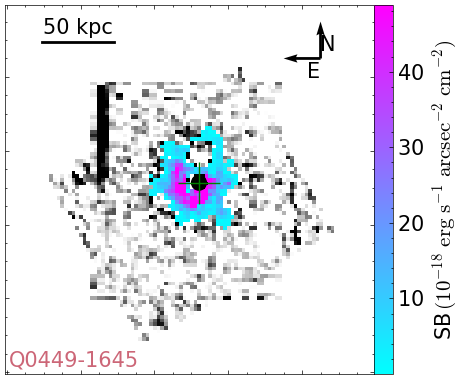

In [94]:
plt.style.use(["science",'no-latex'])
plt.rcParams.update({
    "font.family": "dejavu sans",   # specify font family here
    "font.serif": ["Times"],  # specify font here
    "font.size":15,
"legend.fancybox":True})
#

Lyau = r"SB$\,\rm (10^{-18}~erg~s^{-1}~arcsec^{-2}~cm^{-2})$"

_, med, std = sigma_clipped_stats(Lya_mflux.value*100)

#mask=Lya_mflux.value < std*0.07
#mask=Lya_mflux.value < 2.5*Lya_msig.value
#plotmom1=Lya_moment_1.copy()
#plotmom1[mask]=np.nan
# Integrated Lya image
#std=np.std(Lya_mflux.value)
cmap0 = plt.cm.binary
cmap0.set_bad(color='red') 
fig, ax, im1 = imshow_astro(Lya_mflux.value*100, figsize=(5,5),cblabel = Lyau, colorbar=False, vrange = (std*0.01, 10*std),cmap =cmap0)
#im1.set_visible(False)
# Lya velocity map
cmap = plt.cm.cool
cmap.set_bad(color='none') 
alpha=1
#vmin=-400
#vmax=400

#im = ax.contour(NB,levels=[1,3,5,8,10,20])
#im = ax.imshow(plotmom1.value,cmap=cmap,alpha=alpha,vmin=vmin,vmax=vmax)#,norm=norm)
masked_data = np.ma.masked_where(line_mflux == 0, line_mflux)
#masked_data = np.ma.masked_where(~newmask, line_mflux)
im = ax.imshow(masked_data*100,cmap=cmap,alpha=alpha,vmin=0.001*std,vmax=30*std)#,norm=norm)

colorlst=["#CC6677","#DDCC77","#6699CC"]
#cb = plt.colorbar(im, label = r"Velocity shift ($\rm km~s^{-1}$)", fraction =0.035)
from mpl_toolkits.axes_grid1 import make_axes_locatable
divider = make_axes_locatable(ax)
# Append axes to the right of ax, with 2% width and no padding
cax = divider.append_axes("right", size="5%", pad=0.0)
cb=fig.colorbar(im, cax=cax)
cb.set_label(Lyau)
        
#Source position
#psname=sourcename


#sc = SkyCoord(ra=RA, dec=DEC, unit='deg',frame="icrs", equinox='J2000')
#s_coord=wcsinfo.world_to_pixel(sc)

#s_coord3=wcsinfo.world_to_pixel(sc3)
#ax.plot(s_coord3[0],s_coord3[1],"+",c="r",ms=30,lw=0.1)


ax.plot(s_coord[0],s_coord[1],"+",c="g",ms=30,lw=0.1)

#ax.plot(45,39,"+",c="g",ms=30,lw=0.1)
#ax.plot(68.5,34.39,"+",c="g",ms=30,lw=0.1)
#ax.text(s_coord[0]-2,s_coord[1]-8
#        ,"{}".format(sname),color="red",verticalalignment='bottom',horizontalalignment='right')
ax.text(0.01,0.01
        ,"{}".format(sname),color=colorlst[0],verticalalignment='bottom',horizontalalignment='left',transform=ax.transAxes)

#ax.scatter(sc3.ra.value, sc3.dec.value, transform=ax.get_transform('world'), s=55, edgecolor='r', facecolor='none')
#ax.text(sc3.ra.value, sc3.dec.value,"{}-{}".format(cubename,tag3),color="red",transform=ax.get_transform('world'),verticalalignment='bottom',horizontalalignment='right',fontsize=15)



x0, y0 = 85, 85
arrow_length = 10

# North arrow goes upward in y-direction (positive Dec)
ax.quiver(x0, y0, 0, arrow_length, angles='xy', scale_units='xy', scale=1, color='black', label='North')
ax.text(x0+2, y0+1, 'N', color='black', ha='center', va='bottom')
# East arrow goes to the right in x-direction (negative RA)
ax.quiver(x0, y0, -arrow_length, 0, angles='xy', scale_units='xy', scale=1, color='black', label='East')
ax.text(x0-2, y0-1, 'E', color='black', ha='center', va='top')

#for r in rl:
#    r[0].plot(origin=(0, 0),ax=ax)
from regions import RectangleSkyRegion,CirclePixelRegion
from regions import PixCoord
#region_sky4 = RectangleSkyRegion(center=sc,
#                                 width=0.70000 * u.arcsec, height=7.01458 * u.arcsec,
#                                 angle=24.300 * u.deg)
region_pix4 = CirclePixelRegion(center=PixCoord(x=s_coord[0],y=s_coord[1]),radius=2)

#region_pix4 = region_sky4.to_pixel(wcsinfo)
region_pix4.plot(origin=(0, 0),ax=ax,color="k",fill=True)

#plt.imshow(rmask_image, cmap=plt.cm.viridis,
#           interpolation='nearest', origin='lower')

#-------------------Reference scale setting----------------#
dT = 50  # kpc distance
delta_theta_deg = dT/Planck18.kpc_proper_per_arcmin(redshift).value/60
x_lim = ax.get_xlim()
y_lim = ax.get_ylim()
start_x = x_lim[0] + 0.10 * (x_lim[1] - x_lim[0])
start_y = y_lim[0] + 0.10 * (y_lim[1] - y_lim[0])
start_coord = wcsinfo.pixel_to_world(start_x, start_y)
end_coord = wcsinfo.pixel_to_world(start_x + 1, start_y)  # arbitrary +1 in pixel to get RA difference for 1 pixel


delta_ra_per_pixel = start_coord.ra.degree - end_coord.ra.degree
length_in_pixels = delta_theta_deg / delta_ra_per_pixel

ax.plot([start_x, start_x + length_in_pixels], [start_y, start_y], color='black', lw=2)
ax.text(start_x + length_in_pixels / 2, start_y+1, '{} kpc'.format(dT), color='black', ha='center', va='bottom')

#ax.set_xlabel(r"$\Delta$arcsec")
#ax.set_ylabel(r"$\Delta$arcsec")
ax.invert_yaxis()

#yticks=np.array([10,20,30,40,50,60,70,80])

#xticks=np.array([0,10,18])
ps=np.around(wcsinfo.pixel_scale_matrix[1,1]*3600,decimals=2)

#yticks=np.arange(5,30,5)
#ax.set_yticks(yticks/ps)
#ax.set_yticklabels(yticks)
#ax.set_xticks(yticks/ps)
#ax.set_xticklabels(yticks)

ax.set_xticklabels([])
ax.set_yticklabels([])
#ax.set_title(r"SB profile for {} (z={})".format(linename,round(redshift,2)))
fig.savefig(subdapath+"/PSFSub_{}_{}_{}.pdf".format(linename,field,sname))


In [95]:
from scipy import interpolate

plt.style.use(["science","no-latex"])
plt.rcParams.update({
    "font.family": "dejavu sans",   # specify font family here
    "font.serif": ["Times"],  # specify font here
    "font.size":8,
"legend.fancybox":True})

fn=subdapath+"/q{}-{}_icubes_wcs.sat.cyli.fits".format(field.lower(),"qso")
hdu = fits.open(fn)[0]
hdr = hdu.header
cw=1333 # central wavelength
wc = (np.arange(hdr['NAXIS3']) - hdr['CRPIX3'] + 1) * hdr['CD3_3'] + hdr['CRVAL3']
vc = (wc / (1 + redshift) - cw) / cw *3e5
dc = (np.arange(hdr['NAXIS2']) - hdr['CRPIX2'] + 1) * hdr['CD2_2'] + hdr['CRVAL2']

m2d=np.nansum(hdu.data,axis=2)
print("interpolating with grid: ",vc.shape,dc.shape,"on",m2d.shape)
#interpfunc = interpolate.interp2d(vc, dc, np.nan_to_num(m2d.T), kind='cubic')
r = interpolate.RectBivariateSpline(vc, dc, np.nan_to_num(m2d))

interpfunc = lambda xnew, ynew: r(xnew, ynew).T

#interpfunc = interpolate.interp2d(vc, dc, np.nan_to_num(m2d.T), kind='cubic')
xstack = np.arange(-1600, 2000, 50)
#ystack = np.arange(0, 25., 0.1)

cp2d_new = interpfunc(xstack,ystack)


index_b = (vc > -1000) & (vc <= 0)
index_r = (vc > 0) & (vc <= 1200)
index_a = (vc > -1000) & (vc <= 1200)

sb_b0 = np.sum(m2d[index_b, :], axis=0) * (vc[1] - vc[0]) / 3e5 * cw * (redshift + 1)
sb_r0 = np.sum(m2d[index_r, :], axis=0) * (vc[1] - vc[0]) / 3e5 * cw * (redshift + 1)
sb_a0 = np.sum(m2d[index_a, :], axis=0) * (vc[1] - vc[0]) / 3e5 * cw * (redshift + 1)


fig, ax = plt.subplots(figsize=(3,2),dpi=300)

ax.errorbar(dc,sb_a0
            ,fmt="o",xerr=0.15,
        #label="(Obs-Mod)/Obs",
        color="b",
        mfc="none",
        capsize=0.0,
        ls="None",
        lw=1)

model = models.Moffat1D(amplitude=1000, x_0=0., gamma=1, alpha=1)\
#model=models.Gaussian1D(mean=0.)
#+models.PowerLaw1D(amplitude=10,x_0=40.,alpha=3)*models.Exponential1D(amplitude=10,tau=-5)#
#model.x_0_0.fixed=True
#model.amplitude_0.fixed=True
#model.amplitude_1.fixed=True
#model.gamma_0.fixed=True
#model.alpha_0.fixed=True
#model.n.fixed=True
model.x_0.fixed=True
#model.mean.fixed=True
cut1=0
cut2=20
fitter = fitting.LevMarLSQFitter()
# Fit the model
fitted_model = fitter(model,dc[cut1:cut2],sb_a0[cut1:cut2])
#print(fitted_model)

x_fit = np.linspace(0, 3, 100)
y_fit=fitted_model(x_fit)
ax.plot(x_fit,y_fit,"g")


#ax.plot(rbin[:-1]*kpc_per_arcsec+rx/2,np.array(annulus_value[sourcename][1])*2,color="k")

#ax.fill_between(rbin[:-1]*kpc_per_arcsec+rx/2,0,np.array(annulus_value[sourcename][1])*2,color="k",alpha=0.3)

#x_fit = np.linspace(3, 20, 100)
#y_fit=fitted_model(x_fit)
#ax.plot(x_fit,y_fit,"g")

#ax.set_title("{}-{}".format(field,sourcename))
ax.set_xlim([-0.1,2])
#ax.set_yscale("log")
#ax.set_xscale("log")
#ax.set_xlabel("Transverse distance (pkpc)")
ax.set_xlabel("Transverse distance (arcsec)")
ax.set_ylabel(r"SB $\rm (10^{-16}~erg~s^{-1}~cm^{-2}~arcsec^{-2})$")
#fig.savefig(KBSSpath+"/QSOs/SB_satcheck_{}_{}.pdf".format(field,sname))
print("testing CCD saturation for",sname)

interpolating with grid:  (2596,) (33,) on (2596, 33)


NameError: name 'ystack' is not defined

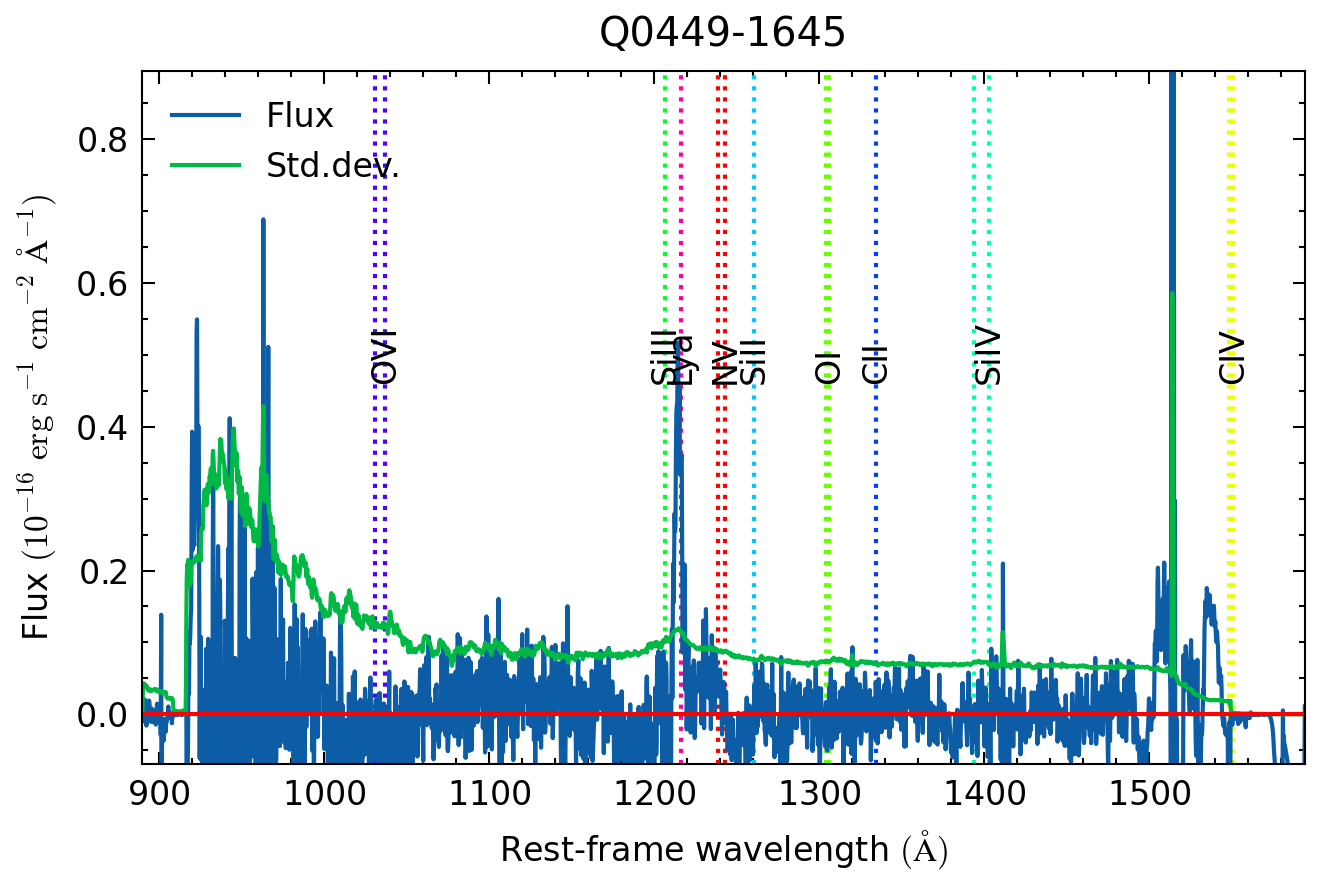

In [129]:
import matplotlib
import scienceplots
plt.style.use(["science",'no-latex'])
plt.rcParams.update({
    "font.family": "dejavu sans",   # specify font family here
    "font.serif": ["Times"],  # specify font here
    "font.size":8,
"legend.fancybox":True})
rng1 = np.random.default_rng(122807528840384100672342137672332424406)
regu = r"Flux $\rm (10^{-16}~erg~s^{-1}~cm^{-2}~\AA^{-1})$"
fig, ax = plt.subplots(figsize=(5,3),dpi=300)

x = Var_cube.spectral_axis
xlow=Sub_cube.spectral_extrema[0].value/(1+redshift)
xhigh=Sub_cube.spectral_extrema[1].value/(1+redshift)
keys=lines.keys()
colors=matplotlib.cm.hsv(np.arange(len(keys))/len(keys))


# redshift of the CGM being probed. QSO sight-line
zcgm = redshift
rlinec= (zcgm+1)/(redshift+1)
mask=np.full(len(x),False)

yup=np.max(spec[~mask][100:1300])
#yup=np.max(Org_spec[~mask][:1000])
plt.ylim(-yup*1e-1, yup*1.3)
#Marking the important lines
#ax.axvline(rlinec*1215.67,ls=":")
#ax.text(rlinec*1215.67, yup/1.3,r"Ly$\alpha$",rotation=90,verticalalignment='bottom',horizontalalignment='center',fontsize=10)
dlam=7.5/2800


#xlow=1500
#xhigh=1580
for ind,key in enumerate(keys):
    for line in lines[key]:
        if line < xhigh and line > xlow:
            ax.axvline(rlinec*line,ls=":",c=colors[ind])
#            masktmp = (x.value < ((1+redshift)*line*(1+dlam))) & (x.value > ((1+redshift)*line*(1-dlam)))
#            mask= mask | masktmp
           # print(x[mask])
    if line < xhigh and line > xlow:
        ax.text(rlinec*line, yup/1.5,key,rotation=90,verticalalignment='bottom',horizontalalignment='center')

#ax.plot(x[~mask]/(1+redshift), Org_spec[~mask], label = "Continuum subtracted cube")

ax.plot(x[~mask]/(1+redshift), spec[~mask],"-", label = "Flux")
#ax.plot(x[~mask]/(1+redshift), spec1[~mask],"b:", label = "Flux from peak")
#ax.fill_between(x.value/(1+redshift), spec.value - sigma, spec.value + sigma, color='cyan', alpha=0.2, label='1-sigma region')
ax.plot(x[~mask]/(1+redshift), np.sqrt(var[~mask]), label = "Std.dev.")
ax.axhline(0,color="r")
ax.legend(loc="best")
ax.set_xlabel(r"Rest-frame wavelength $(\rm \AA)$")
ax.set_ylabel(regu)
ax.set_title("{}".format(sname))
ax.set_xlim([xlow,xhigh])

fig.savefig(subdapath+"/{}neb_{}-{}_1d.pdf".format(linename,field,sname))


Refined redshift: 2.6808973971225156
initial redshift: 2.684


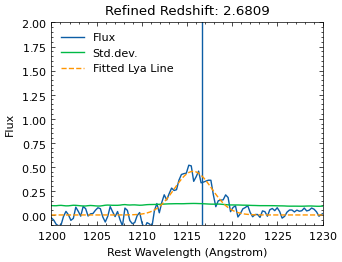

In [131]:
# Model function for Lya line (Gaussian profile as an example)
from scipy.optimize import curve_fit

def lya_model(wavelength, z, amplitude, width):
    rest_wavelength = wavelength / (1 + z)
    return amplitude * np.exp(-0.5 * ((rest_wavelength - 1215.67) / width) ** 2)



# Desired rest frame range around Lya (e.g., ±10 Å)
rest_frame_range = [1205, 1225]

# Convert the rest frame range to the observed frame using the initial redshift
observed_frame_range = [(wave * (1 + redshift)) for wave in rest_frame_range]

# Select the data within this observed wavelength range
mask = (x.value >= observed_frame_range[0]) & (x.value <= observed_frame_range[1])
x_selected = x[mask].value
spec_selected = spec[mask]
var_selected = var[mask]


# Initial parameter guess
initial_guess = [redshift, 1.0, 1.0]

# Fit the model to the data
popt, pcov = curve_fit(lambda wavelength, z, amp,  wid: lya_model(wavelength, z, amp, wid),
                       x_selected, spec_selected, p0=initial_guess,sigma=np.sqrt(var_selected), absolute_sigma=True)

# Extract the refined redshift
refined_redshift = popt[0]
print("Refined redshift:", refined_redshift)
plt.axvline(1215.67*(1 + redshift)/ (1 + refined_redshift))
# Plot the data and the fit
plt.plot(x / (1 + refined_redshift), spec, "-", label="Flux")
plt.plot(x / (1 + refined_redshift), np.sqrt(var), label="Std.dev.")
plt.plot(x / (1 + refined_redshift), lya_model(x.value, *popt), label="Fitted Lya Line", linestyle='dashed')
plt.xlim([1200, 1230])
plt.ylim([-0.1, 2])
plt.legend()
plt.xlabel("Rest Wavelength (Angstrom)")
plt.ylabel("Flux")
print("initial redshift:",redshift)
plt.title(f"Refined Redshift: {refined_redshift:.4f}")
plt.show()
zref[sname]=refined_redshift

In [85]:
zref

{'Q0821+3107': 2.629424196140442}

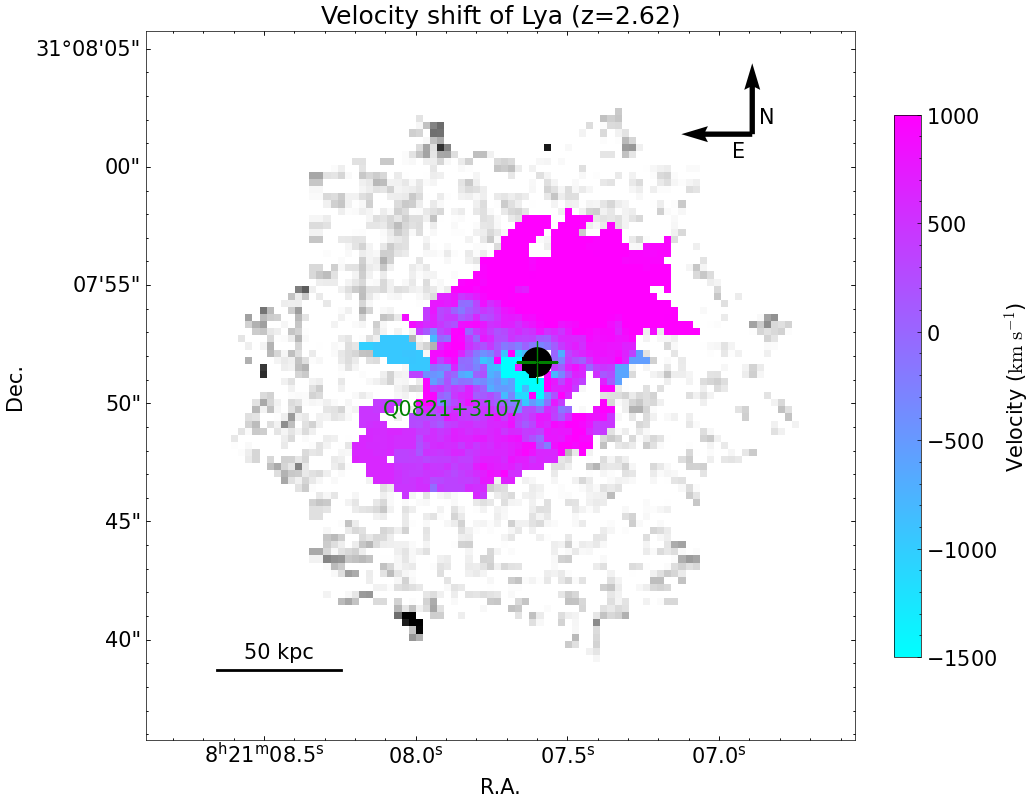

In [62]:
# plt.style.use(["science",'no-latex'])
plt.rcParams.update({
    "font.family": "dejavu sans",   # specify font family here
    "font.serif": ["Times"],  # specify font here
    "font.size":15,
"legend.fancybox":True})
#

Lyau = r"SB$_{\rm Ly\alpha}\,\rm (10^{-18}~erg~s^{-1}~arcsec^{-2}~cm^{-2})$"

_, med, std = sigma_clipped_stats(Lya_mflux.value*100)
#mask=Lya_mflux < 2.*Lya_msig.value
plotlw=line_shift_velocity.copy()
#plotlw[mask]=np.nan
# Integrated Lya image

fig, ax, im1 = imshow_astro(Lya_mflux.value*100, wcsinfo, cblabel = Lyau, colorbar=False, vrange = (0, 20*std),cmap = "binary")
#im1.set_visible(False)
# Lya velocity map
cmap = plt.cm.cool
cmap.set_bad(color='none') 
alpha=1
vmin=-1500
vmax=1000

im = ax.imshow(plotlw,cmap=cmap,alpha=alpha,vmin=vmin,vmax=vmax)#,norm=norm)

cb = plt.colorbar(im, label = r"Velocity ($\rm km~s^{-1}$)", fraction =0.035)

#Source position
#psname=sourcename


sc = SkyCoord(ra=RA, dec=DEC, unit='deg',frame="icrs", equinox='J2000')
#s_coord=wcsinfo.world_to_pixel(sc)

#s_coord3=wcsinfo.world_to_pixel(sc3)
#ax.plot(s_coord3[0],s_coord3[1],"+",c="r",ms=30,lw=0.1)


ax.plot(s_coord[0],s_coord[1],"+",c="g",ms=30,lw=0.1)
ax.text(s_coord[0]-2,s_coord[1]-8
        ,"{}".format(sname),color="green",verticalalignment='bottom',horizontalalignment='right')


#ax.scatter(sc2.ra.value, sc2.dec.value, transform=ax.get_transform('world'), s=55, edgecolor='r', facecolor='none')
#ax.text(sc2.ra.value, sc2.dec.value,"{}-{}".format(cubename,tag2),color="red",transform=ax.get_transform('world'),verticalalignment='bottom',horizontalalignment='right',fontsize=15)



x0, y0 = 85, 85
arrow_length = 10

# North arrow goes upward in y-direction (positive Dec)
ax.quiver(x0, y0, 0, arrow_length, angles='xy', scale_units='xy', scale=1, color='black', label='North')
ax.text(x0+2, y0+1, 'N', color='black', ha='center', va='bottom')
# East arrow goes to the right in x-direction (negative RA)
ax.quiver(x0, y0, -arrow_length, 0, angles='xy', scale_units='xy', scale=1, color='black', label='East')
ax.text(x0-2, y0-1, 'E', color='black', ha='center', va='top')

#for r in rl:
#    r[0].plot(origin=(0, 0),ax=ax)


#region_sky4 = RectangleSkyRegion(center=sc,
#                                 width=0.70000 * u.arcsec, height=7.01458 * u.arcsec,
#                                 angle=24.300 * u.deg)
region_pix4 = CirclePixelRegion(center=PixCoord(x=s_coord[0],y=s_coord[1]),radius=2)

#region_pix4 = region_sky4.to_pixel(wcsinfo)
region_pix4.plot(origin=(0, 0),ax=ax,color="k",fill=True)

#-------------------Reference scale setting----------------#
dT = 50  # kpc distance
delta_theta_deg = dT/Planck18.kpc_proper_per_arcmin(redshift).value/60
x_lim = ax.get_xlim()
y_lim = ax.get_ylim()
start_x = x_lim[0] + 0.10 * (x_lim[1] - x_lim[0])
start_y = y_lim[0] + 0.10 * (y_lim[1] - y_lim[0])
start_coord = wcsinfo.pixel_to_world(start_x, start_y)
end_coord = wcsinfo.pixel_to_world(start_x + 1, start_y)  # arbitrary +1 in pixel to get RA difference for 1 pixel

delta_ra_per_pixel = start_coord.ra.degree - end_coord.ra.degree
length_in_pixels = delta_theta_deg / delta_ra_per_pixel

ax.plot([start_x, start_x + length_in_pixels], [start_y, start_y], color='black', lw=2)
ax.text(start_x + length_in_pixels / 2, start_y+1, '{} kpc'.format(dT), color='black', ha='center', va='bottom')
ax.set_xlabel("R.A.")
ax.set_ylabel("Dec.")


ax.set_title(r"Velocity shift of {} (z={})".format(linename,round(redshift,2)))
fig.savefig(subdapath+"/PSFSub_vshift_{}_{}_{}.pdf".format(linename,field,sname))
#plt.show()

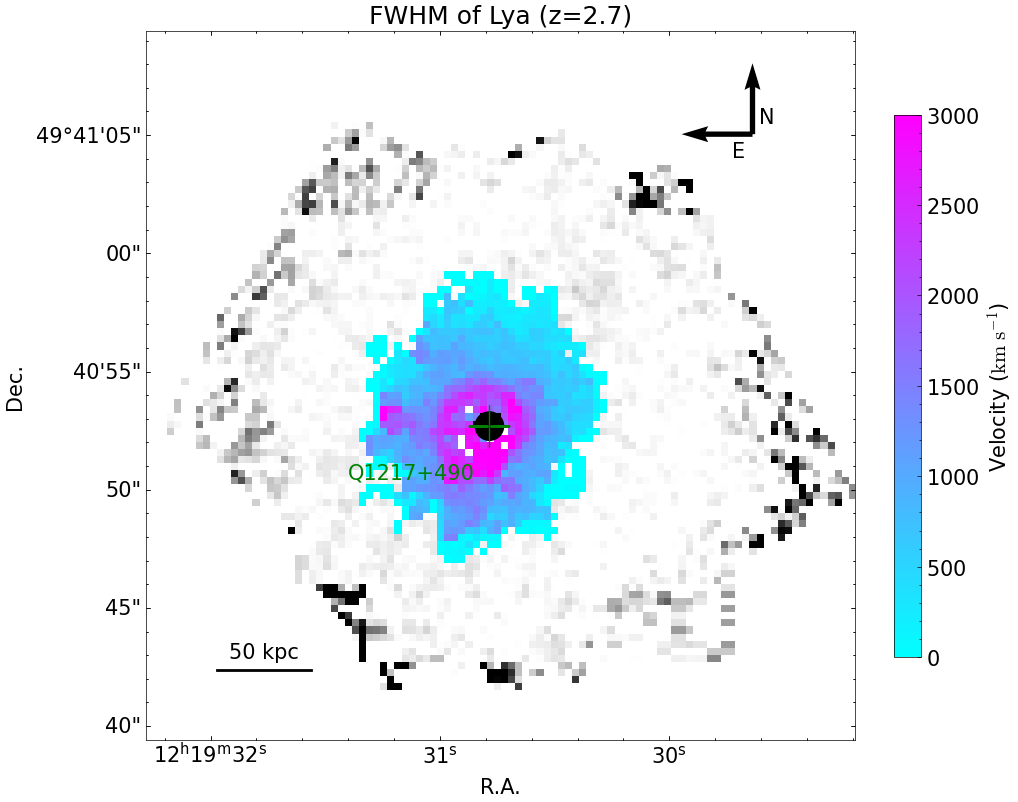

In [172]:
plt.style.use(["science",'no-latex'])
plt.rcParams.update({
    "font.family": "dejavu sans",   # specify font family here
    "font.serif": ["Times"],  # specify font here
    "font.size":15,
"legend.fancybox":True})
#

Lyau = r"SB$_{\rm Ly\alpha}\,\rm (10^{-18}~erg~s^{-1}~arcsec^{-2}~cm^{-2})$"

_, med, std = sigma_clipped_stats(Lya_mflux.value*100)
#mask=Lya_mflux < 2.*Lya_msig.value
plotlw=line_widthsigma_velocity.copy()
#plotlw[mask]=np.nan
# Integrated Lya image

fig, ax, im1 = imshow_astro(Lya_mflux.value*100, wcsinfo, cblabel = Lyau, colorbar=False, vrange = (0, 20*std),cmap = "binary")
#im1.set_visible(False)
# Lya velocity map
cmap = plt.cm.cool
cmap.set_bad(color='none') 
alpha=1
vmin=0
vmax=3000

im = ax.imshow(plotlw,cmap=cmap,alpha=alpha,vmin=vmin,vmax=vmax)#,norm=norm)

cb = plt.colorbar(im, label = r"Velocity ($\rm km~s^{-1}$)", fraction =0.035)

#Source position
#psname=sourcename


sc = SkyCoord(ra=RA, dec=DEC, unit='deg',frame="icrs", equinox='J2000')
#s_coord=wcsinfo.world_to_pixel(sc)

#s_coord3=wcsinfo.world_to_pixel(sc3)
#ax.plot(s_coord3[0],s_coord3[1],"+",c="r",ms=30,lw=0.1)


ax.plot(s_coord[0],s_coord[1],"+",c="g",ms=30,lw=0.1)
ax.text(s_coord[0]-2,s_coord[1]-8
        ,"{}".format(sname),color="green",verticalalignment='bottom',horizontalalignment='right')


#ax.scatter(sc2.ra.value, sc2.dec.value, transform=ax.get_transform('world'), s=55, edgecolor='r', facecolor='none')
#ax.text(sc2.ra.value, sc2.dec.value,"{}-{}".format(cubename,tag2),color="red",transform=ax.get_transform('world'),verticalalignment='bottom',horizontalalignment='right',fontsize=15)



x0, y0 = 85, 85
arrow_length = 10

# North arrow goes upward in y-direction (positive Dec)
ax.quiver(x0, y0, 0, arrow_length, angles='xy', scale_units='xy', scale=1, color='black', label='North')
ax.text(x0+2, y0+1, 'N', color='black', ha='center', va='bottom')
# East arrow goes to the right in x-direction (negative RA)
ax.quiver(x0, y0, -arrow_length, 0, angles='xy', scale_units='xy', scale=1, color='black', label='East')
ax.text(x0-2, y0-1, 'E', color='black', ha='center', va='top')

#for r in rl:
#    r[0].plot(origin=(0, 0),ax=ax)


#region_sky4 = RectangleSkyRegion(center=sc,
#                                 width=0.70000 * u.arcsec, height=7.01458 * u.arcsec,
#                                 angle=24.300 * u.deg)
region_pix4 = CirclePixelRegion(center=PixCoord(x=s_coord[0],y=s_coord[1]),radius=2)

#region_pix4 = region_sky4.to_pixel(wcsinfo)
region_pix4.plot(origin=(0, 0),ax=ax,color="k",fill=True)

#-------------------Reference scale setting----------------#
dT = 50  # kpc distance
delta_theta_deg = dT/Planck18.kpc_proper_per_arcmin(redshift).value/60
x_lim = ax.get_xlim()
y_lim = ax.get_ylim()
start_x = x_lim[0] + 0.10 * (x_lim[1] - x_lim[0])
start_y = y_lim[0] + 0.10 * (y_lim[1] - y_lim[0])
start_coord = wcsinfo.pixel_to_world(start_x, start_y)
end_coord = wcsinfo.pixel_to_world(start_x + 1, start_y)  # arbitrary +1 in pixel to get RA difference for 1 pixel

delta_ra_per_pixel = start_coord.ra.degree - end_coord.ra.degree
length_in_pixels = delta_theta_deg / delta_ra_per_pixel

ax.plot([start_x, start_x + length_in_pixels], [start_y, start_y], color='black', lw=2)
ax.text(start_x + length_in_pixels / 2, start_y+1, '{} kpc'.format(dT), color='black', ha='center', va='bottom')
ax.set_xlabel("R.A.")
ax.set_ylabel("Dec.")


ax.set_title(r"FWHM of {} (z={})".format(linename,round(redshift,2)))
fig.savefig(subdapath+"/PSFSub_FWHM_{}_{}_{}.pdf".format(linename,field,sname))
#plt.show()

## Estimate the BH mass with ZYJHK/IRAC photometries and Neb. line FWHM

In [130]:
file="/disk/bifrost/yuanze/KBSS/Q1700/SDSS/HS1700+64.fits"

hdu=fits.open(file)
spec=hdu[1].data['flux']
x=10**(hdu[1].data['loglam'])
#x = hdu[0].header["CRVAL1"] + (np.arange(hdu[0].data.shape[0])+1)*hdu[0].header["CD1_1"]

Refined redshift: 2.7155898846893525
initial redshift: 2.721


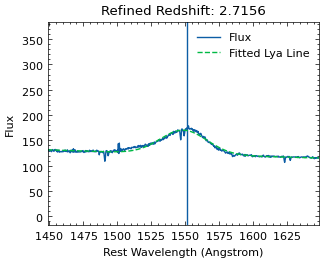

In [132]:
# Model function for Lya line (Gaussian profile as an example)
from scipy.optimize import curve_fit
field = "0100"
sentry=qsos_bright[qsos_bright["Field"]=="Q"+field]
sname=sentry["Name"][0]
redshift=sentry["z_sys"].value[0]


def lya_model(wavelength, z, amplitude, width):
    rest_wavelength = wavelength / (1 + z)
    return amplitude * np.exp(-0.5 * ((rest_wavelength - 1215.67) / width) ** 2)

linec=1549#4862.6

xup=linec+100
xlow=linec-100
def line_model(wavelength, z, amplitude, width,ampp,exponent):
    rest_wavelength = wavelength / (1 + z)
    return amplitude * np.exp(-0.5 * ((rest_wavelength - linec) / width) ** 2)+ampp*np.power(rest_wavelength, exponent)

def logline_model(wavelength, z, amplitude, width,ampp,exponent):
    rest_wavelength = np.log(wavelength / (1 + z))
    return amplitude * np.exp(-0.5 * ((rest_wavelength - np.log(linec)) / width) ** 2)+ampp*np.power(rest_wavelength, exponent)


# Desired rest frame range around Lya (e.g., ±10 Å)
rest_frame_range = [xlow, xup]

# Convert the rest frame range to the observed frame using the initial redshift
observed_frame_range = [(wave * (1 + redshift)) for wave in rest_frame_range]

# Select the data within this observed wavelength range
mask = (x >= observed_frame_range[0]) & (x <= observed_frame_range[1])
x_selected = x[mask]
spec_selected = spec[mask]
#var_selected = var[mask]


# Initial parameter guess
initial_guess = [redshift, 1.0, 0.001,10,2]

# Fit the model to the data
popt, pcov = curve_fit(lambda wavelength, z, amp,  wid, ampp, expo: logline_model(wavelength, z, amp, wid, ampp, expo),
                       x_selected, spec_selected, maxfev = 5000, p0=initial_guess, absolute_sigma=True)

# Extract the refined redshift
refined_redshift = popt[0]
print("Refined redshift:", refined_redshift)
plt.axvline(linec*(1 + redshift)/ (1 + refined_redshift))
# Plot the data and the fit
plt.plot(x / (1 + refined_redshift), spec, "-", label="Flux")
#plt.plot(x / (1 + refined_redshift), np.sqrt(var), label="Std.dev.")
plt.plot(x / (1 + refined_redshift), logline_model(x, *popt), label="Fitted Lya Line", linestyle='dashed')
plt.xlim([xlow, xup])
#plt.ylim([-0.1, 2])
plt.legend()
plt.xlabel("Rest Wavelength (Angstrom)")
plt.ylabel("Flux")
print("initial redshift:",redshift)
plt.title(f"Refined Redshift: {refined_redshift:.4f}")
plt.show()
#zref[sname]=refined_redshift

In [133]:
logline_model(x, *popt)

array([188.76407, 188.7174 , 188.67093, ...,  77.25535,  77.23841,
        77.22154], dtype=float32)

In [134]:
popt[2]*3e5

3348.0715919726385

In [135]:
import pandas as pd
QSOline=pd.read_csv("/disk/bifrost/yuanze/KBSS/KCWI/HLQSO_line_FWHM.dat",header=0,index_col=0,delimiter=" +")
QSOphot=pd.read_csv("/disk/bifrost/yuanze/KBSS/kbss_qsos.inphot",header=0,delimiter=" +")
def MAB2Flam(MAB,Lambda):
    """
    Convert AB magnitude to flux density in cgs units of erg/s/cm^3.
    M_{AB}=-2.5\log_{10}f_{\nu}-48.60
    
    Parameters:
    MAB (float): AB magnitude
    Lambda (float): Wavelength in cm

    Returns:
    float: Flux density in cgs units of erg/s/cm^3
    """
    ccgs=constants.c.to(u.cm/u.s).value
    fnu=10**((MAB+48.6)/(-2.5))
    return fnu*ccgs/Lambda**2

def FWHM_to_MBH_2016(Llam,FWHM,line):
    """
    MNRAS 460, 187 (2016)
    Line width-Luminosity BH mass estimator
    Llam: monocromatic flux (1e44 erg/s)
    FWHM: line width of Ha (1000 km/s)
    """
    if line=="Ha":
        #FWHM_Ha-L5100
        return 10**6.845*Llam**0.650*FWHM**2
    elif line=="Hb":
        #FWHM_Hb-L5100
        return 10**6.740*Llam**0.650*FWHM**2
    elif line=="MgII":
        #FWHM_MgII-L3000
        return 10**6.925*Llam**0.609*FWHM**2
    else:
        print("Warning: invalid line name")
        return 1
    
def FWHM_to_MBH_Shen2012(Llam,FWHM,line):
    """
    ApJ 753:125 (2012), Shen 2012
    Line width-Luminosity BH mass estimator
    Llam: monocromatic flux (1e44 erg/s)
    FWHM: line width of Ha (1000 km/s)
    """
    if line=="Ha":
        #FWHM_Ha-L5100
        a=1.390
        b=0.555
        c=1.873
    elif line=="Hb":
        #FWHM_Hb-L5100
        a=0.895
        b=0.520
        c=2.000
    elif line=="MgII":
        #FWHM_MgII-L3000
        a=1.816
        b=0.584
        c=1.712
    elif line=="CIV":
        a=7.295
        b=0.471
        c=0.242
    else:
        print("Warning: invalid line name")
        return 1
    return 10**(a+b*np.log10(Llam)+c*np.log10(FWHM*1000))
    

LamP={"J":12530.,"H":16370.,"K":21620.,"g":4731.} #pivot wavelength in Angstrom
MBHsigma={"CIV":0.28,"Hb":0.003,"Ha":0.12,"MgII":0.16}
#FWHM=[]
Lcont=[]
L5100=[]
L5100_err=[]
L3100=[]
L3100_err=[]
Lcont_err=[]
MBH_Shen2012=[]
MBH_2016=[]
MBH_err=[]
for index,obj in QSOphot.iterrows():
    #print(obj)
    sname=obj["Obj"]
    
    sentry=qsos_bright[qsos_bright["Name"]==sname]
    z_sys=sentry["z_sys"][0]
    ld=Planck18.luminosity_distance(z_sys).to(u.cm).value
    Sld=4*np.pi*ld**2
    
    L5100.append(MAB2Flam(obj["H"],LamP["H"]*1e-8)*LamP["H"]*1e-8*Sld)
    L5100_err.append(L5100[-1]*np.sqrt(obj["Herr"]**2+0.1**2))
    L3100.append(MAB2Flam(obj["J"],LamP["J"]*1e-8)*LamP["J"]*1e-8*Sld)
    L3100_err.append(L3100[-1]*np.sqrt(obj["Jerr"]**2+0.1**2))
    try:
        lines=QSOline.loc[sname]["linename"]
        FWHM=QSOline.loc[sname]["fwhm(km/s)"]/1000 #FWHM in 1000 km/s
        print(FWHM)
    except:
        print("no such object:",sname)
        Lcont.append(np.nan)
        Lcont_err.append(np.nan)
        MBH_Shen2012.append(np.nan)
        MBH_2016.append(np.nan)
        MBH_err.append(np.nan)
        #L5100.append(np.nan)
        #L5100_err.append(np.nan)
        continue
    if isinstance(lines,str):
        lines=[lines]
    
    if "MgII" in lines:
        lselect="MgII"
        Lcont.append(MAB2Flam(obj["J"],LamP["J"]*1e-8)*LamP["J"]*1e-8*Sld)
        Lcont_err.append(Lcont[-1]*obj["Jerr"])
    elif ("Hb" in lines):
        lselect="Hb"
        Lcont.append(MAB2Flam(obj["H"],LamP["H"]*1e-8)*LamP["H"]*1e-8*Sld)
        Lcont_err.append(Lcont[-1]*obj["Herr"])
    elif  ("Ha" in lines):
        lselect="Ha"
        Lcont.append(MAB2Flam(obj["H"],LamP["H"]*1e-8)*LamP["H"]*1e-8*Sld)
        Lcont_err.append(Lcont[-1]*obj["Herr"])
    elif "CIV" in lines:
        lselect="CIV"
        Lcont.append(MAB2Flam(sentry["g"][0],LamP["g"]*1e-8)*LamP["g"]*1e-8*Sld)
        Lcont_err.append(Lcont[-1]*0.1)
      
    MBH_Shen2012.append(FWHM_to_MBH_Shen2012(Lcont[-1]/1e44,FWHM,lselect))
    MBH_2016.append(FWHM_to_MBH_2016(Lcont[-1]/1e44,FWHM,lselect))
    MBH_err.append(MBHsigma[lselect])
    print(lines,"for",sname)
    print("MBH (Shen_2012):%.2e"%MBH_Shen2012[-1])
    print("MBH (Mejia-Restrepo_2016):%.2e"%MBH_2016[-1])
    print("Fractional difference:%.2e"%((MBH_Shen2012[-1]-MBH_2016[-1])/(MBH_2016[-1]+MBH_Shen2012[-1])))

    
#QSOphot.insert(13,'Lcont', Lcont)
#QSOphot.insert(14,'Lcont_err', Lcont_err)
#QSOphot.insert(15,'MBH', MBH_Shen2012)


3.8741
['CIV'] for Q0100+13
MBH (Shen_2012):6.40e+09
MBH (Mejia-Restrepo_2016):1.00e+00
Fractional difference:1.00e+00
4.6389
['Ha'] for HS0105+1619
MBH (Shen_2012):8.38e+09
MBH (Mejia-Restrepo_2016):1.35e+10
Fractional difference:-2.33e-01
6.6567
['MgII'] for Q0207-003
MBH (Shen_2012):1.68e+10
MBH (Mejia-Restrepo_2016):3.28e+10
Fractional difference:-3.22e-01
4.3951
['Ha'] for Q0449-1645
MBH (Shen_2012):5.49e+09
MBH (Mejia-Restrepo_2016):8.29e+09
Fractional difference:-2.03e-01
5.0022
['Ha'] for Q0821+3107
MBH (Shen_2012):1.00e+10
MBH (Mejia-Restrepo_2016):1.64e+10
Fractional difference:-2.40e-01
3.179
['MgII'] for Q1009+29
MBH (Shen_2012):5.08e+09
MBH (Mejia-Restrepo_2016):8.02e+09
Fractional difference:-2.25e-01
8.505
['CIV'] for Q1217+490
MBH (Shen_2012):6.49e+09
MBH (Mejia-Restrepo_2016):1.00e+00
Fractional difference:1.00e+00
4.1685
['Ha'] for Q1442+2931
MBH (Shen_2012):9.70e+09
MBH (Mejia-Restrepo_2016):1.63e+10
Fractional difference:-2.54e-01
7.570600000000001
['MgII'] for Q154

/tmp/ipykernel_2084011/2960680872.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  QSOline=pd.read_csv("/disk/bifrost/yuanze/KBSS/KCWI/HLQSO_line_FWHM.dat",header=0,index_col=0,delimiter=" +")
/tmp/ipykernel_2084011/2960680872.py:3: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  QSOphot=pd.read_csv("/disk/bifrost/yuanze/KBSS/kbss_qsos.inphot",header=0,delimiter=" +")


In [30]:
ccgs=constants.c.to(u.cm/u.s).value

In [554]:
6e18*3e-22*(u.kpc.to(u.cm))**2

1.7138531046453146e+40

In [ ]:
1e20**2*3e-2*1e-3

In [528]:
nuH=(13.6*u.eV/constants.h).to(u.Hz)

In [549]:
L=np.trapz(QSOSED[18:,1]/QSOSED[18:,0],x=QSOSED[18:,0])
print(L)

8.473326200298355e+46


In [552]:
QH=np.trapz(QSOSED[18:,1]/QSOSED[18:,0]/(constants.h.to(u.erg*u.s).value*QSOSED[18:,0]),x=QSOSED[18:,0])
print(QH)

1.9515346231552728e+57


In [563]:
3e-2*8e19*(206265/(70*u.kpc.to(u.cm)))**2

2.1885937440818785e-18

In [ ]:
5.6e-14/3.65**4*1e-3

In [556]:
U=1e-2
nH=10
ro=np.sqrt(QH/(4*np.pi*nH*ccgs*U))
print(ro/u.kpc.to(u.cm))

73.76023669066376


In [31]:
# nuFnu units Hz
QSOSED=np.genfromtxt("/disk/bifrost/yuanze/my_work/cloudy/HLQSO/Lusso15QSO.sed")
QSOSED[:,0]=10**QSOSED[:,0]
print(QSOSED)
np.savetxt("/disk/bifrost/yuanze/my_work/cloudy/HLQSO/Lusso15QSO_in.sed",QSOSED)

[[1.05778736e+15 5.56652441e+46]
 [1.20678678e+15 6.33672181e+46]
 [1.32923204e+15 6.30526620e+46]
 [1.46538791e+15 6.78492537e+46]
 [1.57070592e+15 8.45540360e+46]
 [1.61374464e+15 7.02368611e+46]
 [1.76267818e+15 7.28280380e+46]
 [1.94671133e+15 7.97230779e+46]
 [1.93089480e+15 9.45022627e+46]
 [1.93089480e+15 1.12262668e+47]
 [2.14920625e+15 8.00020094e+46]
 [2.26029270e+15 8.53923290e+46]
 [2.45360000e+15 1.09427398e+47]
 [2.43707436e+15 9.11990889e+46]
 [2.46356913e+15 1.39761486e+47]
 [2.45857951e+15 1.68508941e+47]
 [2.69814157e+15 8.92498220e+46]
 [2.94806781e+15 9.60978764e+46]
 [3.25671349e+15 8.35236364e+46]
 [3.60068405e+15 7.51486399e+46]
 [3.92421211e+15 6.92253705e+46]
 [4.08445481e+15 6.06569917e+46]
 [4.55633450e+15 6.37141932e+46]
 [4.79358666e+15 6.17131045e+46]
 [5.42097338e+15 5.18121948e+46]
 [6.34973906e+15 4.42009522e+46]
 [7.11798539e+15 3.92921061e+46]
 [8.33749709e+15 2.96461024e+46]
 [9.68052299e+15 2.50307265e+46]
 [1.12398870e+16 2.09727396e+46]
 [1.305043

In [87]:
np.array(L3100)

array([1.60430724e+47, 1.10250611e+47, 1.56230277e+47, 6.76649101e+46,
       1.52774657e+47, 1.74735443e+47, 1.22102642e+47, 2.25703252e+47,
       4.60429232e+47, 2.89500621e+47, 6.53382130e+46, 3.19716207e+47,
       1.01546104e+47, 1.14462510e+47])

In [88]:
np.array(L3100_err)

array([1.79367002e+46, 1.41189672e+46, 2.20942976e+46, 9.56926336e+45,
       2.16055992e+46, 2.47113233e+46, 1.42394927e+46, 2.52343907e+46,
       4.80702231e+46, 4.09415704e+46, 9.24021870e+45, 3.57453586e+46,
       1.23952817e+46, 1.61874434e+46])

In [136]:
np.array(MBH_Shen2012),np.array(MBH_err)*np.array(MBH_Shen2012)

(array([6.40206219e+09, 8.38421873e+09, 1.68491602e+10, 5.49133659e+09,
        1.00291230e+10, 5.07541888e+09, 6.49227348e+09, 9.70468607e+09,
        3.94782780e+10, 1.82071237e+10, 4.63548777e+09, 8.18831131e+09,
        6.88018816e+09, 9.08039992e+09]),
 array([1.79257741e+09, 1.00610625e+09, 2.69586563e+09, 6.58960390e+08,
        1.20349476e+09, 8.12067020e+08, 1.81783657e+09, 1.16456233e+09,
        6.31652448e+09, 2.18485484e+09, 1.29793658e+09, 2.29272717e+09,
        8.25622580e+08, 1.08964799e+09]))

Slope (m): 0.9919112497073929
Intercept (c): -84.59436977302543
Covariance matrix: [[ 2.19395901e-01 -2.37833805e+01]
 [-2.37833805e+01  2.57828246e+03]]
Residual variance: 0.18254627620251473


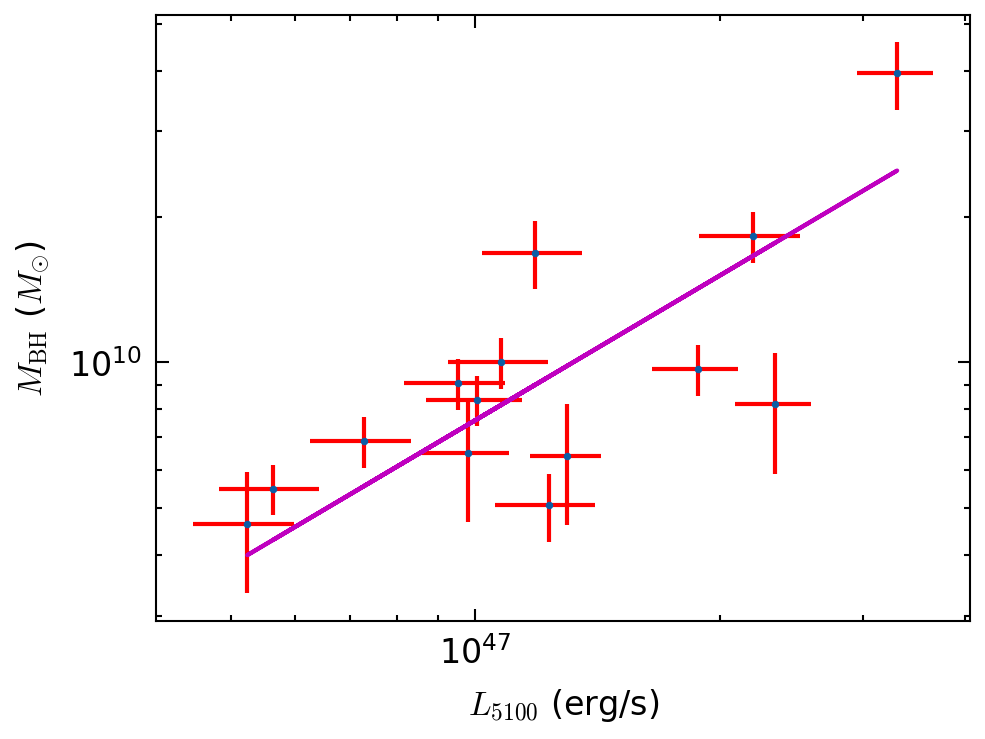

In [153]:
plt.figure(dpi=300)
from scipy.odr import ODR, Model, RealData
def linear_func(params, x):
    m, c = params
    return m * x + c

plt.errorbar(L5100,MBH_Shen2012,xerr=L5100_err,yerr=np.array(MBH_err)*np.array(MBH_Shen2012),fmt="o",ms=0.8,ecolor="r")

xfit=np.log(np.array(L5100))
xfit_err=np.array(L5100_err)/np.array(L5100)
yfit=np.log(np.array(MBH_Shen2012))
yfit_err=np.array(MBH_err)/np.array(MBH_Shen2012)
#res=scipy.stats.linregress(xfit,yfit)

data = RealData(xfit, yfit, sy=yfit_err)

# Define a model
model = Model(linear_func)

# Set up ODR
odr = ODR(data, model, beta0=[1., -10.])  # Initial guess for m and c

# Run ODR
output = odr.run()

# Results
print("Slope (m):", output.beta[0])
print("Intercept (c):", output.beta[1])
print("Covariance matrix:", output.cov_beta)
print("Residual variance:", output.res_var)

#Q1217+490 24300.51 0.0994027   10.5689    -106.3 0.0616586      161.        1987.7      2.7017   Ha 
#Q1623-KP77 17188.15 1.819E-27 1.137E-25    -62.51 1.002E-27     106.6        1860.6      2.5347  Hb

#plt.plot(10**xfit,10**(res.intercept+res.slope*xfit),"m",label="HLQSOs")
plt.plot(np.exp(xfit),np.exp(output.beta[1]+output.beta[0]*xfit),"m",label="HLQSOs")

plt.ylabel("$M_\mathrm{BH}$ ($M_{\odot}$)")
plt.xlabel("$L_{5100}$ (erg/s)")
plt.yscale("log")
plt.xscale("log")
plt.savefig(KBSSpath+"/fig/MBH_L5100.pdf")

In [138]:
res

LinregressResult(slope=0.8042375367808242, intercept=-27.90367398020734, rvalue=0.7355244917594156, pvalue=0.0027169785865257057, stderr=0.21384774812292057, intercept_stderr=10.06799153262401)

In [287]:
lines=QSOline.loc["Q1623-KP77"]["linename"]

In [335]:
QSOphot

,Obj,J,Jerr,H,Herr,Ks,Kserr,IRAC1,IRAC1err,IRAC2,IRAC2err,IRAC3,IRAC3err,Lcont,Lcont_err
0,Q0100+13,16.35,0.05,16.29,0.01,16.37,0.08,16.18,0.02,15.89,0.02,15.26,0.03,NaN,NaN
1,HS0105+1619,16.69,0.08,16.50,0.09,16.72,0.10,16.36,0.02,9999.00,9999.00,9999.00,9999.00,1.005272e+47,9.047444e+45
2,Q0207-003,16.52,0.10,16.53,0.10,16.50,0.10,16.30,0.02,9999.00,9999.00,9999.00,9999.00,1.562303e+47,1.562303e+46
3,Q0449-1645,17.25,0.10,17.16,0.10,17.26,0.10,9999.00,9999.00,17.33,0.10,17.35,0.10,5.626857e+46,5.626857e+45
4,Q0821+3107,16.30,0.10,16.39,0.10,16.19,0.10,9999.00,9999.00,16.42,0.10,9999.00,9999.00,1.076350e+47,1.076350e+46
5,Q1009+29,16.19,0.10,16.28,0.10,15.66,0.10,9999.00,9999.00,15.96,0.10,15.89,0.10,1.747354e+47,1.747354e+46
6,Q1217+490,16.63,0.06,16.58,0.07,16.66,0.09,16.39,0.02,9999.00,9999.00,9999.00,9999.00,9.786501e+46,6.850551e+45
7,Q1442+2931,15.92,0.05,15.83,0.07,15.44,0.08,15.80,0.02,9999.00,9999.00,9999.00,9999.00,1.876896e+47,1.313827e+46
8,Q1549+1919,15.32,0.03,15.39,0.04,15.48,0.03,9999.00,9999.00,15.28,0.02,9999.00,9999.00,4.604292e+47,1.381288e+46
9,HS1603+3820,15.54,0.10,15.55,0.10,15.42,0.01,9999.00,9999.00,15.68,0.10,9999.00,9999.00,2.195593e+47,2.195593e+46


In [ ]:
for name in QSOphot["Obj"]:
    for sname in QSOline
lines=QSOline[sname]
if "MgII" in lines:

## Extract center Lya peak SB and total Lya nebular flux

In [35]:
S_MAXSB={}
line_total_flux={}

In [36]:
inner_flux={}
outer_flux={}
area={}



In [44]:
qsos_bright

Name,Field,RA,Dec,x,y,EBV,z_simbad,z_sys,zerr,contam,u,g,r,i,z,MB,Comments,Mi,z_Lyaneb,Mi_z2
unit,unit,unit,unit,unit,unit,unit,unit,unit,unit,unit,unit,unit,unit,unit,unit,unit,unit,,,
str11,str5,float64,float64,float64,float64,float64,float64,float64,float64,str5,float64,float64,float64,float64,float64,float64,str71,float64,float64,float64
Q0100+13,Q0100,15.797,13.272,50.46,50.41,0.031,2.686,2.721,0.001,False,17.4,16.7,16.5,16.5,--,-26.4472,--,-30.321267391475878,2.721,-30.027446424455114
HS0105+1619,Q0105,17.027,16.597,52.31,53.45,0.058,2.64,2.652,0.001,False,18.1,17.19,17.0,16.87,16.67,--,--,-29.88400104644006,2.652,-29.62287696222411
Q0142-10,Q0142,26.319,-9.755,55.86,54.4,0.028,2.7312,2.743,0.001,True,17.54,16.85,16.73,16.64,16.6,-26.1957,lensed QSO,-30.202340819256555,2.743,-29.90206234036973
Q0207-003,Q0207,32.461,-0.085,49.95,50.93,0.024,2.85,2.872,0.001,False,18.08,17.02,16.92,16.84,16.76,--,--,-30.122461538584293,2.872,-29.804513920253623
Q0449-1645,Q0449,73.06,-15.329,52.06,51.32,0.046,2.6,2.6825,0.001,False,18.25,17.25,17.08,16.98,--,--,i-band apparent magnitude is estimated to be 17.00,-29.803957307377825,2.6825,-29.526256664305905
Q0821+3107,Q0821,125.282,31.131,54.68,52.86,0.039,2.624,2.616,0.001,False,18.08,17.26,17.04,16.87,16.66,--,--,-29.848176827459962,2.616,-29.608931911688813
Q1009+29,Q1009,152.982,29.695,48.79,48.47,0.023,2.62,2.652,0.001,False,16.73,16.16,16.09,16.02,15.89,-26.7954,--,-30.73400104644006,2.652,-30.472876962224113
Q1217+490,Q1217,184.879,49.681,47.9,43.83,0.015,2.698,2.704,0.001,False,17.77,17.09,16.92,16.79,16.7,-25.9884,--,-30.01486119098076,2.704,-29.727445289516243


In [50]:
lines={'NV':[1238.821,1242.804],'CIII]':[1909], 'CIV':[1548.20,1550.77],"OI":[1304,1306] ,"SiIII":[1206.5],"SiIV":[1393.76,1402.77],"SiII":[1260.42],"CII":[1334.53],"OVI":[1031,1037],"HeII":[1640],"Lya":[1216]}
type="HLQSO"
KBSSpath="/disk/bifrost/yuanze/KBSS"
qsos = ascii.read(KBSSpath+"/KCWI/qsos.kcwi",format="ipac")
linename="Lya"

#tid=["Q1009+29"]

# radius bin
#rbin=np.logspace(-0.5,0.48,num=6)
#rbin=np.linspace(0.3,3,6)
# windowsize:radius of circle to extract the center Lya source
windowsize=2

rextract=3.5 #radius of arcsec to extract nuclear averaged SB
#qsos_bright = ascii.read(KBSSpath+"/KCWI/qsos_bright_updated.list",format="ipac")
qsos_bright = ascii.read(KBSSpath+"/KCWI/qsos_bright_updated_full.list",format="ipac")

for id in ["Q1623-KP76","Q1623-KP78"]:#id_HL:
    sentry=qsos_bright[qsos_bright["Name"]==id]
    sourcename=id
    #sourcename=re.findall(r"-(.*)",id)[1]
    field=sentry["Field"][0]
    #cubename=sentry["Cube"].value[0]
    contam=sentry["contam"].value[0]
    if contam=="True":
        continue
    if field=="Q1623":
        subid=re.findall(r"-(.*)",id)[0]
        cubename=qsos[qsos["Name"]==subid]["Cube"][0]
        
        dapath=KBSSpath+"/"+field+"/{}/kcwi_oned".format(cubename)
        subdapath=KBSSpath+"/"+field+"/{}/kcwi_oned".format(subid)
        Subfile = subdapath+"/{}-{}_icubes_wcs.PSFCONTSub.fits".format(field.lower(),subid)
        
        cubefile = dapath+"/{}-{}_icubes_wcs.fits".format(field.lower(),cubename)
        varfile=dapath+"/{}-{}_vcubes.fits".format(field.lower(),cubename)
        
        Checkcube=fits.open(subdapath+"/{}-{}_icubes_wcs.PSFCONTSub.Objects_Id_{}.fits".format(field.lower(),subid,linename))
        objcat=np.genfromtxt(subdapath+"/{}-{}_{}.cat".format(field.lower(),subid,linename))
    else:
        subdapath=KBSSpath+"/"+field+"/QSO"
        cubefile = subdapath+"/{}-qso_icubes_wcs.fits".format(field.lower())
        Subfile = subdapath+"/{}-qso_icubes_wcs_20.PSFCONTSub.fits".format(field.lower())
        varfile=subdapath+"/{}-qso_vcubes.fits".format(field.lower())
        Checkcube=fits.open(subdapath+"/{}-qso_icubes_wcs.PSFCONTSub.Objects_Id_{}.fits".format(field.lower(),linename))
        objcat=np.genfromtxt(subdapath+"/{}-qso_{}.cat".format(field.lower(),linename))
    


    print("reading",subdapath)
    
    Org_cube = SpectralCube.read(cubefile)
    Sub_cube = SpectralCube.read(Subfile)
    Var_cube = SpectralCube.read(varfile)
    wcsinfo = Sub_cube.wcs.celestial
    
    RA = sentry["RA"].value[0]
    Dec = sentry["Dec"].value[0]
    xpix = sentry["x"].value[0]
    ypix = sentry["y"].value[0]
    s_coord=np.array([xpix,ypix])
    redshift=sentry["z_sys"].value[0]
    sc=SkyCoord(ra=RA, dec=Dec, unit='deg',frame="icrs", equinox='J2000')
    
    #sregion=regions.RectangleSkyRegion(sc,width=windowsize, height=windowsize)
    #sregion_pix=sregion.to_pixel(wcsinfo)

#    Sub_cube=O_cube.subcube_from_regions([sregion_pix])
#    Var_cube=OV_cube.subcube_from_regions([sregion_pix])
    sregion_pix = CirclePixelRegion(center=PixCoord(x=s_coord[0],y=s_coord[1]),radius=windowsize)
    S_cube=Org_cube.subcube_from_regions([sregion_pix]) #unmodified source cube, taking 2-pixes
    SV_cube=Var_cube.subcube_from_regions([sregion_pix]) #unmodified variance cube, taking 2-pixes
    #wcssub=Sub_cube.wcs.celestial
    pixel_scale=wcsinfo.pixel_scale_matrix[0,0] * 3600
    
    
    mask_3d=Checkcube[0].data
    
    # wavelength range for the extraction cube
    lw=Checkcube[0].header["CRVAL3"]
    hw=Checkcube[0].header["CRVAL3"]+(mask_3d.shape[0]-1)*Checkcube[0].header["CD3_3"]
    
    #Cut-off: geometric center of the detected object must be within N pixels of the PSF center (1 pix \simeq 0.3 arcsec)
    Npix=15
    
    if len(objcat.shape)>1:
        obj_coord=objcat[:,2:4]
        obj_num=objcat[:,0]
        dis=np.linalg.norm(obj_coord - np.array(s_coord),axis=1)
        print("distance from PSF to objects (pixels):")
        print(dis)
        sel_num=obj_num[dis<Npix]
        print("selected objects: obj_num, N_Voxels")
        print(sel_num,objcat[:,1][dis<Npix])
    else:
        sel_num=objcat[0]
        obj_coord=objcat[2:4]
    
    #sel_num=np.array([4])
    mask_3d_filtered=np.isin(mask_3d, sel_num.astype(int))


    region_pix4 = CirclePixelRegion(center=PixCoord(x=s_coord[0],y=s_coord[1]),radius=windowsize)
    rmask=region_pix4.to_mask()
    rmask2D_image = rmask.to_image(mask_3d_filtered.shape[1:])
    expanded_rmask_image = np.repeat(rmask2D_image[np.newaxis, :, :], mask_3d_filtered.shape[0], axis=0)

    inner_pix = CirclePixelRegion(center=PixCoord(x=s_coord[0],y=s_coord[1]),radius=11.5) #inner ring: 11.5 pixels~3.4 arcsec~28 pkpc at z=2.65
    inner2D_image = inner_pix.to_mask().to_image(mask_3d_filtered.shape[1:])
    expanded_innermask_image = np.repeat(inner2D_image[np.newaxis, :, :], mask_3d_filtered.shape[0], axis=0)
    
    outer_pix = CirclePixelRegion(center=PixCoord(x=s_coord[0],y=s_coord[1]),radius=26.6) #outer ring: 26.6 pixels
    outer2D_image = outer_pix.to_mask().to_image(mask_3d_filtered.shape[1:])
    expanded_outermask_image = np.repeat(outer2D_image[np.newaxis, :, :], mask_3d_filtered.shape[0], axis=0)
    
    mask_3d_filtered=mask_3d_filtered & (~expanded_rmask_image.astype(bool))

    mask_2d_filtered=np.nansum(mask_3d_filtered,axis=0)
    
    mask_3d_outer = mask_3d_filtered & expanded_outermask_image.astype(bool) & (~expanded_innermask_image.astype(bool))

    mask_3d_inner = mask_3d_filtered & expanded_innermask_image.astype(bool)


    area[sourcename]=[np.nansum((inner2D_image.astype(bool) & mask_2d_filtered).astype(int)),\
                      np.nansum((outer2D_image.astype(bool) & mask_2d_filtered & (~inner2D_image.astype(bool))).astype(int)),\
                     np.nansum(mask_2d_filtered.astype(int))]
    
    subcube1=Sub_cube.spectral_slab(lw*u.AA,hw*u.AA)
    varsubcube1=Var_cube.spectral_slab(lw*u.AA,hw*u.AA)
    subcube2=subcube1.unmasked_data[:].value
    varsubcube2=varsubcube1.unmasked_data[:].value


    S_subcube=S_cube.spectral_slab(lw*u.AA,hw*u.AA).unmasked_data[:].value #unmodified source cube
    SV_subcube=SV_cube.spectral_slab(lw*u.AA,hw*u.AA).unmasked_data[:].value #unmodified variance cube
    #Averaged Peak SB around the rest-frame Lya wavelength
    smax_arg=np.nanargmax(S_subcube,axis=0)
    S_MAXSB[sourcename]=[np.nansum(np.nanmax(S_subcube,axis=0)),np.sqrt(np.nansum(SV_subcube[smax_arg]))]  

    
    

    
    
    # Extract the spaxels that are marked as detection in CubEx
    line_maskedcube = np.where(mask_3d_filtered.astype(bool), subcube2, 0)
    line_maskedcube_var = np.where(mask_3d_filtered.astype(bool), varsubcube2, 0)


    line_innercube = np.where(mask_3d_inner.astype(bool), subcube2, 0)
    line_innercube_var = np.where(mask_3d_inner.astype(bool), varsubcube2, 0)
    line_outercube = np.where(mask_3d_outer.astype(bool), subcube2, 0)
    line_outercube_var = np.where(mask_3d_outer.astype(bool), varsubcube2, 0)
    
    
    # sum over the cube to obtain the 2-D line SB distribution  
    line_mflux=np.nansum(line_maskedcube,axis=0)
    line_mflux_var=np.nansum(line_maskedcube_var,axis=0)
    #line_msig=np.sqrt(line_mflux_var)

    line_innermflux=np.nansum(line_innercube,axis=0)
    line_innermflux_var=np.nansum(line_innercube_var,axis=0)
    #line_innermsig=np.sqrt(line_innermflux_var)
    line_outermflux=np.nansum(line_outercube,axis=0)
    line_outermflux_var=np.nansum(line_outercube_var,axis=0)
    #line_outermsig=np.sqrt(line_outermflux_var)
    
   # mask=Lya_mflux.value > 1.0*Lya_msig.value
    #bad=np.isnan(Lya_moment_1[mask])
    
    #total line flux and 1-sigma with unit 1e-16 erg/s/cm^2
    line_total_flux[sourcename]=[np.nansum(line_mflux*pixel_scale**2,axis=(0,1)),np.sqrt(np.nansum(line_mflux_var,axis=(0,1)))*pixel_scale**2]

    inner_flux[sourcename]=[np.nansum(line_innermflux*pixel_scale**2,axis=(0,1)),np.sqrt(np.nansum(line_innermflux_var,axis=(0,1)))*pixel_scale**2]
    outer_flux[sourcename]=[np.nansum(line_outermflux*pixel_scale**2,axis=(0,1)),np.sqrt(np.nansum(line_outermflux_var,axis=(0,1)))*pixel_scale**2]


    #flux weighted bulk velocity
    # reconstruct a new cube for velocity dispersion, velocity shift calculations.
    new_cube = SpectralCube(data=line_maskedcube, wcs=subcube1.wcs)
    
    line_shift_lambda=new_cube.moment(order=1)
    
    line_widthsigma=new_cube.linewidth_fwhm()
    
    line_w_mean=np.mean(lines[linename]) #average theoretical rest-frame wavelength of the selected line
    line_shift_velocity=(line_shift_lambda.to(u.AA).value/(1+redshift)-line_w_mean)/line_w_mean*constants.c.to(u.km/u.s).value
    line_widthsigma_velocity=line_widthsigma.to(u.AA).value/line_w_mean*constants.c.to(u.km/u.s).value/(1+redshift)


    # Lya brightness within 3 arcsec
 #   region_sky = CircleSkyRegion(center=sc, radius=3. * u.arcsec)
 #   region_pix = region_sky.to_pixel(wcssub)
 #   Lya_mflux_sub=Lya_subcube.subcube_from_regions([region_pix]).sum(axis=0,how='cube')
 #   Lya_mvar_sub=Lya_subvarcube.subcube_from_regions([region_pix]).sum(axis=0,how='cube')
    
#    npix=np.sum((~np.isnan(Lya_mflux_sub)).astype(int))
 #   Lya_3arc[sourcename]=[pixel_scale**2*np.nansum(Lya_mflux_sub).value,pixel_scale**2*np.sqrt(np.nansum(Lya_mvar_sub).value)]
    
#    mask_annulus_reg = region_annulus_pix.to_mask()
#    mask_annulus_reg = mask_annulus_reg.to_image(Sub_cube.shape[1:]).astype(bool)







reading /disk/bifrost/yuanze/KBSS/Q1623/KP76/kcwi_oned


distance from PSF to objects (pixels):
[ 8.63625498 36.0208287  15.97930224  4.11096096 17.08000293 39.45893308
  7.7744003  26.86882394 30.70437754 21.92708827]
selected objects: obj_num, N_Voxels
[1. 4. 7.] [ 22. 500.  22.]


/disk/bifrost/yuanze/anaconda3/envs/nmma/lib/python3.8/site-packages/spectral_cube/_moments.py:168: RuntimeWarning: invalid value encountered in divide
  return (np.nansum(data * pix_cen, axis=axis) /


reading /disk/bifrost/yuanze/KBSS/Q1623/KP78/kcwi_oned


distance from PSF to objects (pixels):
[23.75603081 47.47302497 20.61229002 22.98938886 22.77558342 43.18355474
 23.10634978 34.18755622 23.21330868  4.12248711 22.75052747 28.08817901
 20.68242249 27.9162193  44.49358268 29.73667096  4.04108896 20.47470635
  3.78906321 20.58350067 22.9219589   2.43261177 35.57138738 22.9526578
 13.67003292  3.85845824  4.00361087 51.29875632 22.83584901 24.17764463
 22.81448663  4.39045556  3.33541602 24.63894681  3.68480664 10.36400019
  6.14564073 22.48064278 23.79666573 23.78538207 23.01662443 36.14356098
 22.51759312 18.28282527 22.38989281 21.91216329 22.61939875 22.66706862
 22.97130819 53.9969814  55.06389924 21.41827491 22.75386561 22.13122003]
selected objects: obj_num, N_Voxels
[10. 17. 19. 22. 25. 26. 27. 32. 33. 35. 36. 37.] [  21.   42.   34.   42.   21.   31.   27.   52.   31. 2416.   22.   25.]


/disk/bifrost/yuanze/anaconda3/envs/nmma/lib/python3.8/site-packages/spectral_cube/_moments.py:168: RuntimeWarning: invalid value encountered in divide
  return (np.nansum(data * pix_cen, axis=axis) /


In [42]:
area['']

{'Q0100+13': [187, 337, 12958],
 'HS0105+1619': [208, 385, 11847],
 'Q0207-003': [196, 604, 19802],
 'Q0449-1645': [149, 46, 1839],
 'Q0821+3107': [193, 405, 7316],
 'Q1009+29': [196, 629, 17961],
 'Q1217+490': [228, 312, 12006],
 'Q1549+1919': [200, 457, 15875],
 'HS1603+3820': [187, 257, 7998],
 'Q1623-KP77': [198, 101, 6657],
 'Q2206-199': [203, 237, 7504],
 'Q2343+12': [206, 743, 33416]}

In [56]:
inner_flux

{'Q0100+13': [23.955927, 0.13459606687468964],
 'HS0105+1619': [14.426704, 0.09065326195598014],
 'Q0207-003': [29.772833, 0.10237910266450145],
 'Q0821+3107': [9.119091, 0.0790603339398739],
 'Q1009+29': [18.763617, 0.13627678954886724],
 'Q1217+490': [16.532547, 0.10045251066109331],
 'Q1549+1919': [43.08654, 0.1540895613849062],
 'HS1603+3820': [14.862792, 0.09803476409773043],
 'Q1623-KP77': [12.081545, 0.06445832471930028],
 'Q2206-199': [10.910936, 0.09178705460459043],
 'Q2343+12': [21.952051, 0.06880773259563629]}

In [184]:
line_total_flux

{'Q0100+13': [28.149, 0.14078055620801344],
 'HS0105+1619': [16.781088, 0.09525938379704735],
 'Q0207-003': [38.63187, 0.11076303033587667],
 'Q0821+3107': [11.143529, 0.0858712533630653],
 'Q1009+29': [27.860674, 0.14645331749776896],
 'Q1217+490': [18.23931, 0.10347312395655792],
 'Q1549+1919': [47.752594, 0.15961489962294503],
 'HS1603+3820': [15.794313, 0.09952875234529301]}

In [224]:
area

{'Q0100+13': [187, 337, 12958],
 'HS0105+1619': [208, 385, 11847],
 'Q0207-003': [196, 604, 19802],
 'Q0449-1645': [149, 46, 1839],
 'Q0821+3107': [193, 405, 7316],
 'Q1009+29': [196, 629, 17961],
 'Q1217+490': [228, 312, 12006],
 'Q1549+1919': [200, 457, 15875],
 'HS1603+3820': [187, 257, 7998],
 'Q1623-KP77': [198, 101, 6657],
 'Q2206-199': [203, 237, 7504],
 'Q2343+12': [206, 743, 33416],
 'Q1623-KP76': [66, 2, 526],
 'Q1623-KP78': [172, 92, 2742]}

PearsonRResult(statistic=-0.6226211518835519, pvalue=0.030591549735694286)
0.13283729165050687 +- 0.052795084046591736
PearsonRResult(statistic=-0.8133967898354749, pvalue=0.0004024429512354995)
0.1847008124071284 +- 0.03813130820292163


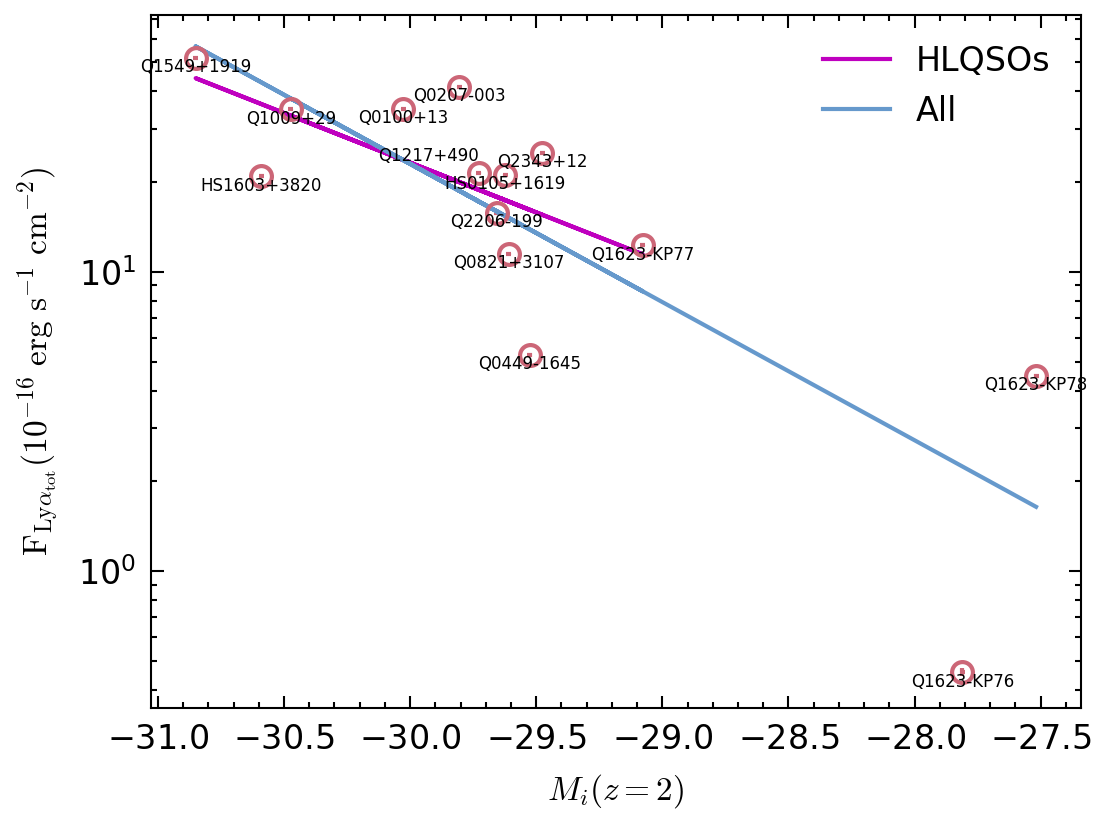

In [73]:
plt.style.use(["science",'no-latex'])
plt.rcParams.update({
    "font.family": "dejavu sans",   # specify font family here
    "font.serif": ["Times"],  # specify font here
    "font.size":8,
"legend.fancybox":True})
#Pub_filt=["sdss.up","sdss.gp","sdss.rp","sdss.ip","sdss.zp","WISE1","WISE2","WISE3","WISE4","2mass.J","2mass.H","2mass.Ks"]
colorlst=["#CC6677","#88CCEE","#6699CC"]
fig,axs=plt.subplots(figsize=(4,3),dpi=300)
fy=[]
fx=[]
fyerr=[]
#axs.errorbar(merged_set["MRs"],merged_set["Lyatot"]*0.1,xerr=merged_set["MRserr"],ms=1,lw=0.5,yerr=merged_set["Lyatoterr"]*0.1,fmt="^",label="KBSS-KCWI SFG")
exclude=["Q1623-KP78","Q1623-KP76"]
fyall=[]
fxall=[]
fyerrall=[]
metrics=line_total_flux
#metrics=inner_flux
#metrics=S_MAXSB
#metrics2=mstar_2
#metrics1=mstar_1
ms=5
photpath="/disk/bifrost/yuanze/KBSS/sedfit_master"
tfs=4
band="i"
qsos_bright = ascii.read(KBSSpath+"/KCWI/qsos_bright_updated_full.list",format="ipac")
for ind,id in enumerate(line_total_flux.keys()):
    #sourcename=re.findall(r"-(.*)",id)[0]
    sourcename=id
    if sourcename in S_MAXSB.keys():
        sentry=qsos_bright[qsos_bright["Name"]==sourcename]
        if sentry["contam"].value[0]=="True":
            continue
        fieldnow = sentry["Field"][0]
       # if fieldnow=="Q1442" or fieldnow=="Q1009":
      #      continue
        z = sentry["z_sys"][0]
        y = metrics[sourcename][0]#*(1+z)**2#/area[sourcename][2]*(1+z)**2
        yerr = metrics[sourcename][1]#*(1+z)**2#/area[sourcename][2]*(1+z)**2
        
        
        mu= 5.*np.log10(Planck18.luminosity_distance(sentry["z_sys"][0]).to(u.pc).value)-5 #distance modulus
        x = sentry[band][0]-mu
        if band=="i":
            try:
                x=sentry["Mi_z2"][0]
            except:
                mu= 5.*np.log10(Planck18.luminosity_distance(sentry["z_sys"][0]).to(u.pc).value)-5 #distance modulus
                x = sentry[band][0]-mu
        xerr = 0.01
        #if y<0.1:
        #    continue
        #print(sourcename,":",sentry[band][0],sentry["z_sys"][0])

        

        if sourcename in exclude:
            fyall.append(y)
            fxall.append(x)
            fyerrall.append(yerr)
        else:
            fy.append(y)
            fx.append(x)
            fyerr.append(yerr)
            fyall.append(y)
            fxall.append(x)
            fyerrall.append(yerr)
        
        axs.errorbar(x,y,xerr=xerr,yerr=yerr,fmt="o",mfc="None",ms=ms,color=colorlst[0])
        if sourcename=="Q1217+490":
            axs.text(x,y*1.1,sourcename,fontsize=tfs,horizontalalignment='right')#transform=axs.transAxes,verticalalignment='top',horizontalalignment='right',fontsize=7)
        else:
            axs.text(x,y,sourcename,fontsize=tfs,horizontalalignment='center',verticalalignment='top')#transform=axs.transAxes,verticalalignment='top',horizontalalignment='right',fontsize=7)

from matplotlib.lines import Line2D
#proxy_line1 = plt.plot([], [], marker="o",lw=0, mfc="None",ms=ms,color=colorlst[0], label="Type-1 AGN")
#proxy_line2 = plt.plot([], [], marker="o",lw=0, mfc="None",ms=ms,color=colorlst[1], label="Type-2 AGN")
#axs.legend()
axs.set_xlabel(r"$M_{ %s}(z=2)$"%band)
#axs.set_ylabel(r"$\rm(1+z)^{2} F_{Ly\alpha_{tot}} (10^{-16}~\rm erg~s^{-1}~cm^{-2})$")
axs.set_ylabel(r"$\rm F_{Ly\alpha_{tot}} (10^{-16}~\rm erg~s^{-1}~cm^{-2})$")

#axs.set_xscale
#axs.set_xlim([22,26])

axs.set_yscale("log")

resall=scipy.stats.linregress(fxall,np.log10(fyall))
res=scipy.stats.linregress(fx,np.log10(fy))

axs.plot(fx,10**(res.intercept+res.slope*np.array(fx)),"m",label="HLQSOs")

axs.plot(fxall,10**(resall.intercept+resall.slope*np.array(fxall)),color=colorlst[2],label="All")

#axs.set_yscale("log")
axs.legend(loc="best")

#axs.set_ylim([-1,10])
#axs.set_yticks([5e-2,1e-1,1,5,10,100])
#axs.set_yticklabels([r"5$\times10^{-2}$",r"10$^{-1}$","1","5","10","100"])


print(scipy.stats.pearsonr(fx,np.log10(fy)))
print(res.slope/-2.5,r"+-",res.stderr/2.5)

print(scipy.stats.pearsonr(fxall,np.log10(fyall)))
print(resall.slope/-2.5,r"+-",resall.stderr/2.5)

#axs.set_xscale("symlog")
fig.savefig(KBSSpath+"/fig/Lya_Mi_HLQSOs.pdf")

In [235]:
tname="Q0207-003"
line_total_flux[tname][0],area[tname][2],line_total_flux[tname][0]/area[tname][2]

(41.46862, 19802, 0.002094163231001564)

In [258]:
1215.67*(1+z)*u.AA

<Quantity 4394.403916 Angstrom>

In [252]:
Lyaneb_B16=np.array([1.97e44,3.41e43,1.82e44,3.93e44,1.08e44,\
            4.29e44,8.64e43,9.43e43,1.12e44,3.36e43,\
            5.85e43,1.64e44,1.3e44,4.24e44,4.24e43,\
            1.1e44, 2.36e43,5.15e44,1.37e44])
Miz2_B16=-np.array([30.22,28.42,28.23,29.52,28.92,\
                    28.98,28.81,28.82,28.91,29.24,\
                    28.69,30.12,28.86,29.36,29.51,\
                    29.95,28.98,30.35,29.77])

Lyaneb_M21=np.array([2.24e43,1.77e44,1.94e43,3.44e42,9.54e42,1.79e44,7.42e42,2.83e43,5.87e43,9.96e42,1.71e43,1.34e43])
Miz2_M21=-np.array([27.13,27.11,26.48,26.18,25.89,25.71,25.34,25.13,25.09,24.88,24.67,23.78])

PearsonRResult(statistic=-0.6263770515216085, pvalue=0.029311738611632776)
0.14552544307938453 +- 0.05727043510611043
PearsonRResult(statistic=-0.8102875552489124, pvalue=0.0004412074574926717)
0.19431893120103683 +- 0.040570187463138355


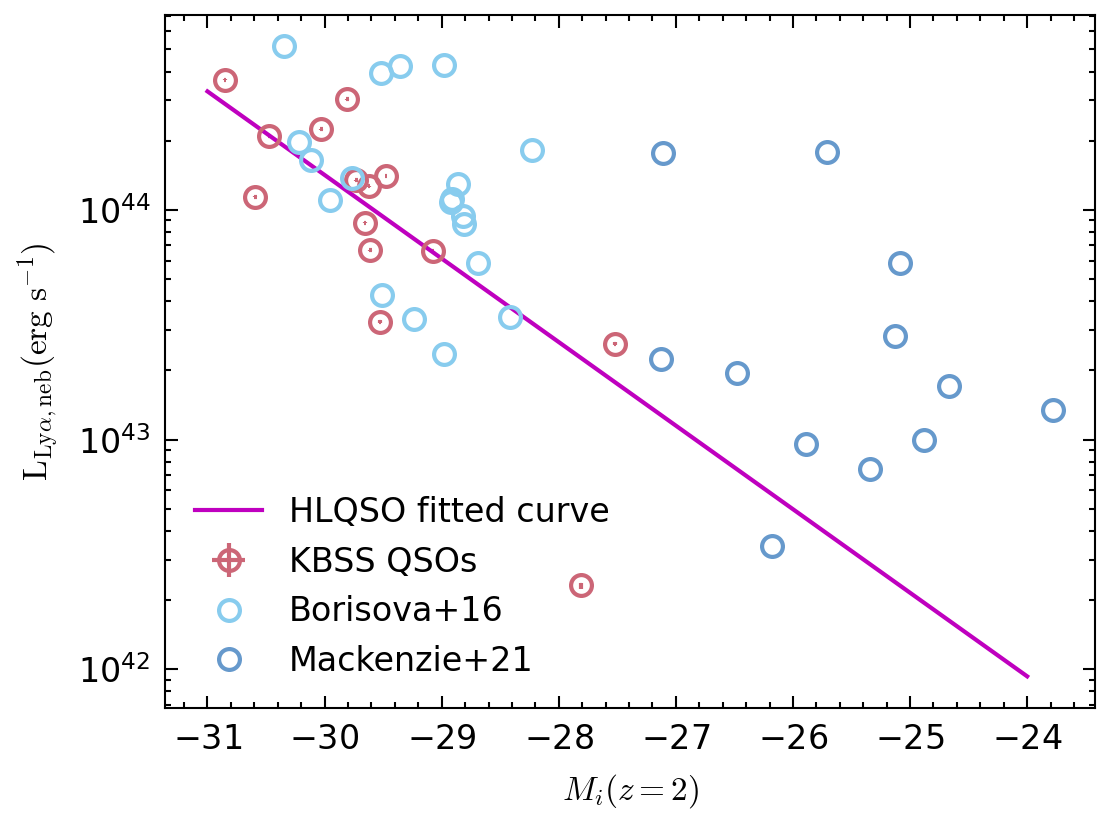

In [305]:
plt.style.use(["science",'no-latex'])
plt.rcParams.update({
    "font.family": "dejavu sans",   # specify font family here
    "font.serif": ["Times"],  # specify font here
    "font.size":8,
"legend.fancybox":True})
from dustmaps.sfd import SFDQuery
from dust_extinction.parameter_averages import G23

sfd = SFDQuery()
ext_model = G23(Rv=3.1)


#Pub_filt=["sdss.up","sdss.gp","sdss.rp","sdss.ip","sdss.zp","WISE1","WISE2","WISE3","WISE4","2mass.J","2mass.H","2mass.Ks"]
colorlst=["#CC6677","#88CCEE","#6699CC"]
fig,axs=plt.subplots(figsize=(4,3),dpi=300)
fy=[]
fx=[]
fyerr=[]
#axs.errorbar(merged_set["MRs"],merged_set["Lyatot"]*0.1,xerr=merged_set["MRserr"],ms=1,lw=0.5,yerr=merged_set["Lyatoterr"]*0.1,fmt="^",label="KBSS-KCWI SFG")
exclude=["Q1623-KP78","Q1623-KP76"]
fyall=[]
fxall=[]
fyerrall=[]
metrics=line_total_flux
#metrics=inner_flux
#metrics=S_MAXSB
#metrics2=mstar_2
#metrics1=mstar_1
ms=5
photpath="/disk/bifrost/yuanze/KBSS/sedfit_master"
tfs=4
band="i"
qsos_bright = ascii.read(KBSSpath+"/KCWI/qsos_bright_updated_full.list",format="ipac")
for ind,id in enumerate(line_total_flux.keys()):
    #sourcename=re.findall(r"-(.*)",id)[0]
    sourcename=id
    if sourcename in S_MAXSB.keys():
        sentry=qsos_bright[qsos_bright["Name"]==sourcename]
        if sentry["contam"].value[0]=="True":
            continue
        fieldnow = sentry["Field"][0]
        
        
       # if fieldnow=="Q1442" or fieldnow=="Q1009":
      #      continue
        z = sentry["z_sys"][0]
        sld=Planck18.luminosity_distance(z).to(u.cm).value**2*4*np.pi*1e-16
        
        #MW Dust extinction correction
        #sc = SkyCoord(ra=sentry["RA"][0], dec=sentry["Dec"][0], unit='deg',frame='icrs', equinox='J2000')
        #Av=sfd(sc)*2.742
        #Alam=ext_model(1215.67*(1+z)*u.AA)*Av
        
        
        y = metrics[sourcename][0]*sld#*10**(0.4*Alam)#*(1+z)**2/area[sourcename][2]*(1+z)**2
        yerr = metrics[sourcename][1]*sld#*10**(0.4*Alam)#*(1+z)**2/area[sourcename][2]*(1+z)**2
        
        
        #mu= 5.*np.log10(Planck18.luminosity_distance(sentry["z_sys"][0]).to(u.pc).value)-5 #distance modulus
        #x = sentry["Mi_z2"]#sentry[band][0]-mu
        if band=="i":
            try:
                x=sentry["Mi_z2"][0]
                #print("using Mi(z=2)")
            except:
                mu= 5.*np.log10(Planck18.luminosity_distance(sentry["z_sys"][0]).to(u.pc).value)-5 #distance modulus
                x = sentry[band][0]-mu
        xerr = 0.01
        #if y<0.1:
        #    continue
        #print(sourcename,":",sentry[band][0],sentry["z_sys"][0])

        

        if sourcename in exclude:
            fyall.append(y)
            fxall.append(x)
            fyerrall.append(yerr)
        else:
            fy.append(y)
            fx.append(x)
            fyerr.append(yerr)
            fyall.append(y)
            fxall.append(x)
            fyerrall.append(yerr)
        
        if ind==0:
            axs.errorbar(x,y,xerr=xerr,yerr=yerr,fmt="o",mfc="None",ms=ms,color=colorlst[0],label="KBSS QSOs")
        else:
            axs.errorbar(x,y,xerr=xerr,yerr=yerr,fmt="o",mfc="None",ms=ms,color=colorlst[0])
        #if sourcename=="Q1217+490":
        #    axs.text(x,y*1.1,sourcename,fontsize=tfs,horizontalalignment='right')#transform=axs.transAxes,verticalalignment='top',horizontalalignment='right',fontsize=7)
        #else:
        #    axs.text(x,y,sourcename,fontsize=tfs,horizontalalignment='center',verticalalignment='top')#transform=axs.transAxes,verticalalignment='top',horizontalalignment='right',fontsize=7)

axs.errorbar(Miz2_B16,Lyaneb_B16,fmt="o",mfc="None",ms=ms,color=colorlst[1],label="Borisova+16")
axs.errorbar(Miz2_M21,Lyaneb_M21,fmt="o",mfc="None",ms=ms,color=colorlst[2],label="Mackenzie+21")

from matplotlib.lines import Line2D
#proxy_line1 = plt.plot([], [], marker="o",lw=0, mfc="None",ms=ms,color=colorlst[0], label="Type-1 AGN")
#proxy_line2 = plt.plot([], [], marker="o",lw=0, mfc="None",ms=ms,color=colorlst[1], label="Type-2 AGN")
#axs.legend()
axs.set_xlabel(r"$M_{ %s}(z=2)$"%band)
#axs.set_ylabel(r"$\rm(1+z)^{2} F_{Ly\alpha_{tot}} (10^{-16}~\rm erg~s^{-1}~cm^{-2})$")
#axs.set_ylabel(r"$\rm F_{Ly\alpha_{tot}} (10^{-16}~\rm erg~s^{-1}~cm^{-2})$")

axs.set_ylabel(r"$\rm L_{Ly\alpha,neb} (erg~s^{-1})$")

#axs.set_xscale
#axs.set_xlim([22,26])

axs.set_yscale("log")

resall=scipy.stats.linregress(fxall,np.log10(fyall))
res=scipy.stats.linregress(fx,np.log10(fy))

xplot=np.linspace(-24,-31,100)
axs.plot(xplot,10**(res.intercept+res.slope*np.array(xplot)),"m",label="HLQSO fitted curve")

#axs.plot(fxall,10**(resall.intercept+resall.slope*np.array(fxall)),color=colorlst[2],label="All")

#axs.set_yscale("log")
axs.legend(loc="best",markerfirst=True)
#axs.invert_xaxis()
#axs.set_ylim([-1,10])
#axs.set_yticks([5e-2,1e-1,1,5,10,100])
#axs.set_yticklabels([r"5$\times10^{-2}$",r"10$^{-1}$","1","5","10","100"])


print(scipy.stats.pearsonr(fx,np.log10(fy)))
print(res.slope/-2.5,r"+-",res.stderr/2.5)

print(scipy.stats.pearsonr(fxall,np.log10(fyall)))
print(resall.slope/-2.5,r"+-",resall.stderr/2.5)

#axs.set_xscale("symlog")
#fig.savefig(KBSSpath+"/fig/Lya_Mi_all.pdf")

In [10]:
S=4*np.pi*Planck18.luminosity_distance(2.65).to(u.cm).value**2
FQSO=5e46/S
print(FQSO)
print(1e-15/FQSO)

8.322415351373716e-13
0.0012015742519206733


In [285]:
print(scipy.stats.pearsonr(tx,np.log10(ty)))


PearsonRResult(statistic=-0.6705936920521596, pvalue=4.6564249863312657e-07)


In [284]:
tx=np.append(np.append(fxall,Miz2_B16),Miz2_M21)
ty=np.append(np.append(fyall,Lyaneb_B16),Lyaneb_M21)

In [282]:
tx=np.append(fxall,Miz2_B16)
ty=np.append(fyall,Lyaneb_B16)

In [98]:
mu= 5.*np.log10(Planck18.luminosity_distance(2.28).to(u.pc).value)-5

In [15]:
(20*u.pc.to(u.cm))**3/(4/3*np.pi*(70*u.kpc.to(u.cm))**3)

5.568102965314122e-12

In [17]:
Nclump=4*np.pi*(70*u.kpc.to(u.cm))**2/(20*u.pc.to(u.cm))**2*1e-3
Fv=Nclump*(20*u.pc.to(u.cm))**3/(4/3*np.pi*(70*u.kpc.to(u.cm))**3)
print(Fv)

8.57142857142857e-07


PearsonRResult(statistic=0.6284157619244956, pvalue=0.01608873250127547)
2.4124486005310084 +- 0.8620484337559509


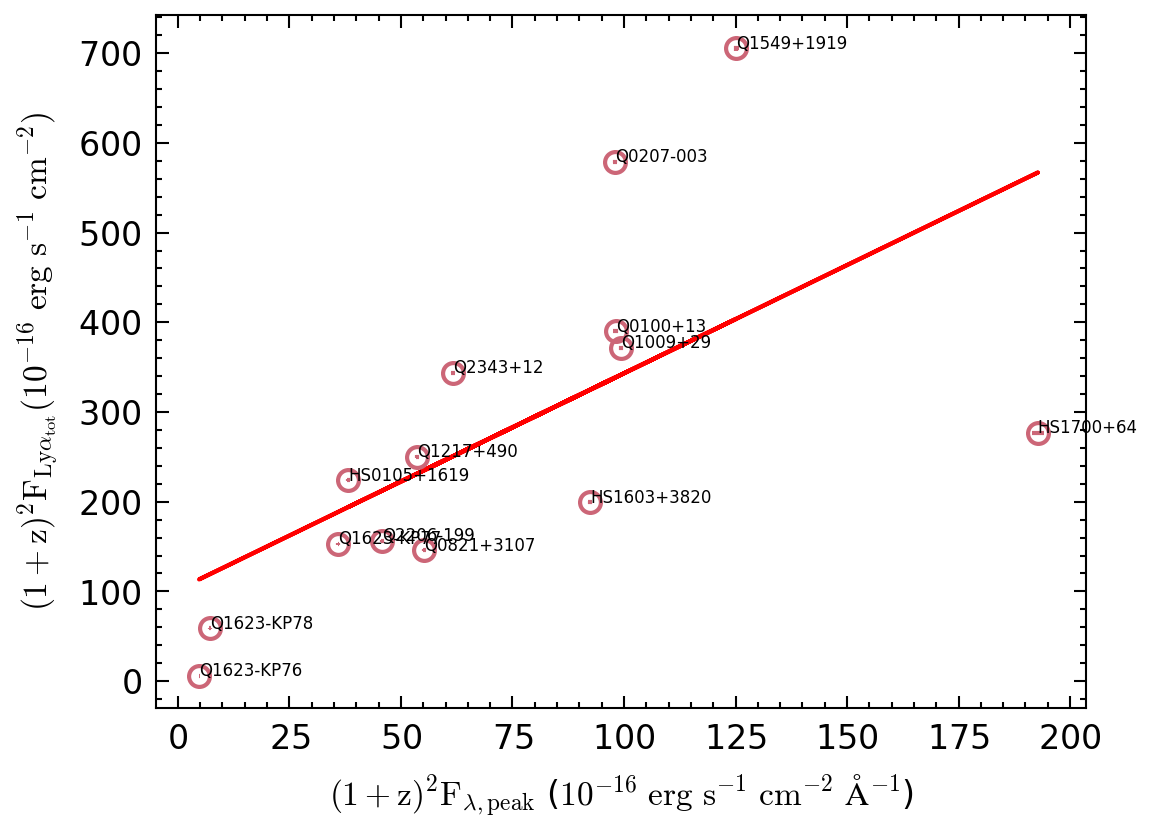

In [187]:
plt.style.use(["science",'no-latex'])
plt.rcParams.update({
    "font.family": "dejavu sans",   # specify font family here
    "font.serif": ["Times"],  # specify font here
    "font.size":8,
"legend.fancybox":True})
#Pub_filt=["sdss.up","sdss.gp","sdss.rp","sdss.ip","sdss.zp","WISE1","WISE2","WISE3","WISE4","2mass.J","2mass.H","2mass.Ks"]

fig,axs=plt.subplots(figsize=(4,3),dpi=300)

#axs.errorbar(merged_set["MRs"],merged_set["Lyatot"]*0.1,xerr=merged_set["MRserr"],ms=1,lw=0.5,yerr=merged_set["Lyatoterr"]*0.1,fmt="^",label="KBSS-KCWI SFG")
fy=[]
fx=[]
fyerr=[]

metrics=line_total_flux
#metrics=outer_flux
metrics1=S_MAXSB
ms=5
photpath="/disk/bifrost/yuanze/KBSS/sedfit_master"
tfs=4
#band="u"
for ind,id in enumerate(line_total_flux.keys()):
    #sourcename=re.findall(r"-(.*)",id)[0]
    sourcename=id
    if sourcename in S_MAXSB.keys():
        sentry=qsos_bright[qsos_bright["Name"]==sourcename]
        if sentry["contam"].value[0]=="True":
            continue
        fieldnow = sentry["Field"][0]
        z = sentry["z_sys"][0]
        
        y = metrics[sourcename][0]*(1+z)**2#/area[sourcename][1]*(1+z)**2
        yerr = metrics[sourcename][1]*(1+z)**2#/area[sourcename][1]*(1+z)**2
        
        
        mu= 5.*np.log10(Planck18.luminosity_distance(sentry["z_sys"][0]).to(u.pc).value)-5 #distance modulus
        x = metrics1[sourcename][0]*pixel_scale**2*(1+z)**2
        xerr = metrics1[sourcename][1]*pixel_scale**2*(1+z)**2

        fy.append(y)
        fx.append(x)
        fyerr.append(yerr)

        axs.errorbar(x,y,xerr=xerr,yerr=yerr,fmt="o",mfc="None",ms=ms,color=colorlst[0])
        axs.text(x,y,sourcename,fontsize=tfs)#transform=axs.transAxes,verticalalignment='top',horizontalalignment='right',fontsize=7)
            
from matplotlib.lines import Line2D
#proxy_line1 = plt.plot([], [], marker="o",lw=0, mfc="None",ms=ms,color=colorlst[0], label="Type-1 AGN")
#proxy_line2 = plt.plot([], [], marker="o",lw=0, mfc="None",ms=ms,color=colorlst[1], label="Type-2 AGN")
#axs.legend()
axs.set_xlabel(r"$\rm(1+z)^{2} F_{\lambda,peak}$ ($10^{-16}~\rm erg~s^{-1}~cm^{-2}~\AA^{-1}$)")
axs.set_ylabel(r"$\rm(1+z)^{2} F_{Ly\alpha_{tot}} (10^{-16}~\rm erg~s^{-1}~cm^{-2})$")
#axs.set_xscale
#axs.set_xlim([22,26])

#axs.set_yscale("log")

#axs.set_ylim([-1,10])
#axs.set_yticks([1e-2,1e-1,1,5,10])
#axs.set_yticklabels([r"10$^{-2}$",r"10$^{-1}$","1","5","10"])

res=scipy.stats.linregress(fx,fy)

axs.plot(fx,res.intercept+res.slope*np.array(fx),"r")

print(scipy.stats.pearsonr(fx,fy))
print(res.slope,r"+-",res.stderr)
#axs.set_xscale("symlog")
#fig.savefig(KBSSpath+"/fig/Lya_MRs_bright.pdf")

PearsonRResult(statistic=-0.9563120265352629, pvalue=9.133844775194598e-08)
0.17524623642147155 +- 0.015465304367128858


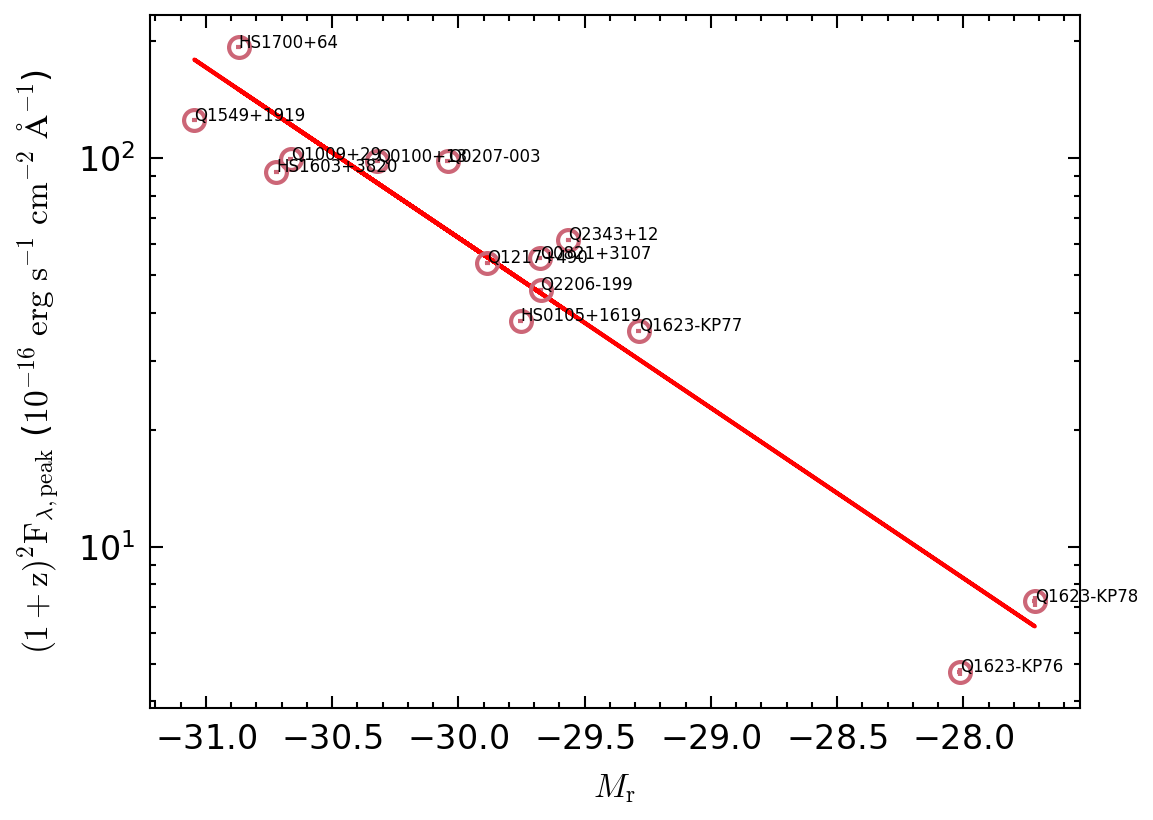

In [188]:
plt.style.use(["science",'no-latex'])
plt.rcParams.update({
    "font.family": "dejavu sans",   # specify font family here
    "font.serif": ["Times"],  # specify font here
    "font.size":8,
"legend.fancybox":True})
#Pub_filt=["sdss.up","sdss.gp","sdss.rp","sdss.ip","sdss.zp","WISE1","WISE2","WISE3","WISE4","2mass.J","2mass.H","2mass.Ks"]

fig,axs=plt.subplots(figsize=(4,3),dpi=300)

#axs.errorbar(merged_set["MRs"],merged_set["Lyatot"]*0.1,xerr=merged_set["MRserr"],ms=1,lw=0.5,yerr=merged_set["Lyatoterr"]*0.1,fmt="^",label="KBSS-KCWI SFG")

metrics=line_total_flux
#metrics2=mstar_2
metrics1=S_MAXSB
ms=5
photpath="/disk/bifrost/yuanze/KBSS/sedfit_master"
tfs=4
band="r"
fx=[]
fy=[]
fyerr=[]
for ind,id in enumerate(line_total_flux.keys()):
    #sourcename=re.findall(r"-(.*)",id)[0]
    sourcename=id
    if sourcename in S_MAXSB.keys():
        sentry=qsos_bright[qsos_bright["Name"]==sourcename]
        if sentry["contam"].value[0]=="True":
            continue
        fieldnow = sentry["Field"][0]
        z = sentry["z_sys"][0]
        y = metrics1[sourcename][0]*pixel_scale**2*(1+z)**2
        yerr = metrics1[sourcename][1]*pixel_scale**2*(1+z)**2
        
        
        mu= 5.*np.log10(Planck18.luminosity_distance(sentry["z_sys"][0]).to(u.pc).value)-5 #distance modulus
        x = sentry[band][0]-mu
        xerr = 0.01

        fy.append(y)
        fx.append(x)
        fyerr.append(yerr)
        axs.errorbar(x,y,xerr=xerr,yerr=yerr,fmt="o",mfc="None",ms=ms,color=colorlst[0])
        axs.text(x,y,sourcename,fontsize=tfs)#transform=axs.transAxes,verticalalignment='top',horizontalalignment='right',fontsize=7)


from matplotlib.lines import Line2D
#proxy_line1 = plt.plot([], [], marker="o",lw=0, mfc="None",ms=ms,color=colorlst[0], label="Type-1 AGN")
#proxy_line2 = plt.plot([], [], marker="o",lw=0, mfc="None",ms=ms,color=colorlst[1], label="Type-2 AGN")
#axs.legend()
axs.set_ylabel(r"$\rm(1+z)^{2} F_{\lambda,peak}$ ($10^{-16}~\rm erg~s^{-1}~cm^{-2}~\AA^{-1}$)")
axs.set_xlabel(r"$M_{\rm %s}$"%band)
#axs.set_ylabel(r"Ly$\alpha_{tot} (10^{-16}~\rm erg~s^{-1}~cm^{-2})$")
#axs.set_xscale
#axs.set_xlim([22,26])



res=scipy.stats.linregress(fx,np.log10(fy))

axs.plot(fx,10**(res.intercept+res.slope*np.array(fx)),"r")
axs.set_yscale("log")

#axs.set_ylim([-1,10])
#axs.set_yticks([1e-2,1e-1,1,5,10])
#axs.set_yticklabels([r"10$^{-2}$",r"10$^{-1}$","1","5","10"])


print(scipy.stats.pearsonr(fx,np.log10(fy)))
print(res.slope/-2.5,r"+-",res.stderr/2.5)
#axs.set_xscale("symlog")
#fig.savefig(KBSSpath+"/fig/Lya_MRs.pdf")

## extract and organize MUSE QSO data

In [194]:
MUSEQSO= ascii.read(KBSSpath+"/KCWI/MUSEQSO_1.list",format="ipac")

In [203]:
np.savetxt(KBSSpath+"/KCWI/MUSEsource.list",np.array([MUSEQSO["R.A."].value,MUSEQSO["Decl."].value]).T,fmt="%s")

In [211]:
import xml.etree.ElementTree as ET

# Parse the XML file
tree = ET.parse(KBSSpath+"/MUSEQSO/ESO_export.xml")
root = tree.getroot()

# Namespace dictionary to handle the VOTable namespace
ns = {'v': 'http://www.ivoa.net/xml/VOTable/v1.3'}

# Iterate over all FIELD elements
for field in root.findall('.//v:FIELD', ns):
    if 'datatype' not in field.attrib or not field.attrib['datatype']:
        field.set('datatype', 'char')  # Set a default datatype, e.g., 'char'

# Save the modified XML to a new file
tree.write('fixed_file.xml')

# Now read the fixed file using astropy
from astropy.io.votable import parse

try:
    votable = parse('fixed_file.xml')
    table = votable.get_first_table()
    from astropy.table import Table
    astropy_table = Table(table.array)
    print(astropy_table)
except Exception as e:
    print(f"Error: {e}")

              access_format                ... visible
------------------------------------------ ... -------
application/x-votable+xml;content=datalink ...       t
application/x-votable+xml;content=datalink ...       t
application/x-votable+xml;content=datalink ...       t
application/x-votable+xml;content=datalink ...       t
application/x-votable+xml;content=datalink ...       t
application/x-votable+xml;content=datalink ...       t
application/x-votable+xml;content=datalink ...       t
application/x-votable+xml;content=datalink ...       t
application/x-votable+xml;content=datalink ...       t
application/x-votable+xml;content=datalink ...       t
                                       ... ...     ...
application/x-votable+xml;content=datalink ...       t
application/x-votable+xml;content=datalink ...       t
application/x-votable+xml;content=datalink ...       t
application/x-votable+xml;content=datalink ...       t
application/x-votable+xml;content=datalink ...       t
applicatio

In [265]:
import shutil
museqso_path = os.path.join(KBSSpath, "MUSEQSO")
votable_file = os.path.join("fixed_file.xml")
# Parse the VOTable file
votable = parse(votable_file)
table = votable.get_first_table()
astropy_table = Table(table.array)

# Extract 'dp_id' and 'obj' columns
dp_id_col = astropy_table['dp_id']
obj_col = astropy_table['obj']

# Create a dictionary to map dp_id to object name
dp_id_to_obj = dict(zip(dp_id_col, obj_col))

# Get all files in the directory
all_files = os.listdir(museqso_path)

# Extract base names (without extensions)
base_names = set(os.path.splitext(f)[0] for f in all_files)
'''
# Loop through each unique base name
for base_name in base_names:
    # Find the corresponding object name
    obj_name = dp_id_to_obj.get(base_name)
    
    if obj_name:
        # Create the directory for the object if it doesn't exist
        obj_dir = os.path.join(museqso_path, obj_name)
        os.makedirs(obj_dir, exist_ok=True)
        
        # Find all files with the current base name and move them
        matching_files = [f for f in all_files if os.path.splitext(f)[0] == base_name]
        for file_name in matching_files:
            src_path = os.path.join(museqso_path, file_name)
            dst_path = os.path.join(obj_dir, file_name)
            shutil.move(src_path, dst_path)
            print(f"Moved {file_name} to {obj_dir}")

print("File organization complete.")
'''

['UM24', 'CTS_A11.09', 'ESO_export.csv', 'SDSSJ1209+1138', 'ESO_export.xml', 'FBQS J2334-0908', 'J0124+0044', 'UM672', 'BRI 1108-0747', 'CTS_G18.01', 'QSO J1621-0042', 'LBQS 2139-4434', 'PKS 1017+109', 'UM683', 'PKS1937-101', 'Q0041-2638', 'Q0042-2627', 'Q0055-269', 'Q 0956+122', 'Q1317-0507', 'QB2000-330', 'SDSSJ1243+0720', 'SDSSJ1032+1206', 'CTS_A31.05', 'SDSSJ1557+1540', 'UM679', 'Q-0347-383', 'Q-2204-408', 'TEX1033+137', 'SDSSJ1019+0254', 'SDSSJ1427-0029', 'SDSSJ0819+0823', 'SDSSJ0001-0956', 'SDSSJ1307+1230', 'SDSSJ1429-0145', 'CTSH22.05', 'UM670', 'SDSSJ1550+0537', 'CT_656', 'SDSSJ0154-0730', 'SDSSJ2321+1558', 'Q-0058-292', 'SDSSJ1342+1702', 'Q-0052-3901A', 'Q-0042-269', 'UM678', 'LBQS1209+1524', 'Q-N1097.1', 'SDSSJ0219-0215', 'SDSSJ0905+0410', 'UM669', 'Q-0115-30', 'SDSSJ0814+1950', 'CT-669', 'Q-0140-306', '6dFJ0032-0414', 'PKS0537-286', 'SDSSJ0100+2105', 'Q-0057-3948', 'Q-2348-4025', 'LBQS1244+1129', 'SDSSJ0947+1421', 'SDSSJ1057-0139', 'J0525-233', 'SDSSJ2100-0641', 'SDSSJ0817+1

In [317]:
MUSEQSO= ascii.read(KBSSpath+"/KCWI/MUSEQSO_machine_readable.list",format="ipac")

In [318]:
from astropy.table import Table, Column
# Get a list of folders in the museqso_path
folders = [f for f in os.listdir(museqso_path) if os.path.isdir(os.path.join(museqso_path, f))]


# Create lists to store the 'found_in_folder' and 'file_count' information
found_in_folder = []
file_count = []

# Loop through the objects in the astropy_table to check folder presence and count files
for obj in MUSEQSO['Quasar']:
    if obj in folders:
        found_in_folder.append(True)
        folder_path = os.path.join(museqso_path, obj)
        num_files = len([f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))])
        file_count.append(num_files)
    else:
        found_in_folder.append(False)
        file_count.append(0)

# Add the new columns to the table
MUSEQSO.add_column(Column(name='found_in_folder', data=found_in_folder))
MUSEQSO.add_column(Column(name='file_count', data=file_count))

# Print the updated table to check the new columns
print(MUSEQSO)


 ID       Quasar         R.A.     ... Class found_in_folder file_count
unit       unit          unit     ...  unit                           
---- --------------- ------------ ... ----- --------------- ----------
   1  SDSSJ2319-1040 23:19:34.800 ...    RQ            True          1
   2            UM24 00:15:27.400 ...    RQ            True          1
   3       J0525-233 05:25:06.500 ...    RL            True          1
   4      Q-0347-383 03:49:43.700 ...    RQ            True          2
   5  SDSSJ0817+1053 08:17:52.099 ...    RQ            True          1
   6  SDSSJ0947+1421 09:47:34.200 ...    RQ            True          1
   7  SDSSJ1209+1138 12:09:18.000 ...    RQ            True          1
   8           UM683 03:36:26.900 ...    RQ            True          1
   9      Q 0956+122 09:58:52.200 ...    RQ            True          1
  10 SDSSJ10251+0452 10:25:09.600 ...    RQ            True          1
 ...             ...          ... ...   ...             ...        ...
  71  

In [306]:
import pandas as pd
from astropy.table import Table, Column
import shlex
MUSEQSO_updated= ascii.read(KBSSpath+"/MUSEQSO/meta/MUSEQSO_machine_readable_updated.list",format="ipac")
Borisova16=pd.read_csv(KBSSpath+"/MUSEQSO/meta/Borisova16_fixed.csv",index_col=0)
QSOMUSEUM=pd.read_csv(KBSSpath+"/MUSEQSO/meta/QSOMUSEUM_fixed.csv",index_col=0)

In [307]:
from astropy.table import Table, Column
import shlex

iAB=[]
Mi=[]
Mi2=[]
cutout = []
cutout_Name=["LBQS 2139-4434"]
withabs = []
withabs_Name=["CTS_A31.05","CTS-C22.31","FBQS J2334-0908","Q-0042-269","Q-0057-3948"\
             ,"Q0042-2627","SDSSJ0905+0410","SDSSJ1032+1206","SDSSJ1243+0720","SDSSJ1337+0218"\
             ,"SDSSJ1427-0029","SDSSJ1429-0145","SDSSJ1550+0537","SDSSJ1557+1540"\
             ,"SDSSJ2100-0641"]
for obj in MUSEQSO_updated['Quasar']:
    if obj in QSOMUSEUM['Name'].values:
        tab=QSOMUSEUM
        cite='Name'
    else:
        tab=Borisova16
        cite='Quasar'
    #quoted_obj=shlex.quote(obj)
    sentry=tab[tab[cite]==obj]
    if obj in cutout_Name:
        cutout.append(True)
    else:
        cutout.append(False)
    if obj in withabs_Name:
        withabs.append(True)
    else:
        withabs.append(False)
    iAB.append(sentry["i_AB"].values[0])
    mu= 5.*np.log10(Planck18.luminosity_distance(sentry["z_sys"].values[0]).to(u.pc).value/10) #distance modulus
    Mi.append(iAB[-1]-mu)
    Mi2.append(iAB[-1]-mu-(Kcorr(sentry["z_sys"].values[0])))

MUSEQSO_updated.add_column(Column(name='i_AB', data=iAB))
MUSEQSO_updated.add_column(Column(name='M_i', data=Mi))
MUSEQSO_updated.add_column(Column(name='M_i_z2', data=Mi2))
MUSEQSO_updated.add_column(Column(name='cutout', data=cutout))
MUSEQSO_updated.add_column(Column(name='withabs', data=withabs))
print(MUSEQSO_updated)


 ID       Quasar          RA      ...        M_i_z2       cutout withabs
unit       unit          unit     ...                                   
---- --------------- ------------ ... ------------------- ------ -------
   1  SDSSJ2319-1040 23:19:34.800 ... -28.659580597576685  False   False
   2            UM24 00:15:27.400 ... -29.733236031614545  False   False
   3       J0525-233 05:25:06.500 ...  -29.09096927963563  False   False
   4      Q-0347-383 03:49:43.700 ... -29.229721276032894  False   False
   5  SDSSJ0817+1053 08:17:52.099 ... -28.864712756974267  False   False
   6  SDSSJ0947+1421 09:47:34.200 ...  -29.71266860800186  False   False
   7  SDSSJ1209+1138 12:09:18.000 ... -29.174718292114616  False   False
   8           UM683 03:36:26.900 ... -28.222705759306688  False   False
   9      Q 0956+122 09:58:52.200 ...  -29.44692392241976  False   False
  10 SDSSJ10251+0452 10:25:09.600 ...  -28.94456846060454  False   False
 ...             ...          ... ...              

In [308]:
ascii.write(MUSEQSO_updated,KBSSpath+"/MUSEQSO/MUSEQSO_machine_readable_updated2_withMi2.list",format="ipac",overwrite=True)

In [309]:
MUSEQSO_updated

ID,Quasar,RA,Decl,Seeing,z_sys,z_Lyaneb,EXPT,L_Lya,M_BH,L_bol,Class,found_in_folder,file_count,i_AB,M_i,M_i_z2,cutout,withabs
unit,unit,unit,unit,unit,unit,unit,unit,unit,unit,unit,unit,,,,,,,
str2,str15,str12,str12,float64,float64,float64,float64,float64,float64,float64,str2,str4,int64,float64,float64,float64,bool,bool
1,SDSSJ2319-1040,23:19:34.800,-10:40:36.00,1.4,3.166,3.171,42.44,1.53,0.87,1.27,RQ,True,1,18.17,-29.046380597576686,-28.659580597576685,False,False
2,UM24,00:15:27.400,+06:40:12.00,1.62,3.133,3.165,42.29,2.82,6.05,3.77,RQ,True,1,17.08,-30.109136031614547,-29.733236031614545,False,False
3,J0525-233,05:25:06.500,-23:38:10.00,0.86,3.11,3.119,42.88,1.29,1.86,2.18,RL,True,1,17.71,-29.45996927963563,-29.09096927963563,False,False
4,Q-0347-383,03:49:43.700,-38:10:31.00,1.4,3.219,3.231,84.71,2.06,4.57,2.54,RQ,True,2,17.63,-29.629521276032893,-29.229721276032894,False,False
5,SDSSJ0817+1053,08:17:52.099,+10:53:29.68,1.47,3.32,3.332,42.44,3.18,3.25,1.87,RQ,True,1,18.08,-29.259712756974267,-28.864712756974267,False,False
6,SDSSJ0947+1421,09:47:34.200,+14:21:17.00,1.21,3.029,3.069,42.27,0.64,7.96,3.46,RQ,True,1,17.04,-30.06126860800186,-29.71266860800186,False,False
7,SDSSJ1209+1138,12:09:18.000,+11:38:31.00,1.22,3.117,3.118,42.23,1.89,2.15,2.45,RQ,True,1,17.63,-29.545818292114614,-29.174718292114616,False,False
8,UM683,03:36:26.900,-20:19:39.00,1.05,3.132,3.132,85.02,4.45,0.44,1.27,RQ,True,1,18.59,-28.598305759306687,-28.222705759306688,False,False


In [208]:
from scipy import interpolate
Kcorr_tab=np.genfromtxt(KBSSpath+"/Kcorr_org.csv",delimiter=" ")

Kcorr=interpolate.interp1d(Kcorr_tab[:,0],Kcorr_tab[:,1],fill_value="extrapolate")

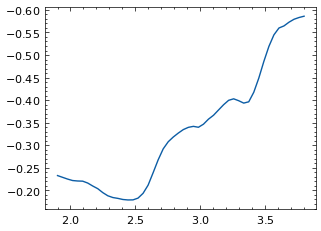

In [209]:
zrange=np.linspace(1.9,3.8)
plt.plot(zrange,Kcorr(zrange))
plt.gca().invert_yaxis()

In [220]:
qsos_bright = ascii.read(KBSSpath+"/KCWI/qsos_bright.kcwi",format="ipac")
Mi=[]
Mi2=[]
z_Lyaneb=[]
for sentry in qsos_bright:
    iAB=sentry["i"]
    mu= 5.*np.log10(Planck18.luminosity_distance(sentry["z_sys"]).to(u.pc).value)-5 #distance modulus
    Mi.append(iAB-mu)
    Mi2.append(iAB-mu-Kcorr(sentry["z_sys"]))
    z_Lyaneb.append(sentry["z_sys"])
qsos_bright.add_column(Column(name='Mi', data=Mi))
qsos_bright.add_column(Column(name='z_Lyaneb', data=z_Lyaneb))
qsos_bright.add_column(Column(name='Mi_z2', data=Mi2))


In [221]:
#ascii.write(qsos_bright,KBSSpath+"/KCWI/qsos_bright_updated_full.list",format="ipac",overwrite=True)

In [222]:
qsos_bright

Name,Field,RA,Dec,x,y,EBV,z_simbad,z_sys,zerr,contam,u,g,r,i,z,MB,Comments,Mi,z_Lyaneb,Mi_z2
unit,unit,unit,unit,unit,unit,unit,unit,unit,unit,unit,unit,unit,unit,unit,unit,unit,unit,,,
str11,str5,float64,float64,float64,float64,float64,float64,float64,float64,str5,float64,float64,float64,float64,float64,float64,str71,float64,float64,float64
Q0100+13,Q0100,15.797,13.272,50.46,50.41,0.031,2.686,2.721,0.001,False,17.4,16.7,16.5,16.5,--,-26.4472,--,-30.321267391475878,2.721,-30.025767391475878
HS0105+1619,Q0105,17.027,16.597,52.31,53.45,0.058,2.64,2.652,0.001,False,18.1,17.19,17.0,16.87,16.67,--,--,-29.88400104644006,2.652,-29.63340104644006
Q0142-10,Q0142,26.319,-9.755,55.86,54.4,0.028,2.7312,2.743,0.001,True,17.54,16.85,16.73,16.64,16.6,-26.1957,lensed QSO,-30.202340819256555,2.743,-29.897440819256555
Q0207-003,Q0207,32.461,-0.085,49.95,50.93,0.024,2.85,2.872,0.001,False,18.08,17.02,16.92,16.84,16.76,--,--,-30.122461538584293,2.872,-29.787261538584293
Q0449-1645,Q0449,73.06,-15.329,52.06,51.32,0.046,2.6,2.6825,0.001,False,18.25,17.25,17.08,16.98,--,--,i-band apparent magnitude is estimated to be 17.00,-29.803957307377825,2.6825,-29.531207307377827
Q0821+3107,Q0821,125.282,31.131,54.68,52.86,0.039,2.624,2.616,0.001,False,18.08,17.26,17.04,16.87,16.66,--,--,-29.848176827459962,2.616,-29.623976827459963
Q1009+29,Q1009,152.982,29.695,48.79,48.47,0.023,2.62,2.652,0.001,False,16.73,16.16,16.09,16.02,15.89,-26.7954,--,-30.73400104644006,2.652,-30.48340104644006
Q1217+490,Q1217,184.879,49.681,47.9,43.83,0.015,2.698,2.704,0.001,False,17.77,17.09,16.92,16.79,16.7,-25.9884,--,-30.01486119098076,2.704,-29.72846119098076


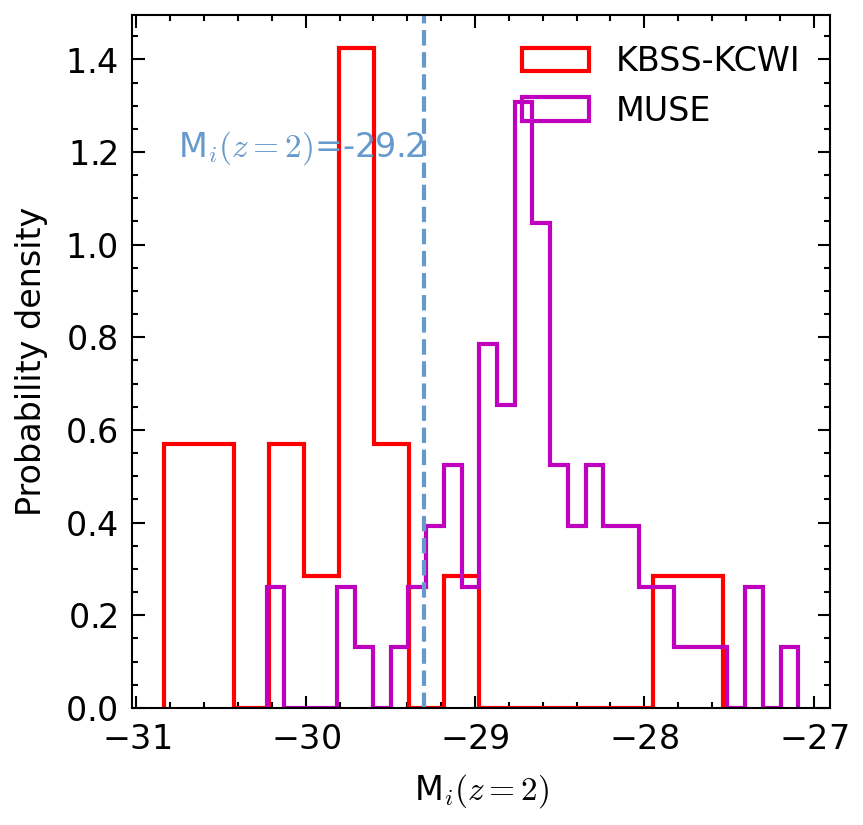

In [223]:
fig =  plt.figure(figsize = (3,3),dpi=300)
ax = plt.subplot()
colorlst=["#CC6677","#DDCC77","#6699CC"]
ax.hist(qsos_bright["Mi_z2"], histtype='step',bins=16,edgecolor="red",fill=False,density=True,label="KBSS-KCWI")
ax.hist(MUSEQSO_updated[MUSEQSO_updated['z_sys']<3.5]["M_i_z2"].data, histtype='step',bins=30,edgecolor="m",fill=False,density=True,label="MUSE")
ax.set_ylabel("Probability density")
#ax.set_ylabel("number of sources")
ax.text(-29.3,1.25,r"M$_{i}(z=2)$=-29.2",ha="right",va="top",color=colorlst[2])
ax.set_xlabel(r"M$_{i}(z=2)$")
ax.legend()
ax.axvline(-29.3,ls="--",color=colorlst[2])
fig.savefig(KBSSpath+"/fig/sample_zcorr.pdf")

In [218]:
MUSEQSO_updated[MUSEQSO_updated["M_i_z2"]<-29.2]

ID,Quasar,RA,Decl,Seeing,z_sys,z_Lyaneb,EXPT,L_Lya,M_BH,L_bol,Class,found_in_folder,file_count,i_AB,M_i,M_i_z2,cutout
unit,unit,unit,unit,unit,unit,unit,unit,unit,unit,unit,unit,,,,,,
str2,str15,str12,str12,float64,float64,float64,float64,float64,float64,float64,str2,str4,int64,float64,float64,float64,bool
2,UM24,00:15:27.400,+06:40:12.00,1.62,3.133,3.165,42.29,2.82,6.05,3.77,RQ,True,1,17.08,-30.109136031614547,-29.733236031614545,False
4,Q-0347-383,03:49:43.700,-38:10:31.00,1.4,3.219,3.231,84.71,2.06,4.57,2.54,RQ,True,2,17.63,-29.629521276032893,-29.229721276032894,False
6,SDSSJ0947+1421,09:47:34.200,+14:21:17.00,1.21,3.029,3.069,42.27,0.64,7.96,3.46,RQ,True,1,17.04,-30.06126860800186,-29.71266860800186,False
9,Q 0956+122,09:58:52.200,+12:02:45.00,1.12,3.301,3.311,42.25,9.33,3.64,3.22,RQ,True,1,17.48,-29.84482392241976,-29.44692392241976,False
19,SDSSJ1307+1230,13:07:10.200,+12:30:21.00,0.89,3.188,3.225,42.25,1.84,6.27,2.34,RQ,True,1,17.58,-29.654379101339202,-29.261979101339204,False
26,Q-2204-408,22:07:34.300,-40:36:57.00,0.84,3.181,3.185,42.35,11.16,10.11,3.72,-,True,1,17.17,-30.058666436570633,-29.668366436570633,False
46,Q2355+0108,23:58:08.540,+01:25:07.20,1.23,3.385,3.398,42.19,1.91,3.93,2.52,RQ,True,1,17.61,-29.77998207499723,-29.37898207499723,False
62,CTS_G18.01,00:41:31.4,-49:36:11.9,1.08,3.207,3.249,48.32,3.78,5.41,3.95,RQ,True,1,16.621,-30.62881899665722,-30.23141899665722,False


### MUSE astrometry realignment
this may not be necessary, I found the reduced cube's astrometry being quite good
Some of the sources are having large offset in the cited coordinates, which are not appear to be correct. I have corrected them according to NED values.
['/disk/bifrost/yuanze/KBSS/MUSEQSO/SDSSJ2100-0641', '/disk/bifrost/yuanze/KBSS/MUSEQSO/LBQS 2139-4434', '/disk/bifrost/yuanze/KBSS/MUSEQSO/Q-0057-3948', '/disk/bifrost/yuanze/KBSS/MUSEQSO/Q0042-2627', '/disk/bifrost/yuanze/KBSS/MUSEQSO/CTS_B27.07', '/disk/bifrost/yuanze/KBSS/MUSEQSO/CT_656', '/disk/bifrost/yuanze/KBSS/MUSEQSO/CTS_R07.04']
SDSSJ2100-0641 and Q-0057-3948 are manually centroid

In [55]:
sys.path.append('/disk/bifrost/yuanze/KBSS/MUSEQSO')
import run_cubetools_MUSE as ctools
qname="LBQS 2139-4434"
adp_file=ctools.find_adp_fits_file(KBSSpath+f"/MUSEQSO/{qname}")
hdu1=fits.open(f"{adp_file}.fits")
#hdu2=fits.open(KBSSpath+"/MUSEQSO/Q-0347-383/ADP.2016-06-02T13:21:57.103.fits")

In [56]:
wimage=np.nansum(hdu1[1].data,axis=0)

In [57]:
from astroquery.gaia import Gaia
from astroquery.sdss import SDSS
from photutils.detection import DAOStarFinder
from astropy.visualization import ZScaleInterval, ImageNormalize




# Identify sources in the image
data=wimage
old_wcs=WCS(hdu1[1].header).celestial
mean, median, std = sigma_clipped_stats(data, sigma=3.0)
daofind = DAOStarFinder(fwhm=3.0, threshold=5.*std)
sources = daofind(data - median)
positions = np.transpose((sources['xcentroid'], sources['ycentroid']))
catalog = SkyCoord.from_pixel(positions[:,0], positions[:,1], wcs=old_wcs)

# Query Gaia or SDSS catalog
# For Gaia:
Gaia.MAIN_GAIA_TABLE = "gaiaedr3.gaia_source"  # Specify the Gaia catalog version
radius = 0.5 * u.deg  # Adjust as necessary
center = catalog[0]  # Using the first source as the center, adjust as necessary

result = Gaia.query_object_async(coordinate=center, radius=radius)
gaia_coords = SkyCoord(result['ra'], result['dec'], unit='deg')


# Cross-match sources
idx, d2d, _ = gaia_coords.match_to_catalog_sky(catalog)
'''

# Query SDSS catalog
radius = 0.1 * u.deg  # Adjust as necessary
center = catalog[0]  # Using the first source as the center, adjust as necessary

query = SDSS.query_region(center, radius=radius, spectro=False, photoobj_fields=['ra', 'dec'])
sdss_coords = SkyCoord(query['ra'], query['dec'], unit='deg')

idx, d2d, _ = sdss_coords.match_to_catalog_sky(catalog)

'''

# Filter matches by a tolerance
tol = 10 * u.arcsec  # Adjust as necessary
matches = d2d < tol
matched_catalog = catalog[idx[matches]]
matched_gaia = gaia_coords[matches]

# Compute the WCS transformation
from astropy.wcs.utils import fit_wcs_from_points


matchedra=matched_gaia.ra
matcheddec=matched_gaia.dec
xp=positions[idx[matches]][:,0]
yp=positions[idx[matches]][:,1]


INFO: Query finished. [astroquery.utils.tap.core]


In [58]:
new_wcs = fit_wcs_from_points((xp,yp), SkyCoord(ra=matchedra,dec=matcheddec,unit=u.deg), projection=old_wcs)

In [59]:
SkyCoord(ra=matchedra,dec=matcheddec,unit=u.deg).to_string('hmsdms')

['21h42m25.86611106s -44d21m11.05158972s',
 '21h42m28.58670913s -44d21m01.64224005s',
 '21h42m24.8093216s -44d20m21.36279082s',
 '21h42m25.78447122s -44d20m18.3526906s',
 '21h42m20.84190506s -44d20m30.34643917s',
 '21h42m27.42355048s -44d20m04.98862576s',
 '21h42m30.45595291s -44d20m32.27545843s',
 '21h42m28.13589729s -44d20m00.88425859s',
 '21h42m26.6273206s -44d19m38.89568972s',
 '21h42m23.0499286s -44d19m33.44737684s',
 '21h42m22.17182536s -44d19m29.85029213s',
 '21h42m18.62089268s -44d19m42.23870419s',
 '21h42m17.34712787s -44d19m51.74991881s',
 '21h42m20.50624346s -44d19m10.95872488s',
 '21h42m25.34185483s -44d19m00.81337575s',
 '21h42m22.64093288s -44d19m01.68369177s',
 '21h42m21.28850515s -44d18m57.6894958s',
 '21h42m26.41693539s -44d18m46.1456255s']

In [304]:
9200/2000

4.6

In [51]:
#s_coord=SkyCoord("11:13:50.1  -15:33:40.2",unit=(u.hourangle,u.deg))
#s_coord=SkyCoord(hdu1[1].header["CRVAL1"],hdu1[1].header["CRVAL2"],unit=(u.deg,u.deg))
ra,dec="00:44:33.96","-26:11:20.74"
s_coord=SkyCoord(ra=ra, dec=dec,unit=(u.hourangle,u.deg))
print(s_coord.to_pixel(old_wcs))

(array(190.31401145), array(394.79539141))


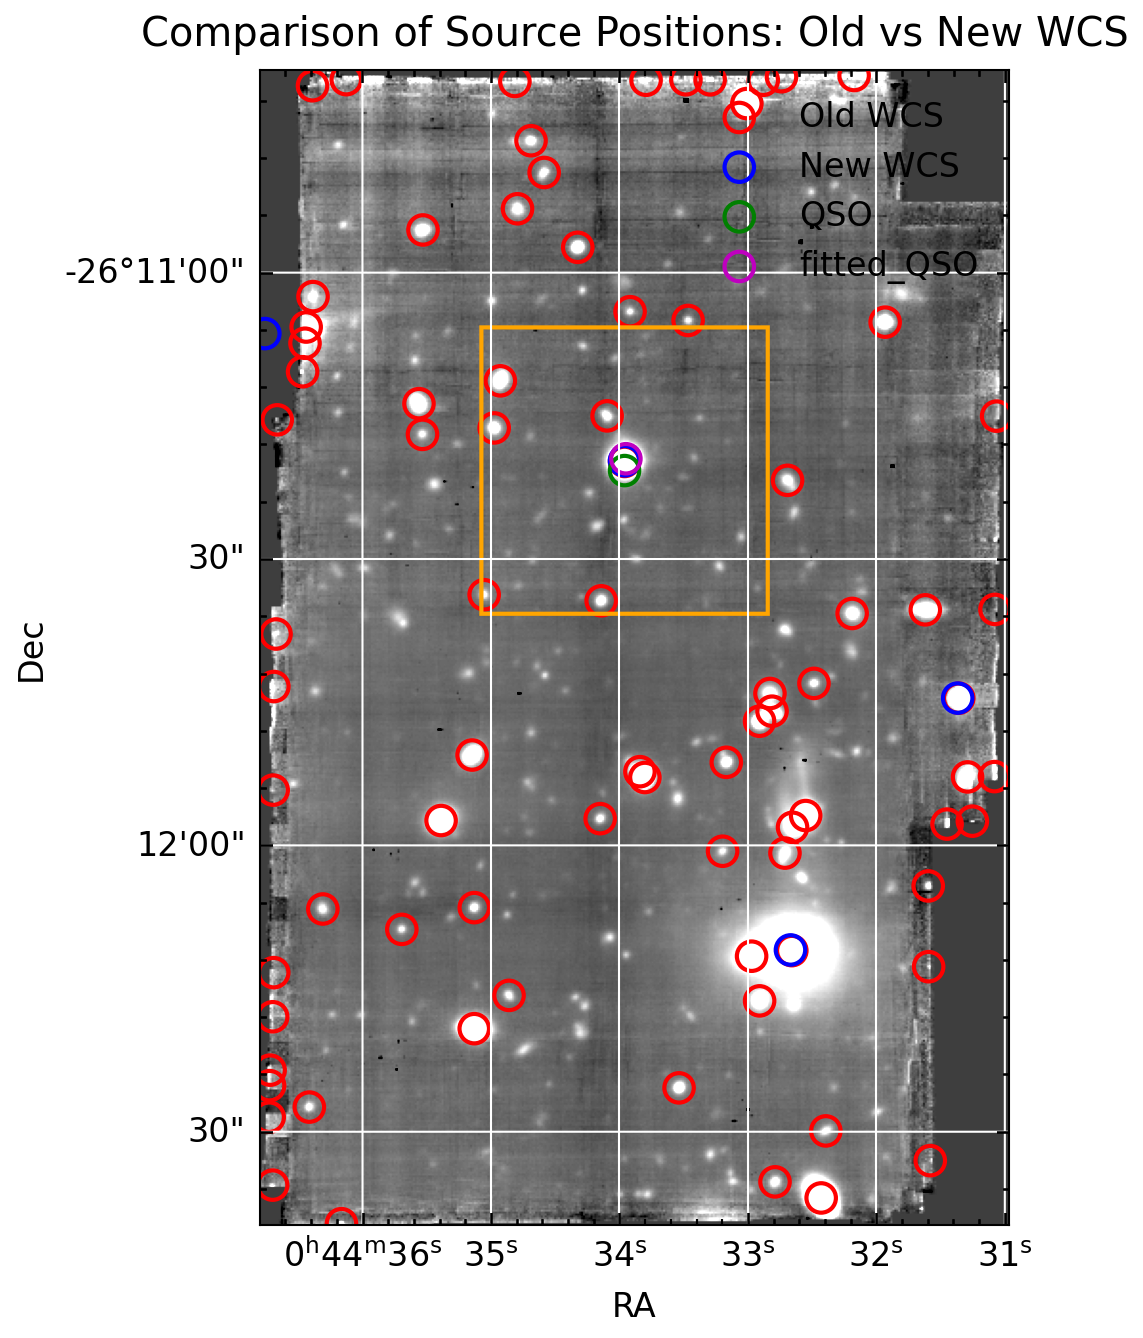

In [54]:
# Compare old and new WCS
# Transform positions using old WCS

plt.style.use(["science","no-latex"])
plt.rcParams.update({
    "font.family": "dejavu sans",   # specify font family here
    "font.serif": ["Times"],  # specify font here
    "font.size":8,
"legend.fancybox":True})


old_pixel_coords = np.transpose((sources['xcentroid'], sources['ycentroid']))
old_sky_coords = SkyCoord.from_pixel(old_pixel_coords[:,0], old_pixel_coords[:,1], wcs=old_wcs)

# Transform positions using new WCS
#new_sky_coords = SkyCoord.from_pixel(old_pixel_coords[:,0], old_pixel_coords[:,1], wcs=new_wcs)
new_sky_coords = SkyCoord(ra=matchedra,dec=matcheddec,unit=u.deg)
# Plot the positions
plt.figure(figsize=(5, 5),dpi=300)
plt.subplot(projection=old_wcs)
plt.imshow(data, origin='lower', cmap='gray', norm=ImageNormalize(data, interval=ZScaleInterval()))
plt.scatter(old_pixel_coords[:, 0], old_pixel_coords[:, 1], s=50, edgecolor='red', facecolor='none', label='Old WCS')
plt.scatter(new_sky_coords.to_pixel(old_wcs)[0], new_sky_coords.to_pixel(old_wcs)[1], s=50, edgecolor='blue', facecolor='none', label='New WCS')

plt.scatter(s_coord.to_pixel(old_wcs)[0],s_coord.to_pixel(old_wcs)[1],s=50, edgecolor='g', facecolor='none', label='QSO')
plt.scatter(191,401,s=50, edgecolor='m', facecolor='none', label='fitted_QSO')

from regions import RectangleSkyRegion
center = s_coord
region_sky4 = RectangleSkyRegion(center=center,
                                 width=30. * u.arcsec, height=30. * u.arcsec,
                                 angle=0.0 * u.deg)
region_pix4 = region_sky4.to_pixel(old_wcs)
ax=plt.gca()
region_pix4.plot(origin=(0, 0),ax=ax,color="orange")
plt.legend()
plt.xlabel('RA')
plt.ylabel('Dec')
plt.title('Comparison of Source Positions: Old vs New WCS')
plt.grid(color='white', ls='solid')
plt.show()

## Make a cutout data cube
For LBQS 2139-4434, the combined cube is unusually large (18 GB) and may have some compromised (negative) data such that the standard FITSIO Lib cannot handle.
I made a cutout around the central source to deal with this problem

In [291]:
from spectral_cube import SpectralCube
from astropy.io import fits
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord
import astropy.units as u
sys.path.append('/disk/bifrost/yuanze/KBSS/MUSEQSO')
import run_cubetools_MUSE as ctools
qname="LBQS 2139-4434"
source_table = ascii.read(KBSSpath+"/MUSEQSO/MUSEQSO_machine_readable_updated2.list",format="ipac")
sentry = source_table[source_table['Quasar'] == qname]
adp_file=ctools.find_adp_fits_file(KBSSpath+f"/MUSEQSO/{qname}")
hdu1=fits.open(f"{adp_file}.fits")

# Define the path to your FITS data cube
file_path = f"{adp_file}.fits"

# Load the data cube
cube = SpectralCube.read(file_path,hdu=1)
varcube = SpectralCube.read(file_path,hdu=2)
# Define the center of the cutout (in world coordinates)
#center_ra = s_coord.ra
#center_dec = s_coord.dec
ra,dec=sentry["RA"],sentry["Decl"]
s_coord=SkyCoord(ra=ra, dec=dec,unit=(u.hourangle,u.deg))

center = s_coord[0]#SkyCoord(center_ra, center_dec, frame='icrs')

# Define the size of the cutout (15 arcseconds on each side)
size = 20 * u.arcsec

# Calculate the cutout region in pixel coordinates
wcs = cube.wcs.celestial
center_pixel = wcs.world_to_pixel(center)
size_pixel = (size / wcs.wcs.cdelt[0]).decompose().value  # assuming square pixels

# Create the cutout
region_sky4 = RectangleSkyRegion(center=center,
                                 width=size, height=size,
                                 angle=0.0 * u.deg)
region_pix4=region_sky4.to_pixel(wcs)
cutout = cube.subcube_from_regions([region_pix4])
varcutout = varcube.subcube_from_regions([region_pix4])
# Save the cutout to a new FITS file
#cutout.write(f"{adp_file}.cutout.fits",format="fits",overwrite=True)


In [301]:
xpix,ypix=cutout.wcs.celestial.world_to_pixel(center)

In [312]:
xpix[0]

IndexError: too many indices for array: array is 0-dimensional, but 1 were indexed

In [300]:
cutout.header["CRPIX1"]

143.0

In [313]:
hdr1=hdu1[1].header
hdr2=hdu1[2].header
hdr1["CRPIX1"]=float(xpix)
hdr1["CRPIX2"]=float(ypix)
hdr1["NAXIS1"]=cutout.header["NAXIS1"]
hdr1["NAXIS2"]=cutout.header["NAXIS2"]
hdr1["CRVAL1"]=center.to_string().split(" ")[0]
hdr1["CRVAL2"]=center.to_string().split(" ")[1]

hdr2["CRPIX1"]=float(xpix)
hdr2["CRPIX2"]=float(ypix)
hdr2["NAXIS1"]=varcutout.header["NAXIS1"]
hdr2["NAXIS2"]=varcutout.header["NAXIS2"]
hdr2["CRVAL1"]=center.to_string().split(" ")[0]
hdr2["CRVAL2"]=center.to_string().split(" ")[1]

In [314]:
hdu_first=fits.PrimaryHDU(header=hdu1[0].header)
hdu_cut=fits.ImageHDU(data=cutout.unmasked_data[:].value,header=hdr1)
hdu_varcut=fits.ImageHDU(data=varcutout.unmasked_data[:].value,header=hdr2)

In [315]:
hdu_list=fits.HDUList(hdus=[hdu_first,hdu_cut,hdu_varcut])
#hdu_cut.writeto(f"{adp_file}.cutout.fits",overwrite=True)
hdu_list.writeto(f"{adp_file}.cutout.fits",overwrite=True)

In [585]:
wcs_cut=cutout.wcs.celestial
wcs_cut.world_to_pixel(center)
#imshow_astro(np.nansum(cutout.unmasked_data[:],axis=0))

(array(74.08586764), array(74.01108936))

In [316]:
hducutout=fits.open(f"{adp_file}.cutout.fits",hdu=1)

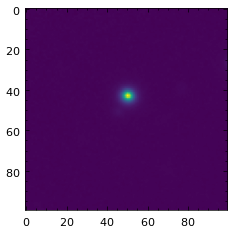

In [322]:
plt.imshow(hducutout[1].data[150,:,:])

In [323]:
hducutout[1].data[150,:,:]

array([[ 0.4226102 ,  0.05238592, -0.28978604, ...,  0.70465916,
        -1.116819  , -0.2304248 ],
       [ 0.26966706,  1.585533  ,  0.47424814, ...,  0.14073746,
        -0.47148547, -1.5245142 ],
       [-0.08596708,  1.1628637 ,  0.1922206 , ...,  0.33880547,
        -0.23821445, -0.20691729],
       ...,
       [-0.5894909 ,  0.15784027,  0.694485  , ..., -0.10891499,
        -0.68090475,  0.11350864],
       [ 0.8123948 ,  0.05509567,  0.29461798, ..., -0.14443806,
         0.0230543 , -0.20314664],
       [ 1.2296278 ,  1.7570561 , -0.18038072, ..., -0.15876481,
        -0.46284944, -0.05187426]], dtype=float32)

In [551]:

center_ra = s_coord.ra
center_dec = s_coord.dec

In [565]:
print(f"{center_ra.hms}")

hms_tuple(h=21.0, m=42.0, s=25.807999999993854)
